In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
sys.path.insert(1, '/home/jw3514/Work/UNIMED/src')
from CellType_PSY import *
from UNIMED import *
import yaml
from pingouin import partial_corr
import igraph as ig
#import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

os.chdir("/home/jw3514/Work/UNIMED/notebooks/")

with open("../config/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Go Term correlation and partial correlation with PCs

### Load Data

In [ ]:
pc_scores_all = load_pc_loadings(config, "pc_scores.csv", verbose=False)
GoTermDF = pd.read_csv("/home/jw3514/Work/CellType_Psy/dat3/Goterms/go.terms.selected.csv", index_col=0, delimiter="\t")

In [3]:
GoTermDF[GoTermDF['GoName'].str.contains('histone', case=False, na=False)]

GoName  Ngenes
GoID                                                                
GO:0032454                 histone H3K9 demethylase activity      14
GO:0042393                                   histone binding     248
GO:0035064                        methylated histone binding      77
GO:1990226                 histone methyltransferase binding      16
GO:0042826                       histone deacetylase binding     123
GO:0032452                      histone demethylase activity      30
GO:0042800           histone H3K4 methyltransferase activity      19
GO:0043997          histone H4K12 acetyltransferase activity      12
GO:0010485             histone H4 acetyltransferase activity      22
GO:0004402                histone acetyltransferase activity      41
GO:0070577                 lysine-acetylated histone binding      24
GO:0004407                      histone deacetylase activity      21
GO:0035173                           histone kinase activity      20
GO:0042054                histone methyltransferase activity      66
GO:0046974           histone H3K9 methyltransferase activity      13
GO:0010484             histone H3 acetyltransferase activity      14
GO:0043995           histone H4K5 acetyltransferase activity      11
GO:0043996           histone H4K8 acetyltransferase activity      11
GO:0035035                 histone acetyltransferase binding      24
GO:0046975          histone H3K36 methyltransferase activity      13
GO:0140713                        histone chaperone activity      12
GO:0140938             histone H3 methyltransferase activity      41
GO:0140939             histone H4 methyltransferase activity      16
GO:0035267            NuA4 histone acetyltransferase complex      31
GO:0035097                 histone methyltransferase complex      63
GO:0000118                       histone deacetylase complex      82
GO:0000123                 histone acetyltransferase complex      94
GO:1902562              H4 histone acetyltransferase complex      45
GO:0008334                    histone mRNA metabolic process      20
GO:0016573                               histone acetylation      83
GO:0051568                         histone H3-K4 methylation      28
GO:0043966                            histone H3 acetylation      37
GO:0035522    monoubiquitinated histone H2A deubiquitination      28
GO:0035521        monoubiquitinated histone deubiquitination      28
GO:0071044                    histone mRNA catabolic process      11
GO:0043984                        histone H4-K16 acetylation      13
GO:0043981                         histone H4-K5 acetylation      16
GO:0043982                         histone H4-K8 acetylation      16
GO:0051571  positive regulation of histone H3-K4 methylation      16
GO:0016575                             histone deacetylation      29
GO:0031065      positive regulation of histone deacetylation      13
GO:0031062        positive regulation of histone methylation      24
GO:0034968                        histone lysine methylation      49
GO:0035066        positive regulation of histone acetylation      16
GO:0035065                 regulation of histone acetylation      28
GO:0044154                        histone H3-K14 acetylation      11
GO:0031063               regulation of histone deacetylation      26
GO:0043967                            histone H4 acetylation      39
GO:0016570                              histone modification     209
GO:0043968                           histone H2A acetylation      21
GO:0035518                    histone H2A monoubiquitination      11
GO:0031060                 regulation of histone methylation      28
GO:0016574                            histone ubiquitination      19
GO:0033522                        histone H2A ubiquitination      13
GO:0016571                               histone methylation      59
GO:0016578                          histone deubiquitination      36
GO:0010390                        histone monoubiqui

In [4]:
GoTermDF[GoTermDF['GoName'].str.contains('chromatin', case=False, na=False)]

GoName  Ngenes
GoID                                                                 
GO:0030527                structural constituent of chromatin      64
GO:0031490                              chromatin DNA binding     119
GO:0140658         ATP-dependent chromatin remodeler activity      36
GO:1990841                promoter-specific chromatin binding      65
GO:0140463                 chromatin-protein adaptor activity      11
GO:0000791                                        euchromatin      59
GO:0005677                        chromatin silencing complex      13
GO:0000792                                    heterochromatin      79
GO:0005721                        pericentric heterochromatin      30
GO:0045815  transcription initiation-coupled chromatin rem...      37
GO:0031507                          heterochromatin formation      61
GO:1902275               regulation of chromatin organization      50
GO:0140861          DNA repair-dependent chromatin remodeling      18
GO:0071168                  protein localization to chromatin      35
GO:0090308  regulation of DNA methylation-dependent hetero...      18
GO:0035563           positive regulation of chromatin binding      15
GO:0070828                       heterochromatin organization      75
GO:0006346  DNA methylation-dependent heterochromatin form...      14
GO:0031453   positive regulation of heterochromatin formation      14
GO:1905269      positive regulation of chromatin organization      15
GO:0140718              facultative heterochromatin formation      25
GO:0090309  positive regulation of DNA methylation-depende...      11
GO:0031445            regulation of heterochromatin formation      24

In [5]:
PSD_HumanCT = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/HumanCT_PSD_Spec.csv", index_col=0)
PSD_MouseCT = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseCT_PSD_Spec.csv", index_col=0)
PSD_MouseSTR = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseSTR_PSD.csv", index_col=0)

In [6]:
def load_GoBias(GoTermDF, mode = "HumanCT"):
    All_Go_Bias = {}
    shared_index = None

    # Load GO bias data with improved error handling and progress tracking
    total_terms = len(GoTermDF.index.values)
    for i, GoID in enumerate(GoTermDF.index.values):
        if i > 0 and i % 100 == 0:
            print(f"\rLoaded {i}/{total_terms} GO terms ({i/total_terms*100:.1f}%)...", end="", flush=True)
        
        try:
            # Updated path to use new results structure
            file_path = f"/home/jw3514/Work/UNIMED/results/goterms/{mode}/Go_Biases/GoBias.{GoID[3:]}.spec.csv"
            Go_Bias = pd.read_csv(file_path, index_col=0)
            
            # Establish shared index from first successful file
            if shared_index is None:
                shared_index = Go_Bias.sort_index().index.values
            
            All_Go_Bias[GoID] = Go_Bias.sort_index()["EFFECT"].values
            
        except FileNotFoundError:
            print(f"\nWarning: File not found for {GoID}")
            continue
        except Exception as e:
            print(f"\nWarning: Error loading {GoID}: {str(e)}")
            continue

    print(f"\rLoaded {len(All_Go_Bias)}/{total_terms} GO terms successfully ({len(All_Go_Bias)/total_terms*100:.1f}%)")

    # Create DataFrame using pd.concat for better performance
    if All_Go_Bias and shared_index is not None:
        All_Go_Bias_DF = pd.concat([
            pd.Series(data, name=goid, index=shared_index) 
            for goid, data in All_Go_Bias.items()
        ], axis=1)
        All_Go_Bias_DF = All_Go_Bias_DF.fillna(0)
    else:
        raise ValueError("No GO bias data was successfully loaded")

    # Load PSD data based on mode
    psd_file_mapping = {
        "HumanCT": "/home/jw3514/Work/UNIMED/results/goterms/HumanCT_PSD_Spec.csv",
        "MouseCT": "/home/jw3514/Work/UNIMED/results/goterms/MouseCT_PSD_Spec.csv",
        "MouseSTR": "/home/jw3514/Work/UNIMED/results/goterms/MouseSTR_PSD.csv"
    }

    if mode not in psd_file_mapping:
        raise ValueError(f"Invalid mode: {mode}. Must be one of {list(psd_file_mapping.keys())}")

    try:
        PSD = pd.read_csv(psd_file_mapping[mode], index_col=0)
        for i in All_Go_Bias_DF.index.values:
            All_Go_Bias_DF.loc[i, "GO:0014069"] = PSD.loc[i, "EFFECT"]
    except FileNotFoundError:
        raise FileNotFoundError(f"PSD file not found for mode {mode}: {psd_file_mapping[mode]}")
    return All_Go_Bias_DF

In [7]:
HumanCT_GoBias = load_GoBias(GoTermDF, "HumanCT")
ct_idx = HumanCT_GoBias.index.values
HumanCT_GoBias["PC1"] = pc_scores_all["PGC"]["HumanCT"]["top_gene_enrich"]["Empty"].loc[ct_idx, "PC1"].values
HumanCT_GoBias["PSD"] = PSD_HumanCT.loc[ct_idx, "EFFECT"].values

Loaded 100/6252 GO terms (1.6%)...
Loaded 200/6252 GO terms (3.2%)...

Loaded 400/6252 GO terms (6.4%)...
Loaded 500/6252 GO terms (8.0%)...
Loaded 700/6252 GO terms (11.2%)...
Loaded 900/6252 GO terms (14.4%)...
Loaded 1100/6252 GO terms (17.6%)...
Loaded 1300/6252 GO terms (20.8%)...

Loaded 1400/6252 GO terms (22.4%)...
Loaded 1600/6252 GO terms (25.6%)...
Loaded 1700/6252 GO terms (27.2%)...

Loaded 2100/6252 GO terms (33.6%)...

Loaded 2200/6252 GO terms (35.2%)...
Loaded 2400/6252 GO terms (38.4%)...




Loaded 2500/6252 GO terms (40.0%)...

Loaded 2600/6252 GO terms (41.6%)...

Loaded 2700/6252 GO terms (43.2%)...

Loaded 2900/6252 GO terms (46.4%)...

Loaded 3000/6252 GO terms (48.0%)...

Loaded 3200/6252 GO terms (51.2%)...


Loaded 3300/6252 GO terms (52.8%)...


Loaded 3400/6252 GO terms (54.4%)...


Loaded 3500/6252 GO terms (56.0%)...





Loaded 3600/6252 GO terms (57.6%)...

Loaded 3700/6252 GO terms (59.2%)...




Loaded 3800/6252 GO terms (60.8%)...

Loaded 3900/6252 G

In [8]:
def analyze_go_terms_correlation(GoBiasDF,mode='HumanCT', top_n=10, save_figures=True, output_prefix=None):
    """
    Analyze GO terms correlation with PC1, controlling for PSD bias.
    
    Parameters:
    -----------
    mode : str
    """
    ct_idx = GoBiasDF.index.values
    partial_corr_results = {}
    for i, GOID in enumerate(GoBiasDF.columns.values):
        if GOID in ["PC1", "PSD"]:  # Skip the PC1 and PSD columns
            continue
            
        # Calculate original correlation using Spearman
        orig_r, orig_p = scipy.stats.spearmanr(GoBiasDF[GOID], GoBiasDF["PC1"])
        
        # Calculate partial correlation controlling for PSD using Spearman method
        result = partial_corr(data=GoBiasDF, x=GOID, y="PC1", covar="PSD", method="spearman")
        partial_r = result["r"].values[0]  
        partial_p = result["p-val"].values[0]
        
        partial_corr_results[GOID] = {
            "orig_r": orig_r,
            "orig_p": orig_p,
            "partial_r": partial_r, 
            "partial_p": partial_p
        }

    # Save results to DataFrame and CSV
    partial_corr_df = pd.DataFrame.from_dict(partial_corr_results, orient='index')
    partial_corr_df = partial_corr_df.merge(GoTermDF[['GoName']], left_index=True, right_index=True, how='left')
    partial_corr_df = partial_corr_df.sort_values(by="partial_r", ascending=False)
    partial_corr_df.loc["GO:0014069", "partial_r"] = 0
    return partial_corr_df


In [9]:
HumanCT_partial_corr_df = analyze_go_terms_correlation(HumanCT_GoBias)
HumanCT_partial_corr_df.head(20)

orig_r         orig_p  partial_r      partial_p  \
GO:0014069  0.842911  1.239704e-125   0.000000  2.306563e-125   
GO:0043687  0.554775   1.450021e-38   0.519765   3.409910e-33   
GO:0004722  0.552175   3.774213e-38   0.486493   1.051104e-28   
GO:0035967  0.012196   7.939644e-01   0.484400   1.940134e-28   
GO:0004721  0.773192   7.850242e-93   0.480270   6.425470e-28   
GO:0032007  0.272144   2.853732e-09   0.479642   7.697940e-28   
GO:0044804  0.323415   1.100431e-12   0.476090   2.123237e-27   
GO:0051170  0.441325   2.143753e-23   0.476047   2.149257e-27   
GO:0046966  0.067336   1.488826e-01   0.474249   3.575978e-27   
GO:0031258 -0.175273   1.553437e-04   0.474007   3.829161e-27   
GO:0006606  0.414670   1.388388e-20   0.458878   2.460798e-25   
GO:0042149 -0.113556   1.471063e-02   0.458068   3.056843e-25   
GO:0001217  0.206363   7.934389e-06   0.446104   7.061829e-24   
GO:0006470  0.804154  9.425485e-106   0.443997   1.212028e-23   
GO:0001227  0.210588   5.103831e-06   0.441970   2.030716e-23   
GO:0000118  0.209694   5.607280e-06   0.441949   2.041576e-23   
GO:0097320  0.055355   2.355406e-01   0.439401   3.886899e-23   
GO:0042752  0.661396   2.582590e-59   0.436523   7.991211e-23   
GO:0042826 -0.086272   6.420250e-02   0.435943   9.231326e-23   
GO:0010508 -0.133835   3.993054e-03   0.434945   1.182957e-22   

                                                       GoName  
GO:0014069                               postsynaptic density  
GO:0043687            post-translational protein modification  
GO:0004722      protein serine/threonine phosphatase activity  
GO:0035967  cellular response to topologically incorrect p...  
GO:0004721                phosphoprotein phosphatase activity  
GO:0032007               negative regulation of TOR signaling  
GO:0044804                                        nucleophagy  
GO:0051170                                import into nucleus  
GO:0046966           nuclear thyroid hormone receptor binding  
GO:0031258                             lamellipodium membrane  
GO:0006606                        protein import into nucleus  
GO:0042149            cellular response to glucose starvation  
GO:0001217       DNA-binding transcription repressor activity  
GO:0006470                          protein dephosphorylation  
GO:0001227  DNA-binding transcription repressor activity, ...  
GO:0000118                        histone deacetylase complex  
GO:0097320                         plasma membrane tubulation  
GO:0042752                     regulation of circadian rhythm  
GO:0042826                        histone deacetylase binding  
GO:0010508                   positive regulation of autophagy

In [10]:
def plot_go_correlation_analysis(partial_corr_df, top_n=10, figsize=(10, 5), save_figures=True, output_prefix="GO_terms_PC1_correlation_analysis"):
    """
    Plot GO terms correlation analysis with original and partial correlations.
    
    Parameters:
    -----------
    partial_corr_df : pd.DataFrame
        DataFrame containing correlation results with columns: 'orig_r', 'partial_r', 'GoName'
    top_n : int
        Number of top GO terms to display in plots
    figsize : tuple
        Figure size as (width, height)
    save_figures : bool
        Whether to save the generated figures
    output_prefix : str
        Prefix for output files
    """
    
    # Function to wrap text into multiple lines
    def wrap_text(text, max_line_length=28):
        """Break text into multiple lines, trying to break at word boundaries."""
        import textwrap
        lines = textwrap.wrap(text, width=max_line_length)
        return '\n'.join(lines)

    # Set publication-quality style
    plt.style.use('default')
    plt.rcParams.update({
        'font.size': 20,
        'font.family': 'Arial',
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'grid.alpha': 0.3,
        'grid.linewidth': 0.8,
        'legend.frameon': True,
        'legend.fancybox': False,
        'legend.edgecolor': 'black',
        'xtick.major.width': 1.2,
        'ytick.major.width': 1.2,
        'figure.dpi': 300
    })

    # Get top N GO terms by original correlation and by partial correlation
    top20_orig = partial_corr_df.sort_values(by="orig_r", ascending=False).head(top_n)
    top20_partial = partial_corr_df.sort_values(by="partial_r", ascending=False).head(top_n)

    # Define publication-quality colors
    color_original = '#2E86AB'    # Professional blue
    color_partial = '#A23B72'     # Professional magenta

    # Create the plot with 1x2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, dpi=300)
    yticks_fontsize = 40

    # First subplot - Ranked by original correlation (highest at top)
    y_pos1 = np.arange(len(top20_orig))
    width = 0.38

    # For correct ranking: reverse the data order so highest values appear at top positions
    orig_r_values = top20_orig['orig_r'].values[::-1]  # Reverse so highest is at top
    partial_r_values = top20_orig['partial_r'].values[::-1]  # Reverse so highest is at top
    go_names_1 = top20_orig['GoName'].values[::-1]  # Reverse so highest is at top

    bars1_1 = ax1.barh(y_pos1 - width/2, orig_r_values, width, 
                       label='Correlation', color=color_original, alpha=0.8, edgecolor='white', linewidth=0.8)
    bars1_2 = ax1.barh(y_pos1 + width/2, partial_r_values, width, 
                       label='Partial correlation', color=color_partial, alpha=0.8, edgecolor='white', linewidth=0.8)

    # Customize the first plot
    #ax1.set_ylabel('GO Terms', fontweight='bold', fontsize=11)
    ax1.set_xlabel('Correlation with Neural P-Factor', fontweight='bold', fontsize=11)
    #ax1.set_title('A. Ranked by Original Correlation with PC1', fontweight='bold', fontsize=12, pad=15)
    ax1.set_yticks(y_pos1)

    # Apply text wrapping and format GO term names
    wrapped_names1 = [wrap_text(go_name) for go_name in go_names_1]
    ax1.set_yticklabels(wrapped_names1, fontsize=yticks_fontsize, va='center')
    # legend1 = ax1.legend(loc='lower right', fontsize=10)
    # legend1.get_frame().set_linewidth(1.0)  # Set legend border width manually
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.set_xlim(0, max(max(top20_orig['orig_r']), max(top20_orig['partial_r'])) * 1.15)

    # Add value labels on bars for first plot
    for i, (orig_r, partial_r) in enumerate(zip(orig_r_values, partial_r_values)):
        # Only show values for bars longer than threshold to avoid clutter
        if orig_r > 0.1:
            ax1.text(orig_r - 0.02, i - width/2, f'{orig_r:.2f}', ha='right', va='center', 
                    fontsize=8, fontweight='bold', color='white')
        if partial_r > 0.1:
            ax1.text(partial_r - 0.02, i + width/2, f'{partial_r:.2f}', ha='right', va='center', 
                    fontsize=8, fontweight='bold', color='white')

    # Second subplot - Ranked by partial correlation (highest at top)
    y_pos2 = np.arange(len(top20_partial))

    # For correct ranking: reverse the data order so highest values appear at top positions
    orig_r_values_2 = top20_partial['orig_r'].values[::-1]  # Reverse so highest partial_r is at top
    partial_r_values_2 = top20_partial['partial_r'].values[::-1]  # Reverse so highest partial_r is at top
    go_names_2 = top20_partial['GoName'].values[::-1]  # Reverse so highest partial_r is at top

    bars2_1 = ax2.barh(y_pos2 - width/2, orig_r_values_2, width, 
                       label='Correlation', color=color_original, alpha=0.8, edgecolor='white', linewidth=0.8)
    bars2_2 = ax2.barh(y_pos2 + width/2, partial_r_values_2, width, 
                       label='Partial correlation', color=color_partial, alpha=0.8, edgecolor='white', linewidth=0.8)

    # Customize the second plot
    #ax2.set_ylabel('GO Terms', fontweight='bold', fontsize=11)
    ax2.set_xlabel('Correlation with Neural P-Factor', fontweight='bold', fontsize=11)
    #ax2.set_title('B. Ranked by Partial Correlation with PC1', fontweight='bold', fontsize=12, pad=15)
    ax2.set_yticks(y_pos2)

    # Apply text wrapping to GO term names
    wrapped_names2 = [wrap_text(go_name) for go_name in go_names_2]
    ax2.set_yticklabels(wrapped_names2, fontsize=yticks_fontsize, va='center')
    legend2 = ax2.legend(loc='lower right', fontsize=8)
    legend2.get_frame().set_linewidth(1.0)  # Set legend border width manually
    ax2.grid(True, alpha=0.3, axis='x')
    ax2.set_xlim(0, max(max(top20_partial['orig_r']), max(top20_partial['partial_r'])) * 1.15)

    # Add value labels on bars for second plot
    for i, (orig_r, partial_r) in enumerate(zip(orig_r_values_2, partial_r_values_2)):
        # Only show values for bars longer than threshold to avoid clutter
        if orig_r > 0.1:
            ax2.text(orig_r - 0.02, i - width/2, f'{orig_r:.2f}', ha='right', va='center', 
                    fontsize=8, fontweight='bold', color='white')
        if partial_r > 0.1:
            ax2.text(partial_r - 0.02, i + width/2, f'{partial_r:.2f}', ha='right', va='center', 
                    fontsize=8, fontweight='bold', color='white')

    # Adjust spacing between bars for better visual separation
    plt.subplots_adjust(left=0.28, right=0.98, wspace=0.35, top=0.92, bottom=0.08)

    # Ensure consistent y-axis limits for comparison
    max_terms = max(len(top20_orig), len(top20_partial))
    for ax in [ax1, ax2]:
        ax.set_ylim(-0.5, max_terms - 0.5)
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='x', which='major', length=4)
        ax.tick_params(axis='y', which='major', length=0)  # Remove y-axis ticks

    plt.tight_layout()
    plt.show()

    # Save high-resolution figure if requested
    if save_figures:
        plt.savefig(f'{output_prefix}.pdf', dpi=300, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
        plt.savefig(f'{output_prefix}.png', dpi=300, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')


In [11]:
# Call the function with the existing data
plot_go_correlation_analysis(HumanCT_partial_corr_df, top_n=15, figsize=(10, 6))

<Figure size 1920x1440 with 0 Axes>

In [12]:
MouseCT_GoBias = load_GoBias(GoTermDF, "MouseCT")
ct_idx = MouseCT_GoBias.index.values
MouseCT_GoBias["PC1"] = pc_scores_all["PGC"]["MouseCT"]["top_gene_enrich"]["Empty"].loc[ct_idx, "PC1"].values
MouseCT_GoBias["PSD"] = PSD_MouseCT.loc[ct_idx, "EFFECT"].values

Loaded 100/6252 GO terms (1.6%)...
Loaded 200/6252 GO terms (3.2%)...

Loaded 400/6252 GO terms (6.4%)...
Loaded 500/6252 GO terms (8.0%)...
Loaded 700/6252 GO terms (11.2%)...
Loaded 900/6252 GO terms (14.4%)...
Loaded 1100/6252 GO terms (17.6%)...
Loaded 1300/6252 GO terms (20.8%)...

Loaded 1400/6252 GO terms (22.4%)...
Loaded 1600/6252 GO terms (25.6%)...
Loaded 1700/6252 GO terms (27.2%)...

Loaded 2100/6252 GO terms (33.6%)...

Loaded 2200/6252 GO terms (35.2%)...
Loaded 2400/6252 GO terms (38.4%)...




Loaded 2500/6252 GO terms (40.0%)...

Loaded 2600/6252 GO terms (41.6%)...

Loaded 2700/6252 GO terms (43.2%)...

Loaded 2900/6252 GO terms (46.4%)...

Loaded 3000/6252 GO terms (48.0%)...

Loaded 3200/6252 GO terms (51.2%)...


Loaded 3300/6252 GO terms (52.8%)...


Loaded 3400/6252 GO terms (54.4%)...


Loaded 3500/6252 GO terms (56.0%)...





Loaded 3600/6252 GO terms (57.6%)...

Loaded 3700/6252 GO terms (59.2%)...




Loaded 3800/6252 GO terms (60.8%)...

Loaded 3900/6252 G

In [13]:
MouseCT_GoBias.head(2)

GO:0016712  GO:0005506  GO:0020037  GO:0070330  \
0001 CLA-EPd-CTX Car3 Glut_1    0.393725    0.734109    0.666181    0.178719   
0002 CLA-EPd-CTX Car3 Glut_1    0.471214    0.724533    0.687546    0.285804   

                              GO:0008017  GO:0004984  GO:0042287  GO:0042605  \
0001 CLA-EPd-CTX Car3 Glut_1    0.807162         0.0    0.510966    0.552205   
0002 CLA-EPd-CTX Car3 Glut_1    0.787608         0.0    0.610304    0.523779   

                              GO:0033130  GO:0004675  ...  GO:0040013  \
0001 CLA-EPd-CTX Car3 Glut_1    0.811808    0.791722  ...    0.776737   
0002 CLA-EPd-CTX Car3 Glut_1    0.775626    0.783216  ...    0.764064   

                              GO:0060004  GO:0042772  GO:0046051  GO:0098935  \
0001 CLA-EPd-CTX Car3 Glut_1    0.606527    0.562185    0.893081    1.092852   
0002 CLA-EPd-CTX Car3 Glut_1    0.553141    0.614075    0.900127    1.060224   

                              GO:0036508  GO:0051153  GO:0090083       PC1  \
0001 CLA-EPd-CTX Car3 Glut_1    0.970991    0.736250    0.934829  3.278039   
0002 CLA-EPd-CTX Car3 Glut_1    0.994829    0.684524    0.941887  0.950918   

                                   PSD  
0001 CLA-EPd-CTX Car3 Glut_1  1.076062  
0002 CLA-EPd-CTX Car3 Glut_1  1.071804  

[2 rows x 6156 columns]

In [14]:
MouseCT_partial_corr_df = analyze_go_terms_correlation(MouseCT_GoBias)
MouseCT_partial_corr_df.head(20)

/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero e

orig_r         orig_p  partial_r      partial_p  \
GO:0014069  0.690582   0.000000e+00   0.000000   0.000000e+00   
GO:0007399  0.714212   0.000000e+00   0.494323   0.000000e+00   
GO:0016363  0.633811   0.000000e+00   0.478094  1.522069e-301   
GO:0042826  0.464280  2.718235e-282   0.463333  5.998869e-281   
GO:0045814  0.420403  1.470214e-226   0.457441  5.251604e-273   
GO:0016607  0.458226  4.172727e-274   0.452887  5.655339e-267   
GO:0070577  0.453814  3.035692e-268   0.452116  5.817197e-266   
GO:0000123  0.579747   0.000000e+00   0.444705  2.309287e-256   
GO:0016514  0.557791   0.000000e+00   0.440375  7.277780e-251   
GO:1902493  0.562189   0.000000e+00   0.440341  8.028308e-251   
GO:0006397  0.476935  6.033057e-300   0.435736  4.616779e-245   
GO:0061733  0.402918  1.493533e-206   0.431568  6.330707e-240   
GO:1904949  0.630039   0.000000e+00   0.430180  3.127822e-238   
GO:0008187  0.322606  6.477235e-129   0.429919  6.513019e-238   
GO:0030674  0.670478   0.000000e+00   0.428467  3.773532e-236   
GO:0003714  0.577401   0.000000e+00   0.428000  1.386549e-235   
GO:0003727  0.367666  1.032462e-169   0.427183  1.340745e-234   
GO:0001217  0.384736  5.514824e-187   0.425466  1.555381e-232   
GO:0001227  0.380046  3.902473e-182   0.423977  9.389467e-231   
GO:0006351  0.542774   0.000000e+00   0.419863  7.022633e-226   

                                                       GoName  
GO:0014069                               postsynaptic density  
GO:0007399                         nervous system development  
GO:0016363                                     nuclear matrix  
GO:0042826                        histone deacetylase binding  
GO:0045814  negative regulation of gene expression, epigen...  
GO:0016607                                      nuclear speck  
GO:0070577                  lysine-acetylated histone binding  
GO:0000123                  histone acetyltransferase complex  
GO:0016514                                    SWI/SNF complex  
GO:1902493                          acetyltransferase complex  
GO:0006397                                    mRNA processing  
GO:0061733        peptide-lysine-N-acetyltransferase activity  
GO:1904949                                     ATPase complex  
GO:0008187                      poly-pyrimidine tract binding  
GO:0030674             protein-macromolecule adaptor activity  
GO:0003714                 transcription corepressor activity  
GO:0003727                        single-stranded RNA binding  
GO:0001217       DNA-binding transcription repressor activity  
GO:0001227  DNA-binding transcription repressor activity, ...  
GO:0006351                        DNA-templated transcription

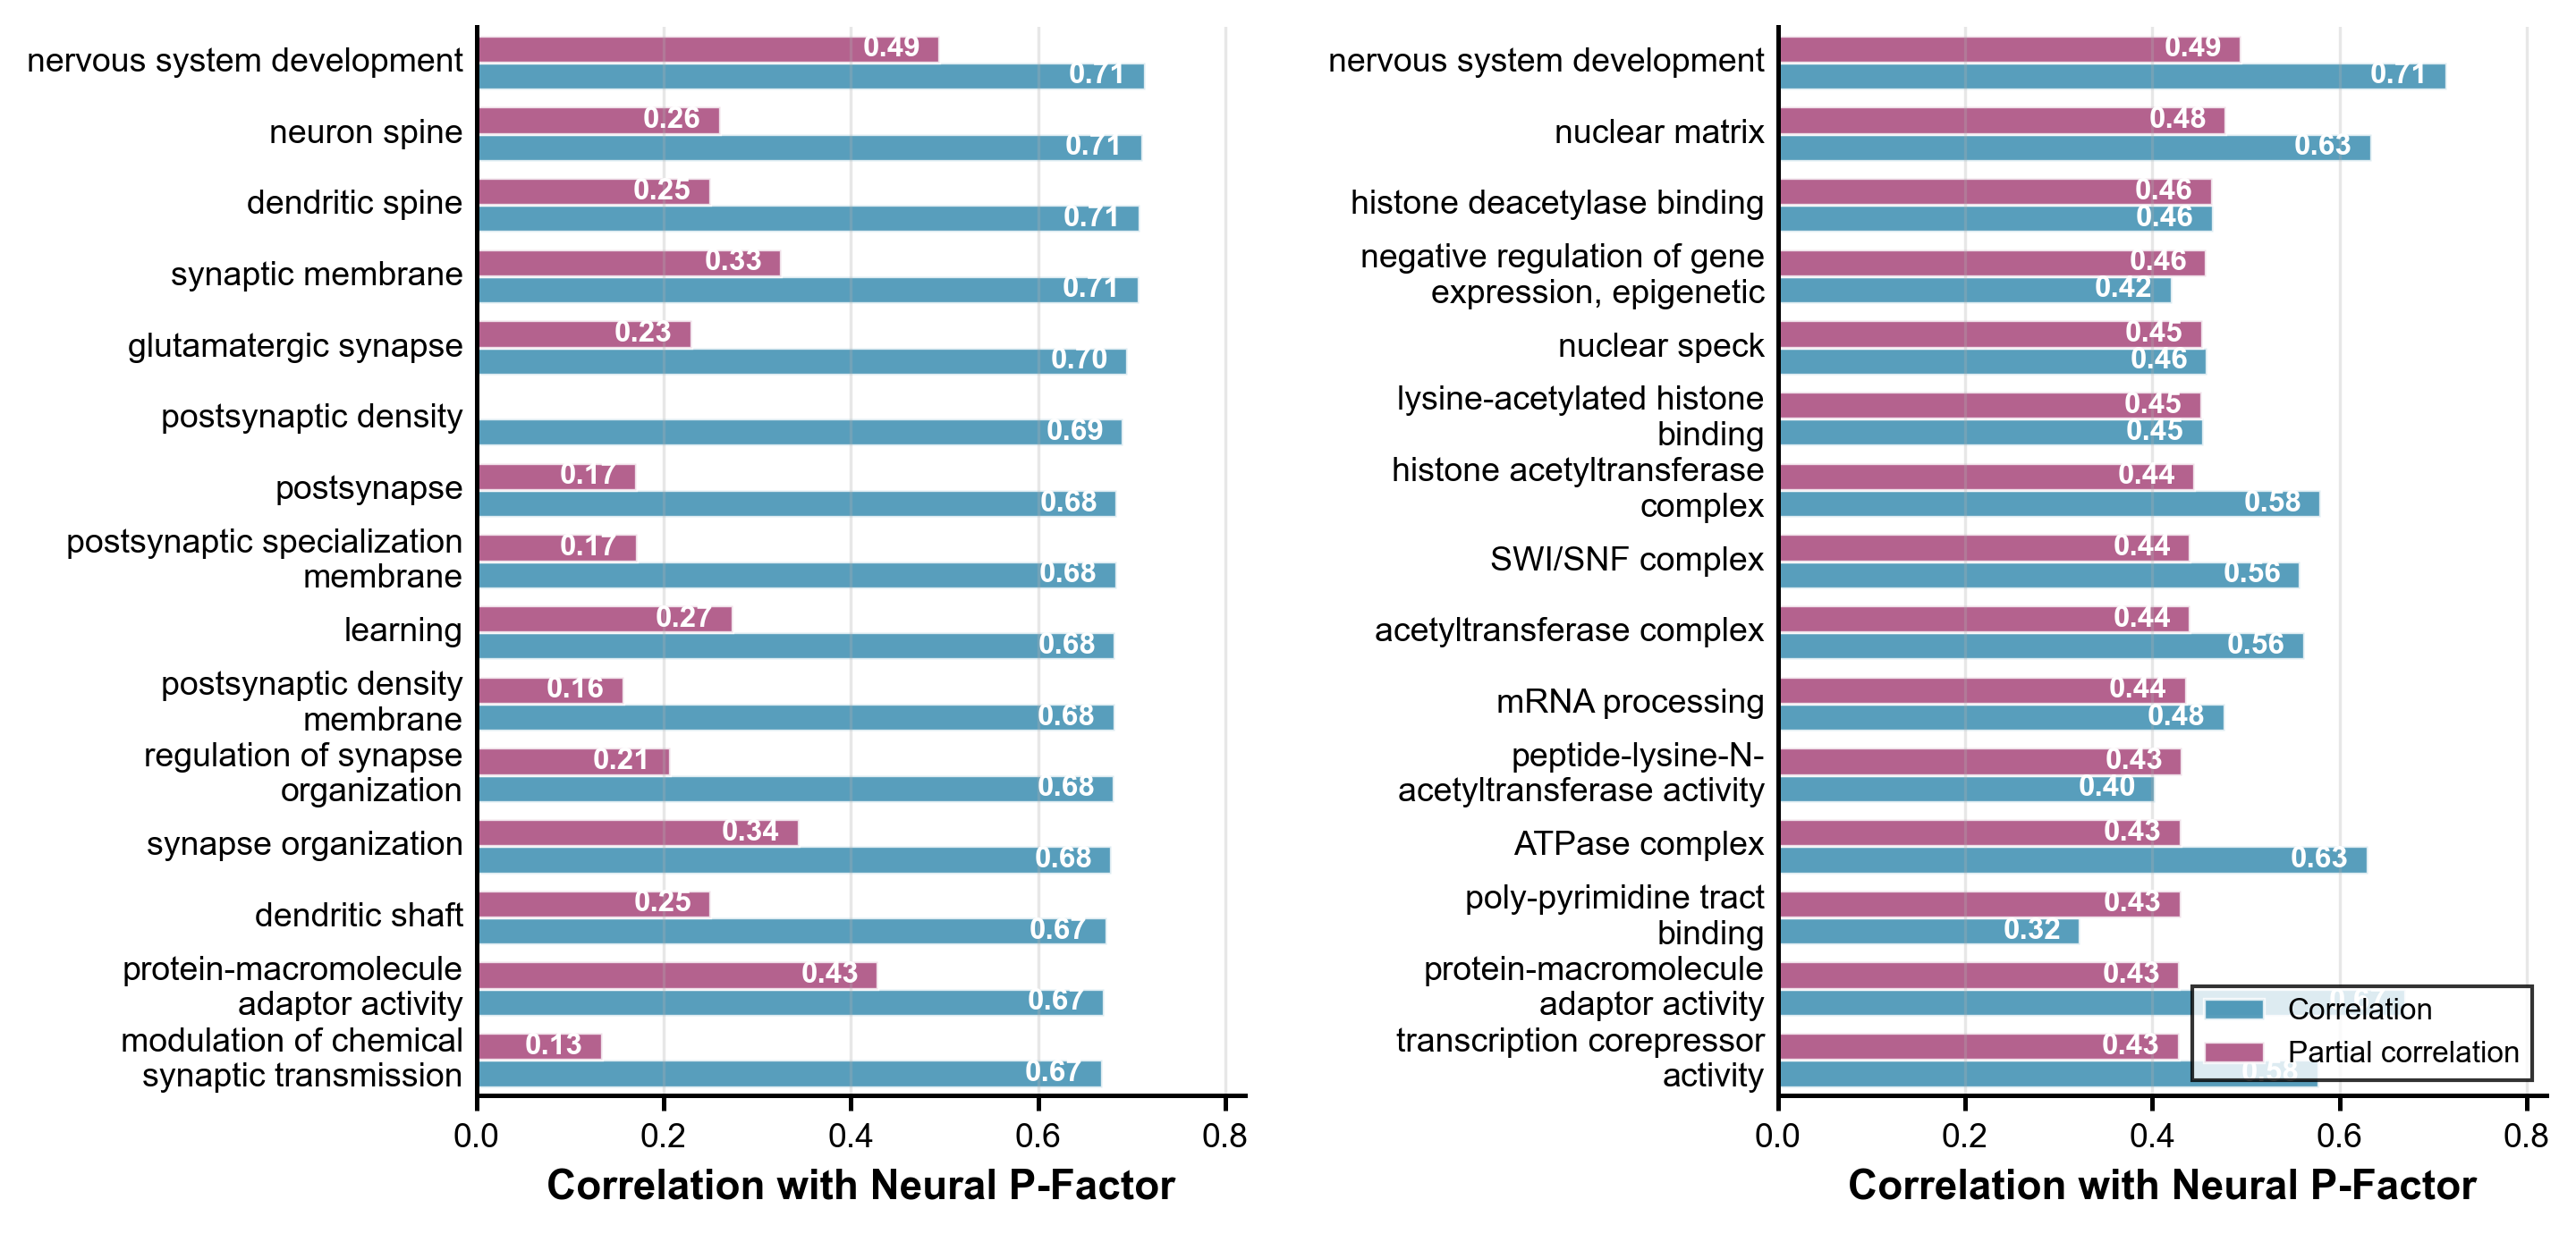

<Figure size 1920x1440 with 0 Axes>

In [15]:
# Call the function with the existing data
plot_go_correlation_analysis(MouseCT_partial_corr_df, top_n=15)

In [16]:
MouseSTR_GoBias = load_GoBias(GoTermDF, "MouseSTR")
ct_idx = MouseSTR_GoBias.index.values
MouseSTR_GoBias["PC1"] = pc_scores_all["PGC"]["MouseSTR"]["top_gene_enrich"]["Empty"].loc[ct_idx, "PC1"].values
MouseSTR_GoBias["PSD"] = PSD_MouseSTR.loc[ct_idx, "EFFECT"].values
MouseSTR_partial_corr_df = analyze_go_terms_correlation(MouseSTR_GoBias)
MouseSTR_partial_corr_df.head(20)

Loaded 100/6252 GO terms (1.6%)...
Loaded 200/6252 GO terms (3.2%)...

Loaded 400/6252 GO terms (6.4%)...
Loaded 500/6252 GO terms (8.0%)...
Loaded 700/6252 GO terms (11.2%)...
Loaded 900/6252 GO terms (14.4%)...
Loaded 1100/6252 GO terms (17.6%)...
Loaded 1300/6252 GO terms (20.8%)...

Loaded 1400/6252 GO terms (22.4%)...
Loaded 1600/6252 GO terms (25.6%)...
Loaded 1700/6252 GO terms (27.2%)...

Loaded 2100/6252 GO terms (33.6%)...

Loaded 2200/6252 GO terms (35.2%)...
Loaded 2400/6252 GO terms (38.4%)...




Loaded 2500/6252 GO terms (40.0%)...

Loaded 2600/6252 GO terms (41.6%)...

Loaded 2700/6252 GO terms (43.2%)...

Loaded 2900/6252 GO terms (46.4%)...

Loaded 3000/6252 GO terms (48.0%)...

Loaded 3200/6252 GO terms (51.2%)...


Loaded 3300/6252 GO terms (52.8%)...


Loaded 3400/6252 GO terms (54.4%)...


Loaded 3500/6252 GO terms (56.0%)...





Loaded 3600/6252 GO terms (57.6%)...

Loaded 3700/6252 GO terms (59.2%)...




Loaded 3800/6252 GO terms (60.8%)...

Loaded 3900/6252 G

orig_r        orig_p  partial_r     partial_p  \
GO:0014069  0.681795  1.811318e-30   0.000000  2.481835e-30   
GO:0046321  0.439770  1.739798e-11   0.542423  1.292060e-17   
GO:0007026  0.222040  1.105039e-03   0.534506  4.624232e-17   
GO:1903975  0.464169  8.867049e-13   0.529105  1.083006e-16   
GO:0006893  0.174762  1.061087e-02   0.520568  4.031465e-16   
GO:0048671  0.683438  1.160203e-30   0.500351  7.855615e-15   
GO:0031114  0.115456  9.281319e-02   0.496202  1.410968e-14   
GO:0120163  0.200473  3.298321e-03   0.491523  2.705065e-14   
GO:0043001  0.249952  2.285834e-04   0.490004  3.334398e-14   
GO:0008017 -0.151304  2.724881e-02   0.482989  8.646628e-14   
GO:0021952  0.512047  1.237224e-15   0.479537  1.370915e-13   
GO:0043522  0.613790  1.930632e-23   0.476119  2.152943e-13   
GO:0098976  0.651127  4.468057e-27   0.475428  2.357365e-13   
GO:0046030  0.353050  1.198411e-07   0.473801  2.915782e-13   
GO:0048188  0.453871  3.205931e-12   0.473389  3.076450e-13   
GO:0008361 -0.072719  2.907638e-01   0.472542  3.434303e-13   
GO:0042752  0.682993  1.309210e-30   0.469214  5.277298e-13   
GO:0048814  0.731839  5.387135e-37   0.467428  6.633169e-13   
GO:0030275  0.549239  3.497683e-18   0.458649  2.002456e-12   
GO:1905665  0.698581  1.657713e-32   0.456686  2.552638e-12   

                                                       GoName  
GO:0014069                               postsynaptic density  
GO:0046321        positive regulation of fatty acid oxidation  
GO:0007026  negative regulation of microtubule depolymeriz...  
GO:1903975                 regulation of glial cell migration  
GO:0006893                 Golgi to plasma membrane transport  
GO:0048671        negative regulation of collateral sprouting  
GO:0031114         regulation of microtubule depolymerization  
GO:0120163  negative regulation of cold-induced thermogenesis  
GO:0043001         Golgi to plasma membrane protein transport  
GO:0008017                                microtubule binding  
GO:0021952  central nervous system projection neuron axono...  
GO:0043522                      leucine zipper domain binding  
GO:0098976          excitatory chemical synaptic transmission  
GO:0046030        inositol trisphosphate phosphatase activity  
GO:0048188                              Set1C/COMPASS complex  
GO:0008361                            regulation of cell size  
GO:0042752                     regulation of circadian rhythm  
GO:0048814               regulation of dendrite morphogenesis  
GO:0030275                                 LRR domain binding  
GO:1905665  positive regulation of calcium ion import acro...

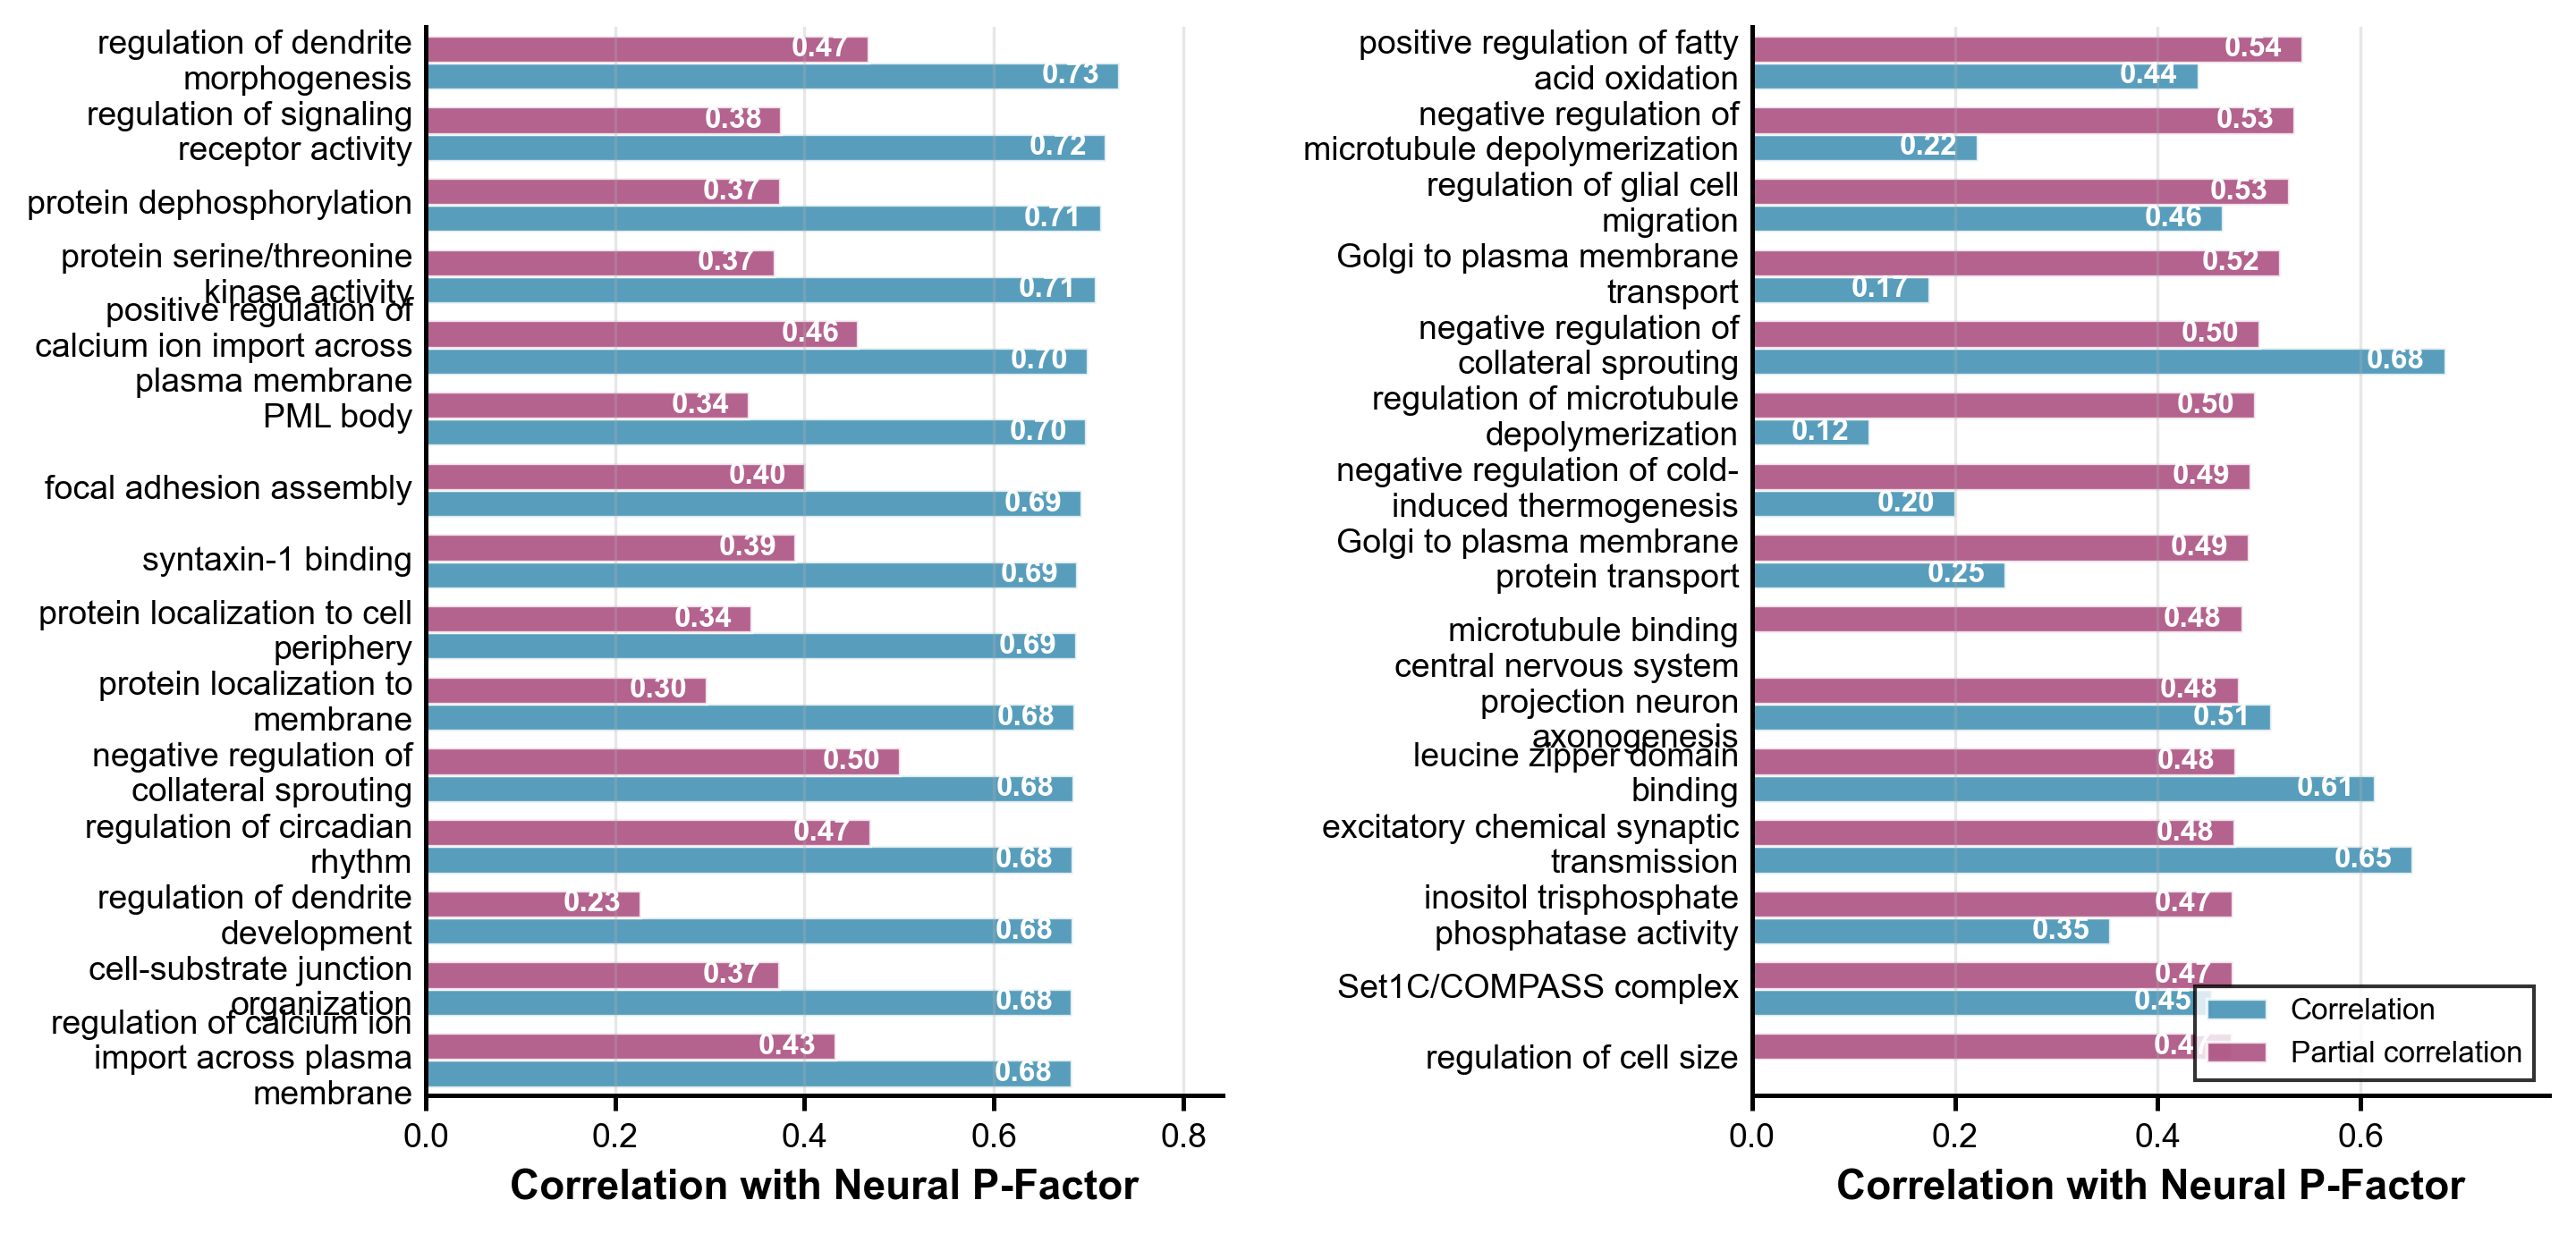

<Figure size 1920x1440 with 0 Axes>

In [17]:
plot_go_correlation_analysis(MouseSTR_partial_corr_df, top_n=15)

### Other PCs

In [18]:
HumanCT_GoCorrDF = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/HumanCT_Go_PC_Loadings.Corr.csv", index_col=0)
MouseCT_GoCorrDF = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseCT_Go_PC_Loadings.Corr.csv", index_col=0)
MouseSTR_GoCorrDF = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseSTR_Go_PC_Loadings.Corr.csv", index_col=0)

In [19]:
HumanCT_GoCorrDF.sort_values("Bias_R_PC2_spearman", ascending=False).head(10)

GoID                                             GoName  \
24    GO:0003713                 transcription coactivator activity   
5979  GO:0098727                         maintenance of cell number   
2830  GO:0019827                   stem cell population maintenance   
372   GO:0042826                        histone deacetylase binding   
2906  GO:2000045  regulation of G1/S transition of mitotic cell ...   
4562  GO:0090101  negative regulation of transmembrane receptor ...   
1931  GO:2000036     regulation of stem cell population maintenance   
376   GO:0031490                              chromatin DNA binding   
4397  GO:2000736            regulation of stem cell differentiation   
453   GO:0001222                  transcription corepressor binding   

      Bias_R_PC1  Bias_R_PC1_p  Bias_R_PC1_spearman  Bias_R_PC1_spearman_p  \
24     -0.204002  1.011404e-05            -0.184160           6.966571e-05   
5979   -0.182453  8.150651e-05            -0.110846           1.727266e-02   
2830   -0.195050  2.474537e-05            -0.121659           8.929013e-03   
372    -0.193006  3.018765e-05            -0.086272           6.420250e-02   
2906   -0.093499  4.480675e-02            -0.013367           7.747026e-01   
4562   -0.139613  2.662748e-03            -0.089617           5.450419e-02   
1931   -0.296724  8.000092e-11            -0.268407           4.767933e-09   
376     0.011470  8.059851e-01            -0.001807           9.691436e-01   
4397   -0.169258  2.615904e-04             0.011121           8.117733e-01   
453    -0.144536  1.863011e-03            -0.130053           5.163438e-03   

      Bias_R_PC2  Bias_R_PC2_p  Bias_R_PC2_spearman  Bias_R_PC2_spearman_p  \
24      0.652297  3.263530e-57             0.657744           1.838336e-58   
5979    0.634292  2.921337e-53             0.635017           2.049166e-53   
2830    0.619382  3.509978e-50             0.618575           5.096933e-50   
372     0.609992  2.519356e-48             0.612792           7.151271e-49   
2906    0.597193  6.811271e-46             0.596047           1.111136e-45   
4562    0.580888  5.991228e-43             0.595768           1.251370e-45   
1931    0.582703  2.869674e-43             0.593388           3.431213e-45   
376     0.597248  6.652430e-46             0.592628           4.726095e-45   
4397    0.587527  3.969550e-44             0.591198           8.617023e-45   
453     0.606400  1.244743e-47             0.591098           8.982571e-45   

      ...  Bias_R_PC3_spearman  Bias_R_PC3_spearman_p  Bias_R_PC4  \
24    ...             0.102211               0.028210    0.055744   
5979  ...            -0.029225               0.531364   -0.068704   
2830  ...            -0.045044               0.334548   -0.066134   
372   ...             0.028280               0.544740    0.085780   
2906  ...            -0.095091               0.041273    0.048242   
4562  ...            -0.035115               0.451974    0.060514   
1931  ...             0.130690               0.004947    0.015905   
376   ...            -0.030034               0.520062    0.105584   
4397  ...            -0.078093               0.093986   -0.144382   
453   ...             0.028201               0.545862    0.156585   

      Bias_R_PC4_p  Bias_R_PC4_spearman  Bias_R_PC4_spearman_p  Bias_R_PC5  \
24        0.232259             0.070105               0.132847    0.173066   
5979      0.140786            -0.079839               0.086843    0.213308   
2830      0.156294            -0.080664               0.083620    0.216890   
372       0.065743             0.076655               0.100216    0.144374   
2906      0.301326             0.045024               0.334761    0.051900   
4562      0.194651             0.077702               0.095650    0.161782   
1931      0.733413             0.050247               0.281660    0.117519   
376       0.023380             0.112701               0.015480    0.094974   
4397      0.001884            -0.190825           

In [20]:
MouseCT_GoCorrDF.sort_values("Bias_R_PC2_spearman", ascending=False).head(10)

GoID                                             GoName  \
1443  GO:0000242                            pericentriolar material   
4551  GO:0090178  regulation of establishment of planar polarity...   
3425  GO:0071514                                 genomic imprinting   
5872  GO:0021535                        cell migration in hindbrain   
5133  GO:0048266                        behavioral response to pain   
5954  GO:0048841  regulation of axon extension involved in axon ...   
2928  GO:0043652                       engulfment of apoptotic cell   
3135  GO:0048843  negative regulation of axon extension involved...   
3284  GO:0071539                 protein localization to centrosome   
3014  GO:0019233                         sensory perception of pain   

      Bias_R_PC1   Bias_R_PC1_p  Bias_R_PC1_spearman  Bias_R_PC1_spearman_p  \
1443   -0.128683   4.692797e-21            -0.199584           7.361499e-49   
4551   -0.241664   1.855859e-71            -0.325351          3.283451e-131   
3425   -0.214228   3.439419e-56            -0.270424           1.102791e-89   
5872    0.093493   8.641839e-12            -0.054645           6.754652e-05   
5133   -0.341868  1.569940e-145            -0.365986          4.541768e-168   
5954    0.055389   5.365722e-05            -0.019502           1.552698e-01   
2928   -0.035511   9.644009e-03            -0.080854           3.609144e-09   
3135    0.010540   4.424510e-01            -0.049710           2.895982e-04   
3284   -0.086625   2.549892e-10            -0.140300           9.228045e-25   
3014    0.066921   1.051456e-06            -0.085071           5.296489e-10   

      Bias_R_PC2   Bias_R_PC2_p  Bias_R_PC2_spearman  Bias_R_PC2_spearman_p  \
1443    0.402718  2.490804e-206             0.414986          3.119498e-220   
4551    0.366420  1.712991e-168             0.383265          1.864523e-185   
3425    0.359027  2.311024e-161             0.368408          1.924529e-170   
5872    0.359557  7.219387e-162             0.365885          5.702181e-168   
5133    0.347480  1.337496e-150             0.364442          1.444843e-166   
5954    0.354034  1.182292e-156             0.361608          7.875194e-164   
2928    0.358413  8.856663e-161             0.358588          6.038427e-161   
3135    0.352002  9.235437e-155             0.358279          1.187904e-160   
3284    0.336136  1.844525e-140             0.349680          1.290040e-152   
3014    0.336880  4.108283e-141             0.348464          1.684718e-151   

      ...  Bias_R_PC3_spearman  Bias_R_PC3_spearman_p  Bias_R_PC4  \
1443  ...            -0.096382           1.930684e-12    0.009220   
4551  ...            -0.079427           6.761293e-09    0.004690   
3425  ...            -0.024565           7.341244e-02   -0.066935   
5872  ...            -0.071660           1.710267e-07   -0.046990   
5133  ...            -0.089727           5.704356e-11   -0.109978   
5954  ...            -0.034803           1.118883e-02   -0.050157   
2928  ...            -0.021471           1.176571e-01   -0.106776   
3135  ...            -0.043021           1.711486e-03   -0.057594   
3284  ...            -0.109339           1.337310e-15   -0.006400   
3014  ...             0.044578           1.154735e-03   -0.079364   

      Bias_R_PC4_p  Bias_R_PC4_spearman  Bias_R_PC4_spearman_p  Bias_R_PC5  \
1443  5.016958e-01             0.011748           3.919578e-01    0.034924   
4551  7.325603e-01            -0.001758           8.980763e-01    0.102478   
3425  1.045915e-06            -0.060483           1.028074e-05    0.084790   
5872  6.127954e-04            -0.024754           7.122573e-02    0.095036   
5133  9.127442e-16            -0.113376           1.151301e-16    0.049893   
5954  2.551360e-04            -0.038840           4.637925e-03    0.039714   
2928  6.060648e-15            -0.087513           1.669639e-10    0.042859   
3135  2.667810e-05            -0.051240           1.868826e-04    0.028837   
3284  6.409843e-01          

In [21]:
MouseSTR_GoCorrDF.sort_values("Bias_R_PC2_spearman", ascending=False).head(10)

GoID                                             GoName  \
1259  GO:0022624                       proteasome accessory complex   
2120  GO:0043161  proteasome-mediated ubiquitin-dependent protei...   
1913  GO:0010498              proteasomal protein catabolic process   
1294  GO:0019898                    extrinsic component of membrane   
405   GO:0004707                                MAP kinase activity   
4916  GO:1903052  positive regulation of proteolysis involved in...   
1640  GO:0031312          extrinsic component of organelle membrane   
647   GO:0050321                        tau-protein kinase activity   
3083  GO:0007004                telomere maintenance via telomerase   
1224  GO:0000151                           ubiquitin ligase complex   

      Bias_R_PC1  Bias_R_PC1_p  Bias_R_PC1_spearman  Bias_R_PC1_spearman_p  \
1259   -0.173883      0.011016            -0.086910               0.206468   
2120    0.039477      0.566657             0.055708               0.418583   
1913    0.063585      0.355765             0.069480               0.312840   
1294    0.189109      0.005627             0.226120               0.000888   
405     0.141399      0.039220             0.148764               0.029972   
4916    0.117562      0.086970             0.119593               0.081616   
1640   -0.081794      0.234551            -0.058730               0.393756   
647     0.081190      0.238037             0.080290               0.243299   
3083   -0.033543      0.626402            -0.045384               0.510024   
1224    0.046116      0.503216            -0.018187               0.791860   

      Bias_R_PC2  Bias_R_PC2_p  Bias_R_PC2_spearman  Bias_R_PC2_spearman_p  \
1259    0.468056  5.397695e-13             0.439447           1.806865e-11   
2120    0.444273  1.022322e-11             0.426612           7.872580e-11   
1913    0.420137  1.616368e-10             0.409674           5.005937e-10   
1294    0.416226  2.477427e-10             0.399685           1.421149e-09   
405     0.395968  2.077115e-09             0.393460           2.676325e-09   
4916    0.367272  3.335572e-08             0.392028           3.090037e-09   
1640    0.422280  1.276030e-10             0.385394           5.961013e-09   
647     0.343584  2.713200e-07             0.377839           1.237854e-08   
3083    0.382806  7.672281e-09             0.377526           1.275384e-08   
1224    0.362602  5.111315e-08             0.374553           1.691168e-08   

      ...  Bias_R_PC3_spearman  Bias_R_PC3_spearman_p  Bias_R_PC4  \
1259  ...            -0.084368           2.201039e-01   -0.282803   
2120  ...            -0.154519           2.410719e-02   -0.246950   
1913  ...            -0.184802           6.839379e-03   -0.229939   
1294  ...            -0.126804           6.471565e-02   -0.080995   
405   ...            -0.163387           1.700545e-02   -0.015645   
4916  ...            -0.195821           4.118738e-03   -0.143837   
1640  ...            -0.306195           5.306663e-06   -0.129515   
647   ...            -0.205333           2.601704e-03   -0.183241   
3083  ...            -0.351615           1.358864e-07   -0.062310   
1224  ...            -0.256203           1.565410e-04   -0.247356   

      Bias_R_PC4_p  Bias_R_PC4_spearman  Bias_R_PC4_spearman_p  Bias_R_PC5  \
1259      0.000028            -0.263636               0.000099    0.093643   
2120      0.000273            -0.249477               0.000235    0.106429   
1913      0.000721            -0.232422               0.000628    0.121919   
1294      0.239170            -0.081555               0.235926    0.094961   
405       0.820421            -0.071037               0.302092    0.203575   
4916      0.035922            -0.148365               0.030420    0.039488   
1640      0.059155            -0.112443               0.101718    0.219335   
647       0.007333            -0.179301               0.008723    0.255211   
3083      0.365510            -0.061316           

# Compare with Rare Coding Bias

In [22]:
HumanCT_ASD = pd.read_csv("/home/jw3514/Work/CellType_Psy/CellTypeBias_VIP/results/QuantileNorm/ASD_All_bias_addP.csv", index_col=0)
HumanCT_SCZ = pd.read_csv("/home/jw3514/Work/CellType_Psy/CellTypeBias_VIP/results/QuantileNorm/SCZ_bias_addP.csv", index_col=0)     
HumanCT_DDD = pd.read_csv("/home/jw3514/Work/CellType_Psy/CellTypeBias_VIP/results/QuantileNorm/DDD_297_bias_addP.csv", index_col=0)

In [44]:
def plot_combined_correlation_matrix(raw_corr_matrix, partial_corr_matrix, vars, title):
    """
    Plot a combined correlation matrix showing raw correlations in upper triangle
    and partial correlations in lower triangle.
    
    Args:
        raw_corr_matrix (pd.DataFrame): Raw correlation matrix
        partial_corr_matrix (pd.DataFrame): Partial correlation matrix 
        vars (list): Variable names for axis labels
    """
    import matplotlib.patches as patches
    from matplotlib.colors import LinearSegmentedColormap
    
    n_vars = len(vars)
    
    # Combine the matrices
    combined_matrix = np.zeros((n_vars, n_vars))
    # Fill upper triangle with raw correlations
    combined_matrix[np.triu_indices(n_vars)] = raw_corr_matrix.values[np.triu_indices(n_vars)]
    # Fill lower triangle with partial correlations
    combined_matrix[np.tril_indices(n_vars)] = partial_corr_matrix.values[np.tril_indices(n_vars)]
    
    # Create figure with a slightly larger size and higher DPI for better quality
    fig, ax = plt.subplots(figsize=(12, 11), dpi=150)

    # Create custom colormap with white at center and more vibrant colors
    cmap = sns.diverging_palette(220, 20, as_cmap=True, center="light")

    # Create mask for diagonal elements
    mask = np.eye(len(combined_matrix), dtype=bool)

    # Plot heatmap with enhanced styling
    heatmap = sns.heatmap(combined_matrix,
                         annot=True,
                         fmt='.2f',
                         cmap=cmap,
                         vmin=-1, vmax=1, 
                         center=0,
                         square=True,
                         xticklabels=vars,
                         yticklabels=vars,
                         annot_kws={"size": 16, "weight": "bold"},
                         cbar_kws={"shrink": 0.8, 
                                  "label": "Correlation Coefficient",
                                  "aspect": 30,
                                  "pad": 0.02},
                         mask=mask)

    # Enhance tick labels
    plt.xticks(fontsize=25, rotation=45, ha='right', fontweight='bold')
    plt.yticks(fontsize=25, rotation=0, fontweight='bold')

    # Add stylized frames for triangles
    raw_triangle = patches.Polygon([(0, 0), (n_vars, 0), (n_vars, n_vars)],
                                 fill=False, 
                                 edgecolor='navy',
                                 linewidth=10,
                                 alpha=0.7,
                                 transform=ax.transData)
    ax.add_patch(raw_triangle)

    partial_triangle = patches.Polygon([(0, 0), (0, n_vars), (n_vars, n_vars)],
                                     fill=False,
                                     edgecolor='darkgreen',
                                     linewidth=10, 
                                     alpha=0.7,
                                     transform=ax.transData)
    ax.add_patch(partial_triangle)

    # Create more stylized legend
    legend_elements = [
        patches.Patch(facecolor='navy', edgecolor='navy', 
                     alpha=0.7, linewidth=3, 
                     label='Original Correlations'),
        patches.Patch(facecolor='darkgreen', edgecolor='darkgreen',
                     alpha=0.7, linewidth=3,
                     label='Partial Correlations\n(controlling for other variables)')
    ]

    # Position legend better
    ax.legend(handles=legend_elements, 
             loc='upper center',
             bbox_to_anchor=(0.5, -0.15),
             fontsize=20,
             frameon=True,
             ncol=2,
             framealpha=0.9,
             edgecolor='gray')

    # Add title with enhanced styling
    plt.title(title, 
             fontsize=22,
             fontweight='bold',
             pad=30,
             fontfamily='sans-serif')

    # Add subtle grid
    ax.grid(False)

    # Adjust layout
    plt.tight_layout()

    plt.show()

In [24]:
HumanCT_LOEUF_Spec = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/HumanCT_LOEUF_Spec.csv", index_col=0)
HumanCT_LOEUF_Spec.head(2)

EFFECT  Rank Class                   Supercluster Subtype  \
403  1.079592     1  NEUR                       Splatter     NaN   
229  1.060843     2  NEUR  Eccentric medium spiny neuron  MSN-D1   

    Neurotransmitter                                  Top three regions  \
403             GABA  Cerebral cortex: 45.6%, Amygdala: 33.5%, Hypot...   
229             GABA  Amygdala: 56.1%, Basal forebrain: 28.8%, Cereb...   

                                 Top three dissections  Number of cells  \
403  Human AON: 25.7%, Human CoA: 18.1%, Human Pir:...           2608.0   
229  Human CEN: 21.7%, Human CMN: 17.8%, Human Cla:...           1857.0   

                          Neuropeptide auto-annotation  
403  CCK CHGB CORT NAMPT NUCB NXPH PENK SCG TAC VGF...  
229  CCK CHGA CHGB NAMPT NUCB NXPH PDYN PENK SCG TA...

In [25]:
GoTermDF[GoTermDF['GoName'].str.contains('histone', case=False, na=False)]

GoName  Ngenes
GoID                                                                
GO:0032454                 histone H3K9 demethylase activity      14
GO:0042393                                   histone binding     248
GO:0035064                        methylated histone binding      77
GO:1990226                 histone methyltransferase binding      16
GO:0042826                       histone deacetylase binding     123
GO:0032452                      histone demethylase activity      30
GO:0042800           histone H3K4 methyltransferase activity      19
GO:0043997          histone H4K12 acetyltransferase activity      12
GO:0010485             histone H4 acetyltransferase activity      22
GO:0004402                histone acetyltransferase activity      41
GO:0070577                 lysine-acetylated histone binding      24
GO:0004407                      histone deacetylase activity      21
GO:0035173                           histone kinase activity      20
GO:0042054                histone methyltransferase activity      66
GO:0046974           histone H3K9 methyltransferase activity      13
GO:0010484             histone H3 acetyltransferase activity      14
GO:0043995           histone H4K5 acetyltransferase activity      11
GO:0043996           histone H4K8 acetyltransferase activity      11
GO:0035035                 histone acetyltransferase binding      24
GO:0046975          histone H3K36 methyltransferase activity      13
GO:0140713                        histone chaperone activity      12
GO:0140938             histone H3 methyltransferase activity      41
GO:0140939             histone H4 methyltransferase activity      16
GO:0035267            NuA4 histone acetyltransferase complex      31
GO:0035097                 histone methyltransferase complex      63
GO:0000118                       histone deacetylase complex      82
GO:0000123                 histone acetyltransferase complex      94
GO:1902562              H4 histone acetyltransferase complex      45
GO:0008334                    histone mRNA metabolic process      20
GO:0016573                               histone acetylation      83
GO:0051568                         histone H3-K4 methylation      28
GO:0043966                            histone H3 acetylation      37
GO:0035522    monoubiquitinated histone H2A deubiquitination      28
GO:0035521        monoubiquitinated histone deubiquitination      28
GO:0071044                    histone mRNA catabolic process      11
GO:0043984                        histone H4-K16 acetylation      13
GO:0043981                         histone H4-K5 acetylation      16
GO:0043982                         histone H4-K8 acetylation      16
GO:0051571  positive regulation of histone H3-K4 methylation      16
GO:0016575                             histone deacetylation      29
GO:0031065      positive regulation of histone deacetylation      13
GO:0031062        positive regulation of histone methylation      24
GO:0034968                        histone lysine methylation      49
GO:0035066        positive regulation of histone acetylation      16
GO:0035065                 regulation of histone acetylation      28
GO:0044154                        histone H3-K14 acetylation      11
GO:0031063               regulation of histone deacetylation      26
GO:0043967                            histone H4 acetylation      39
GO:0016570                              histone modification     209
GO:0043968                           histone H2A acetylation      21
GO:0035518                    histone H2A monoubiquitination      11
GO:0031060                 regulation of histone methylation      28
GO:0016574                            histone ubiquitination      19
GO:0033522                        histone H2A ubiquitination      13
GO:0016571                               histone methylation      59
GO:0016578                          histone deubiquitination      36
GO:0010390                        histone monoubiqui

In [45]:
#Go_ID = "GO:0006325" # chromatin organization
Go_ID = "GO:0140938" # histone H3 methyltransferase activity # 
#Go_ID = "GO:0016570" # histone modification
#Go_ID = "GO:0016571" # histone binding
mode = "HumanCT"
file_path = f"/home/jw3514/Work/UNIMED/results/goterms/{mode}/Go_Biases/GoBias.{Go_ID[3:]}.spec.csv"
HunmanCT_CHM_Spec = pd.read_csv(file_path, index_col=0)
HunmanCT_CHM_Spec.head(2)

EFFECT  Rank Class                   Supercluster Subtype  \
406  1.078489     1  NEUR            Amygdala excitatory     NaN   
136  1.076885     2  NEUR  Deep-layer intratelencephalic     NaN   

    Neurotransmitter                                  Top three regions  \
406    VGLUT1 VGLUT2  Amygdala: 50.5%, Cerebral cortex: 46.9%, Hypot...   
136    VGLUT1 VGLUT2  Amygdala: 54.6%, Cerebral cortex: 36.2%, Hypot...   

                                 Top three dissections  Number of cells  \
406  Human Pir: 27.1%, Human A35-A36: 18.8%, Human ...           4858.0   
136  Human CoA: 54.6%, Human AON: 28.3%, Human HTHs...            152.0   

                          Neuropeptide auto-annotation  
406  ADCYAP CART CCK CHGA CHGB NAMPT NUCB NXPH SCG ...  
136  ADCYAP CBLN CCK CHGA CHGB CRH NAMPT NUCB PYY S...

In [46]:
# Get values
# Create dataframe with human cell type values
HumanCT_Pfactor = pc_scores_all["PGC"]["HumanCT"]["top_gene_enrich"]["Empty"] 
human_ct_df = pd.DataFrame({
    'P_Factor': HumanCT_Pfactor.sort_index()["PC1"],
    'ASD': HumanCT_ASD.sort_index()["EFFECT"],
    'SCZ': HumanCT_SCZ.sort_index()["EFFECT"], 
    'DDD': HumanCT_DDD.sort_index()["EFFECT"],
    'PSD': PSD_HumanCT.sort_index()["EFFECT"],
    'LOEUF': HumanCT_LOEUF_Spec.sort_index()["EFFECT"],
    'H3M': HunmanCT_CHM_Spec.sort_index()["EFFECT"]
}, index=HumanCT_Pfactor.sort_index().index)


In [47]:
def compute_partial_corr(df):
    """
    Compute partial correlations between all pairs of variables,
    controlling for all other variables in the dataset.
    """
    n = df.shape[1]
    corr_matrix = np.eye(n)
    p_value_matrix = np.eye(n)
    
    for i in range(n):
        for j in range(i + 1, n):
            var1 = df.iloc[:, i]
            var2 = df.iloc[:, j]
            
            # Control variables: all other columns except i and j
            control_vars = df.drop(df.columns[[i, j]], axis=1)
            
            # Add constant for intercept
            control_vars_with_const = sm.add_constant(control_vars)
            
            # Regress each variable on control variables
            try:
                model1 = sm.OLS(var1, control_vars_with_const).fit()
                model2 = sm.OLS(var2, control_vars_with_const).fit()
                
                resid1 = model1.resid
                resid2 = model2.resid
                
                # Partial correlation = correlation of residuals
                r, p_value = stats.spearmanr(resid1, resid2)
                corr_matrix[i, j] = corr_matrix[j, i] = r
                p_value_matrix[i, j] = p_value_matrix[j, i] = p_value
                
            except Exception as e:
                print(f"Error computing correlation between {df.columns[i]} and {df.columns[j]}: {e}")
                corr_matrix[i, j] = corr_matrix[j, i] = np.nan
                p_value_matrix[i, j] = p_value_matrix[j, i] = np.nan
    
    corr_df = pd.DataFrame(corr_matrix, columns=df.columns, index=df.columns)
    p_value_df = pd.DataFrame(p_value_matrix, columns=df.columns, index=df.columns)
    
    return corr_df, p_value_df

# Alternative implementation using matrix operations (more efficient)
def compute_partial_corr_matrix(df):
    """
    More efficient implementation using matrix operations.
    Returns both partial correlation matrix and p-value matrix using Spearman correlation.
    """
    # Use Spearman correlation instead of Pearson
    corr_matrix = df.corr(method='spearman')
    
    try:
        precision_matrix = np.linalg.inv(corr_matrix)
        
        # Partial correlations from precision matrix
        partial_corr = np.zeros_like(precision_matrix)
        for i in range(len(precision_matrix)):
            for j in range(len(precision_matrix)):
                if i != j:
                    partial_corr[i, j] = -precision_matrix[i, j] / np.sqrt(
                        precision_matrix[i, i] * precision_matrix[j, j]
                    )
                else:
                    partial_corr[i, j] = 1.0
        
        # Compute p-values for partial correlations
        n = len(df)
        p_value_matrix = np.ones_like(partial_corr)
        
        for i in range(len(partial_corr)):
            for j in range(len(partial_corr)):
                if i != j:
                    r = partial_corr[i, j]
                    # Number of control variables = total variables - 2
                    df_adjusted = n - len(df.columns) + 2 - 2
                    if df_adjusted > 0 and abs(r) < 1:
                        t_stat = r * np.sqrt(df_adjusted / (1 - r**2))
                        p_value_matrix[i, j] = 2 * (1 - stats.t.cdf(abs(t_stat), df_adjusted))
                    else:
                        p_value_matrix[i, j] = np.nan
                else:
                    p_value_matrix[i, j] = 0.0
        
        partial_corr_df = pd.DataFrame(partial_corr, columns=df.columns, index=df.columns)
        p_value_df = pd.DataFrame(p_value_matrix, columns=df.columns, index=df.columns)
        
        return partial_corr_df, p_value_df
    
    except np.linalg.LinAlgError:
        print("Matrix is singular, using regression-based approach")
        partial_corr_df, p_value_df = compute_partial_corr(df)
        return partial_corr_df, p_value_df

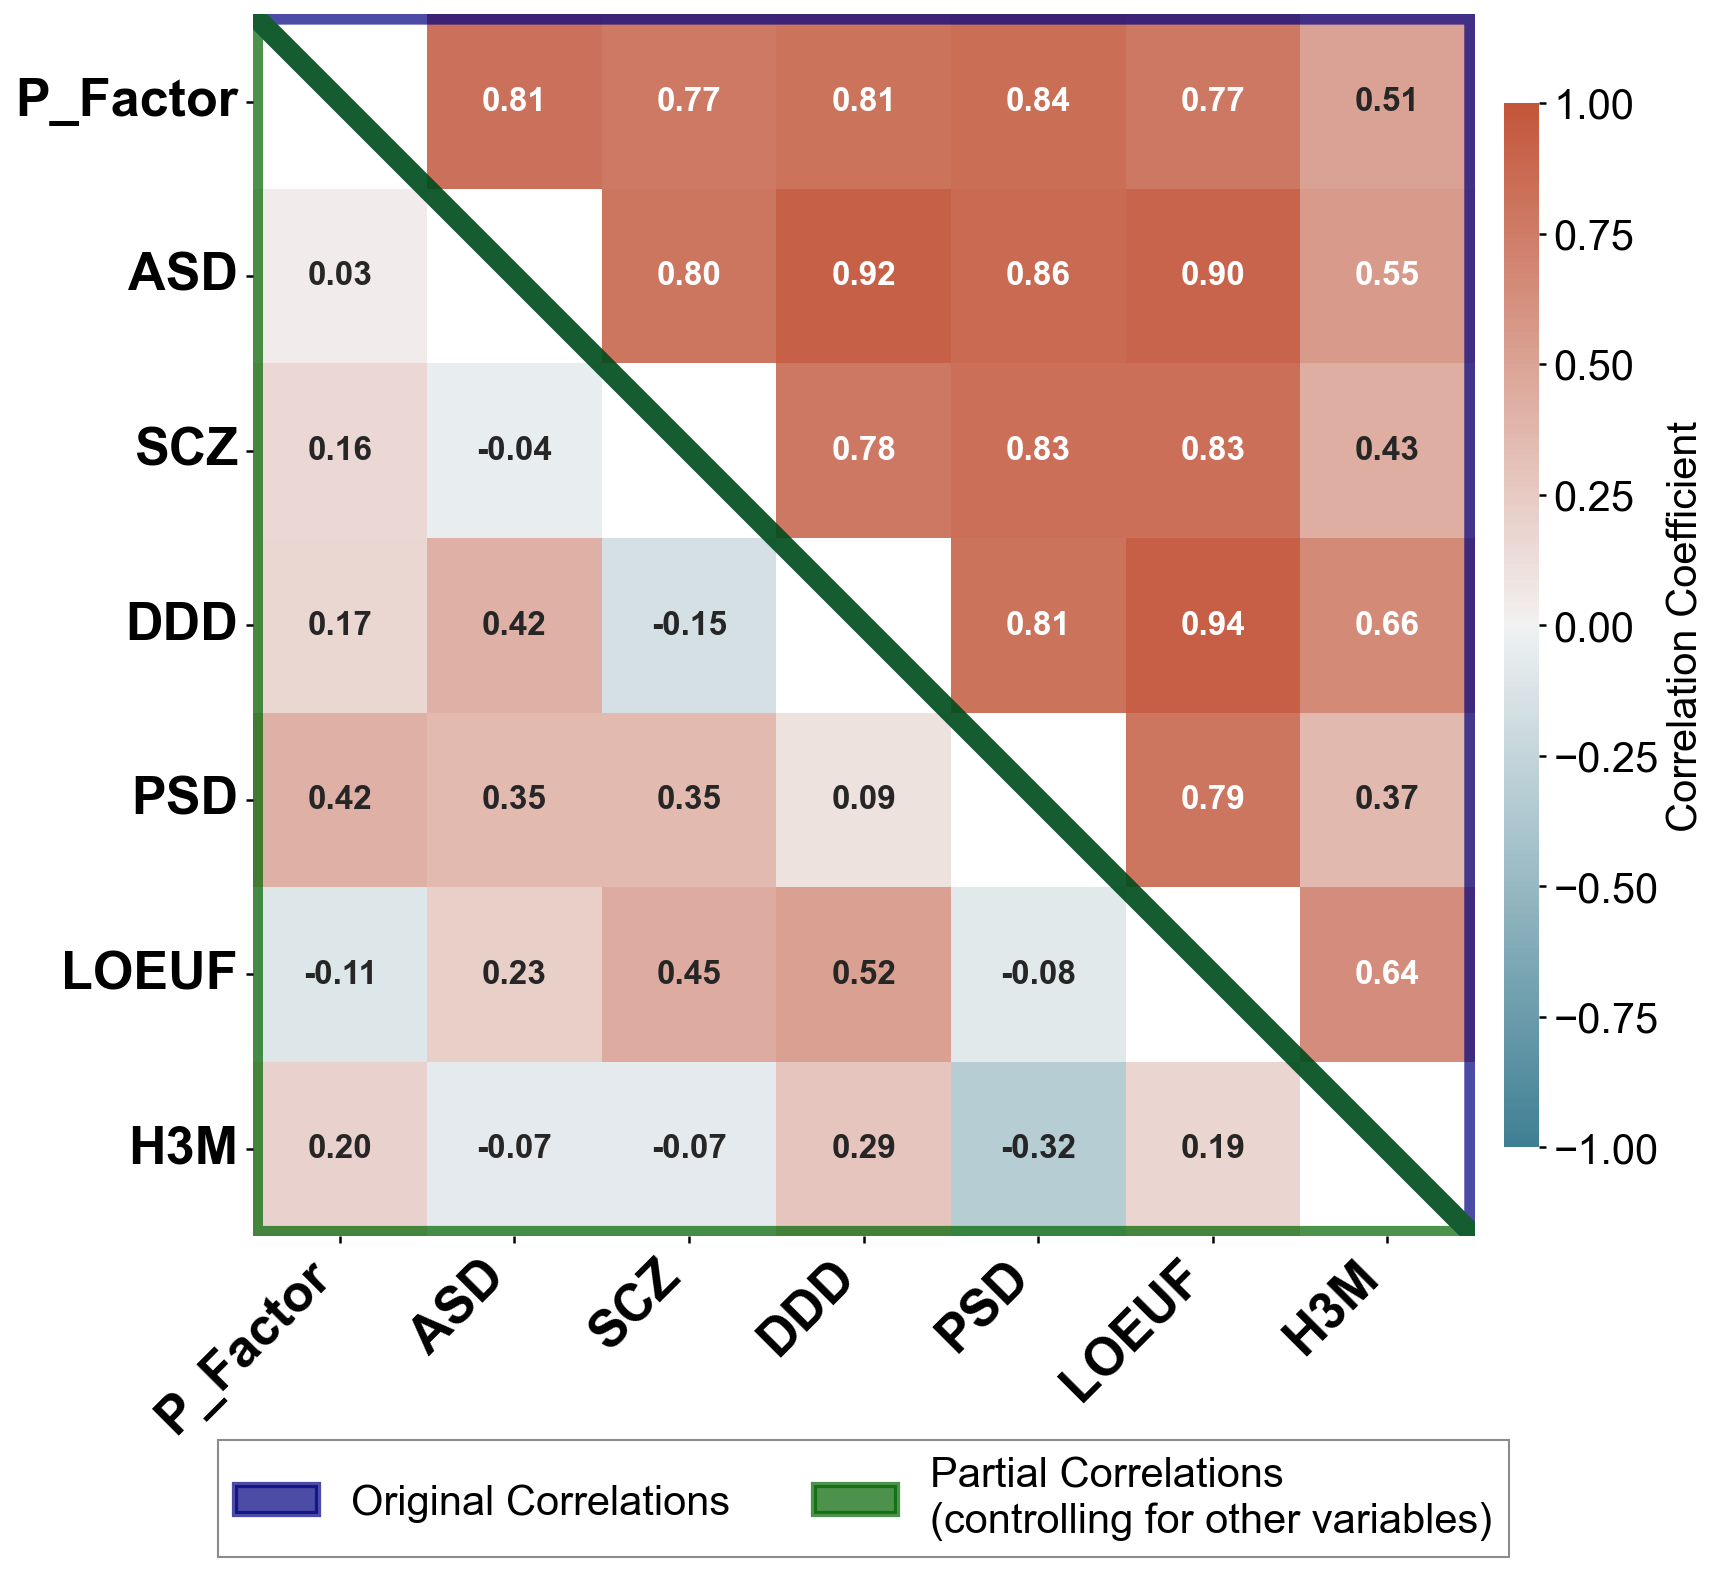

In [48]:
humanct_raw_corr_matrix = human_ct_df.corr(method="spearman")
humanct_partial_corr_matrix, humanct_p_matrix = compute_partial_corr_matrix(human_ct_df)
plot_combined_correlation_matrix(humanct_raw_corr_matrix, humanct_partial_corr_matrix, humanct_partial_corr_matrix.index.values,
 "")

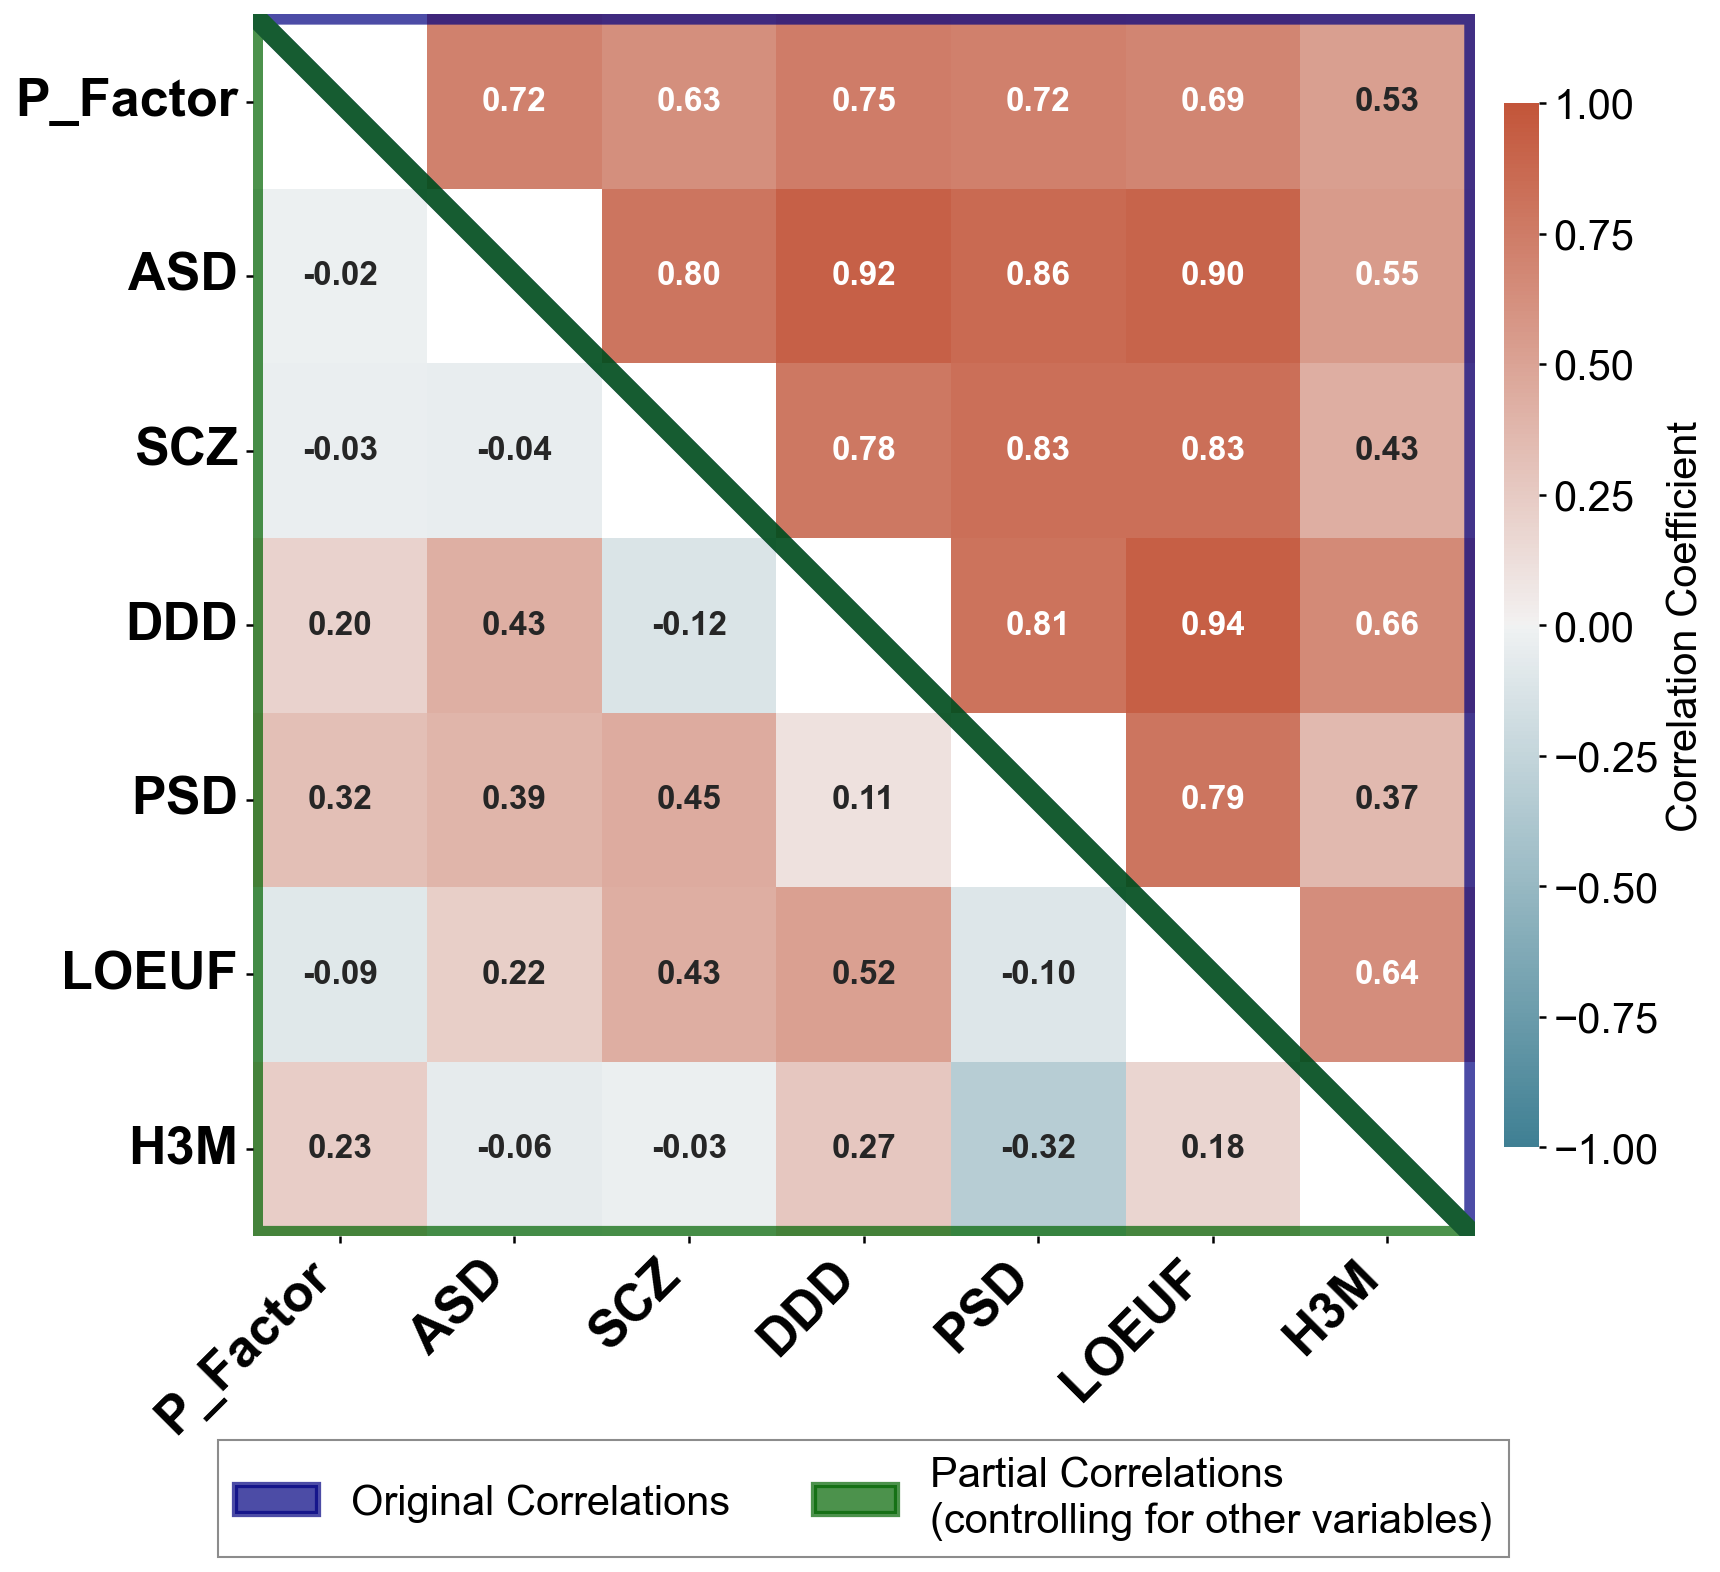

In [49]:
HumanCT_Pfactor = pc_scores_all["PGC"]["HumanCT"]["top_gene_enrich"]["SynapseTopRare"] 
human_ct_df = pd.DataFrame({
    'P_Factor': HumanCT_Pfactor.sort_index()["PC1"],
    'ASD': HumanCT_ASD.sort_index()["EFFECT"],
    'SCZ': HumanCT_SCZ.sort_index()["EFFECT"], 
    'DDD': HumanCT_DDD.sort_index()["EFFECT"],
    'PSD': PSD_HumanCT.sort_index()["EFFECT"],
    'LOEUF': HumanCT_LOEUF_Spec.sort_index()["EFFECT"],
    'H3M': HunmanCT_CHM_Spec.sort_index()["EFFECT"]
}, index=HumanCT_Pfactor.sort_index().index)
humanct_raw_corr_matrix = human_ct_df.corr(method="spearman")
humanct_partial_corr_matrix, humanct_p_matrix = compute_partial_corr_matrix(human_ct_df)
plot_combined_correlation_matrix(humanct_raw_corr_matrix, humanct_partial_corr_matrix, humanct_partial_corr_matrix.index.values,
 "")

In [40]:
pc_scores_all["PGC"]["HumanCT"]["top_gene_enrich"].keys()

dict_keys(['Empty', 'Synase', 'SynapseTopRare'])

In [41]:
MouseCT_LOEUF_Spec = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseCT_LOEUF_Spec.csv", index_col=0)
MouseCT_ASD = pd.read_csv("/home/jw3514/Work/CircuitsV2/results/AdultMouseBrainSC/ASD_All_bias_addP.csv.gz", index_col=0)
MouseCT_SCZ = pd.read_csv("/home/jw3514/Work/CircuitsV2/results/AdultMouseBrainSC/SCZ_bias_addP.csv.gz", index_col=0)
MouseCT_DDD = pd.read_csv("/home/jw3514/Work/CircuitsV2/results/AdultMouseBrainSC/DDD_297_bias_addP.csv.gz", index_col=0)

In [29]:
#Go_ID = "GO:0006325" # chromatin organization
Go_ID = "GO:0140938" # histone H3 methyltransferase activity
mode = "MouseCT"
file_path = f"/home/jw3514/Work/UNIMED/results/goterms/{mode}/Go_Biases/GoBias.{Go_ID[3:]}.spec.csv"
MouseCT_CHM_Spec = pd.read_csv(file_path, index_col=0)
MouseCT_CHM_Spec.head(2)

EFFECT  Rank   class_id_label  \
ct_idx                                                          
1507 PVR Six3 Sox3 Gaba_1     1.123279     1  11 CNU-HYa GABA   
0164 L2/3 IT PIR-ENTl Glut_7  1.116476     2    01 IT-ET Glut   

                                   CCF_broad.freq  \
ct_idx                                              
1507 PVR Six3 Sox3 Gaba_1        HY:0.66,PAL:0.29   
0164 L2/3 IT PIR-ENTl Glut_7  CTXsp:0.51,OLF:0.45   

                                               CCF_acronym.freq  v3.size  \
ct_idx                                                                     
1507 PVR Six3 Sox3 Gaba_1     MPO:0.28,MS:0.27,AVPV:0.22,HY:0.1    170.0   
0164 L2/3 IT PIR-ENTl Glut_7          PIR:0.4,EPd:0.34,EPv:0.12    126.0   

                              v2.size  
ct_idx                                 
1507 PVR Six3 Sox3 Gaba_1        93.0  
0164 L2/3 IT PIR-ENTl Glut_7    635.0

In [42]:
# Get values
# Create dataframe with mouse cell type values
MouseCT_Pfactor = pc_scores_all["PGC"]["MouseCT"]["top_gene_enrich"]["Empty"] 
mouse_ct_df = pd.DataFrame({
    'P_Factor': MouseCT_Pfactor.sort_index()["PC1"],
    'ASD': MouseCT_ASD.sort_index()["EFFECT"],
    'SCZ': MouseCT_SCZ.sort_index()["EFFECT"], 
    'DDD': MouseCT_DDD.sort_index()["EFFECT"],
    'PSD': PSD_MouseCT.sort_index()["EFFECT"],
    'LOEUF': MouseCT_LOEUF_Spec.sort_index()["EFFECT"],
    'H3M': MouseCT_CHM_Spec.sort_index()["EFFECT"]

}, index=MouseCT_Pfactor.sort_index().index)

NameError: name 'MouseCT_CHM_Spec' is not defined

In [43]:
mousect_raw_corr_matrix = mouse_ct_df.corr(method="spearman")
mousect_partial_corr_matrix, mousect_p_matrix = compute_partial_corr_matrix(mouse_ct_df)
plot_combined_correlation_matrix(mousect_raw_corr_matrix, mousect_partial_corr_matrix, mousect_partial_corr_matrix.index.values,
 "Raw vs. Partial Correlation of Mouse CellType Biases")

NameError: name 'mouse_ct_df' is not defined

In [233]:
MouseSTR_LOEUF_Spec = pd.read_csv("/home/jw3514/Work/UNIMED/results/goterms/MouseSTR_LOEUF_Spec.csv", index_col=0)
#MouseSTR_ASD = pd.read_csv("/home/jw3514/Work/ASD_Circuits_CellType/results/STR_ISH/ASD_All_bias_addP_sibling.csv", index_col=0)
MouseSTR_ASD = pd.read_csv("/home/jw3514/Work/ASD_Circuits_CellType/dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.FDR.csv", index_col=0)
MouseSTR_ASD["Region"] = MouseSTR_ASD["REGION"].str.replace("Amygdalar", "Amygdala")

MouseSTR_SCZ = pd.read_csv("/home/jw3514/Work/ASD_Circuits_CellType/results/STR_ISH/SCZ_bias_addP_sibling.csv", index_col=0)
MouseSTR_DDD = pd.read_csv("/home/jw3514/Work/ASD_Circuits_CellType/results/STR_ISH/DDD_293_bias_addP_sibling.csv", index_col=0)

In [234]:
MouseSTR_ASD

EFFECT     REGION  Rank  \
STR                                                                             
Nucleus_accumbens                                   0.504843   Striatum     1   
Orbital_area_lateral_part                           0.502925  Isocortex     2   
Prelimbic_area                                      0.497309  Isocortex     3   
Primary_somatosensory_area_lower_limb               0.467266  Isocortex     4   
Orbital_area_ventrolateral_part                     0.464161  Isocortex     5   
...                                                      ...        ...   ...   
Superior_olivary_complex                           -0.618249       Pons   209   
Pontine_reticular_nucleus_caudal_part              -0.645366       Pons   210   
Paragigantocellular_reticular_nucleus_lateral_part -0.653438    Medulla   211   
Facial_motor_nucleus                               -0.668507    Medulla   212   
Medullary_reticular_nucleus_ventral_part           -0.685920    Medulla   213   

                                                    Pvalue   Z_Match  \
STR                                                                    
Nucleus_accumbens                                   0.0004  3.785510   
Orbital_area_lateral_part                           0.0001  3.877800   
Prelimbic_area                                      0.0006  3.683304   
Primary_somatosensory_area_lower_limb               0.0002  3.681423   
Orbital_area_ventrolateral_part                     0.0008  3.419775   
...                                                    ...       ...   
Superior_olivary_complex                            1.0000 -4.712826   
Pontine_reticular_nucleus_caudal_part               1.0000 -4.823332   
Paragigantocellular_reticular_nucleus_lateral_part  1.0000 -5.007018   
Facial_motor_nucleus                                1.0000 -5.045908   
Medullary_reticular_nucleus_ventral_part            1.0000 -5.244755   

                                                     qvalues     Region  
STR                                                                      
Nucleus_accumbens                                   0.025557   Striatum  
Orbital_area_lateral_part                           0.021298  Isocortex  
Prelimbic_area                                      0.025557  Isocortex  
Primary_somatosensory_area_lower_limb               0.021298  Isocortex  
Orbital_area_ventrolateral_part                     0.027106  Isocortex  
...                                                      ...        ...  
Superior_olivary_complex                            1.000000       Pons  
Pontine_reticular_nucleus_caudal_part               1.000000       Pons  
Paragigantocellular_reticular_nucleus_lateral_part  1.000000    Medulla  
Facial_motor_nucleus                                1.000000    Medulla  
Medullary_reticular_nucleus_ventral_part            1.000000    Medulla  

[213 rows x 7 columns]

In [211]:
Go_ID = "GO:0140938" # histone H3 methyltransferase activity
mode = "MouseSTR"
file_path = f"/home/jw3514/Work/UNIMED/results/goterms/{mode}/Go_Biases/GoBias.{Go_ID[3:]}.spec.csv"
MouseSTR_CHM_Spec = pd.read_csv(file_path, index_col=0)
MouseSTR_CHM_Spec.head(2)

EFFECT  Rank        Region
Structure                                                 
Dorsal_premammillary_nucleus  0.443096     1  Hypothalamus
Dentate_gyrus                 0.430654     2   Hippocampus

In [212]:
# Get values
# Create dataframe with mouse cell type values
MouseSTR_Pfactor = pc_scores_all["PGC"]["MouseSTR"]["top_gene_enrich"]["Empty"] 
mouse_str_df = pd.DataFrame({
    'P_Factor': MouseSTR_Pfactor.sort_index()["PC1"],
    'ASD': MouseSTR_ASD.sort_index()["EFFECT"],
    'SCZ': MouseSTR_SCZ.sort_index()["EFFECT"], 
    'DDD': MouseSTR_DDD.sort_index()["EFFECT"],
    'PSD': PSD_MouseSTR.sort_index()["EFFECT"],
    'LOEUF': MouseSTR_LOEUF_Spec.sort_index()["EFFECT"],
    'H3M': MouseSTR_CHM_Spec.sort_index()["EFFECT"]

}, index=MouseSTR_Pfactor.sort_index().index)

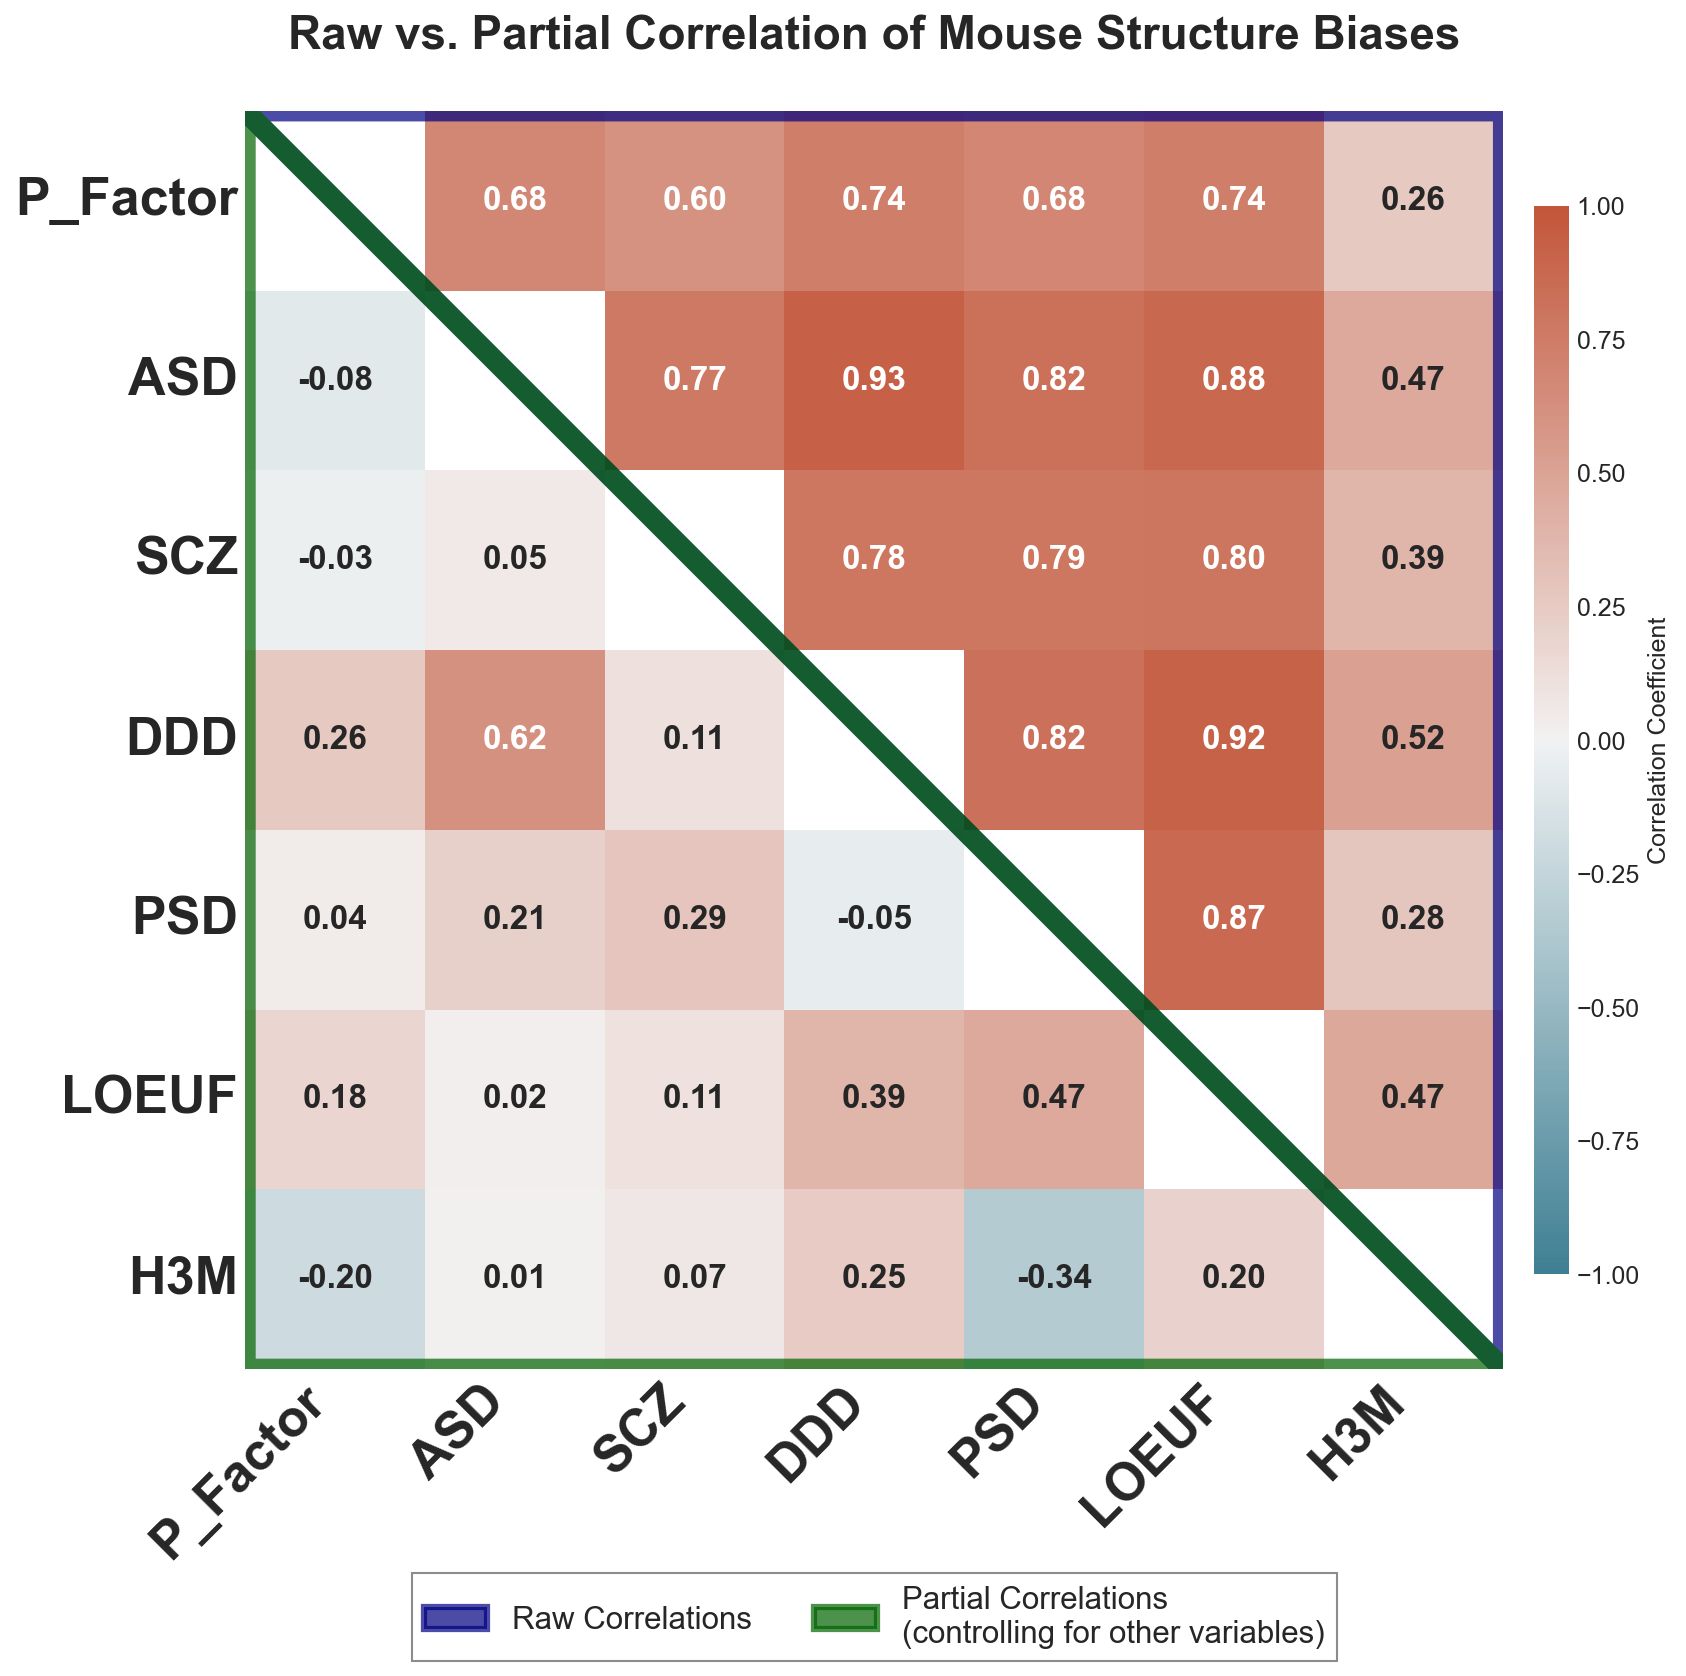

In [213]:
mouse_str_raw_corr_matrix = mouse_str_df.corr(method="spearman")
mouse_str_partial_corr_matrix, mouse_str_p_matrix = compute_partial_corr_matrix(mouse_str_df)
plot_combined_correlation_matrix(mouse_str_raw_corr_matrix, mouse_str_partial_corr_matrix, mouse_str_partial_corr_matrix.index.values,
 "Raw vs. Partial Correlation of Mouse Structure Biases")

In [214]:
mouse_str_partial_corr_matrix

P_Factor       ASD       SCZ       DDD       PSD     LOEUF       H3M
P_Factor  1.000000 -0.079939 -0.026237  0.259759  0.044939  0.184566 -0.195821
ASD      -0.079939  1.000000  0.049512  0.615255  0.214444  0.019439  0.011937
SCZ      -0.026237  0.049512  1.000000  0.109403  0.287105  0.108809  0.069206
DDD       0.259759  0.615255  0.109403  1.000000 -0.048168  0.390474  0.246934
PSD       0.044939  0.214444  0.287105 -0.048168  1.000000  0.467402 -0.341355
LOEUF     0.184566  0.019439  0.108809  0.390474  0.467402  1.000000  0.197334
H3M      -0.195821  0.011937  0.069206  0.246934 -0.341355  0.197334  1.000000

In [215]:
def corr_to_igraph(humanct_partial_corr_matrix, mousect_partial_corr_matrix, mouse_str_partial_corr_matrix):
    """Load correlation matrix as fully connected weighted igraph"""
    # Create fully connected graph
    n = len(humanct_partial_corr_matrix)
    G = ig.Graph.Full(n, directed=False, loops=False)
    
    # Add vertex names
    G.vs["name"] = humanct_partial_corr_matrix.index.tolist()
    
    # Add correlation weights to edges
    humanct_PR = []
    mousect_PR = []
    mouse_str_PR = []
    for edge in G.es:
        i, j = edge.source, edge.target
        humanct_PR.append(humanct_partial_corr_matrix.iloc[i, j])
        mousect_PR.append(mousect_partial_corr_matrix.iloc[i, j])
        mouse_str_PR.append(mouse_str_partial_corr_matrix.iloc[i, j])
    
    DescriptionMap = {"ASD": "Disorder", "SCZ": "Disorder", "DDD": "Disorder", "P_Factor": "Disorder", 
    "PSD": "Molecular Function", "LOEUF": "Molecular Function", "H3M": "Molecular Function"}
    for node in G.vs:
        #node["name"] = node.index
        node["description"] = DescriptionMap[node["name"]]

    G.es["humanct_PR"] = humanct_PR
    G.es["mousect_PR"] = mousect_PR
    G.es["mouse_str_PR"] = mouse_str_PR
    return G

In [216]:
g = corr_to_igraph(humanct_partial_corr_matrix, mousect_partial_corr_matrix, mouse_str_partial_corr_matrix)
g.write_gml("network.gml")

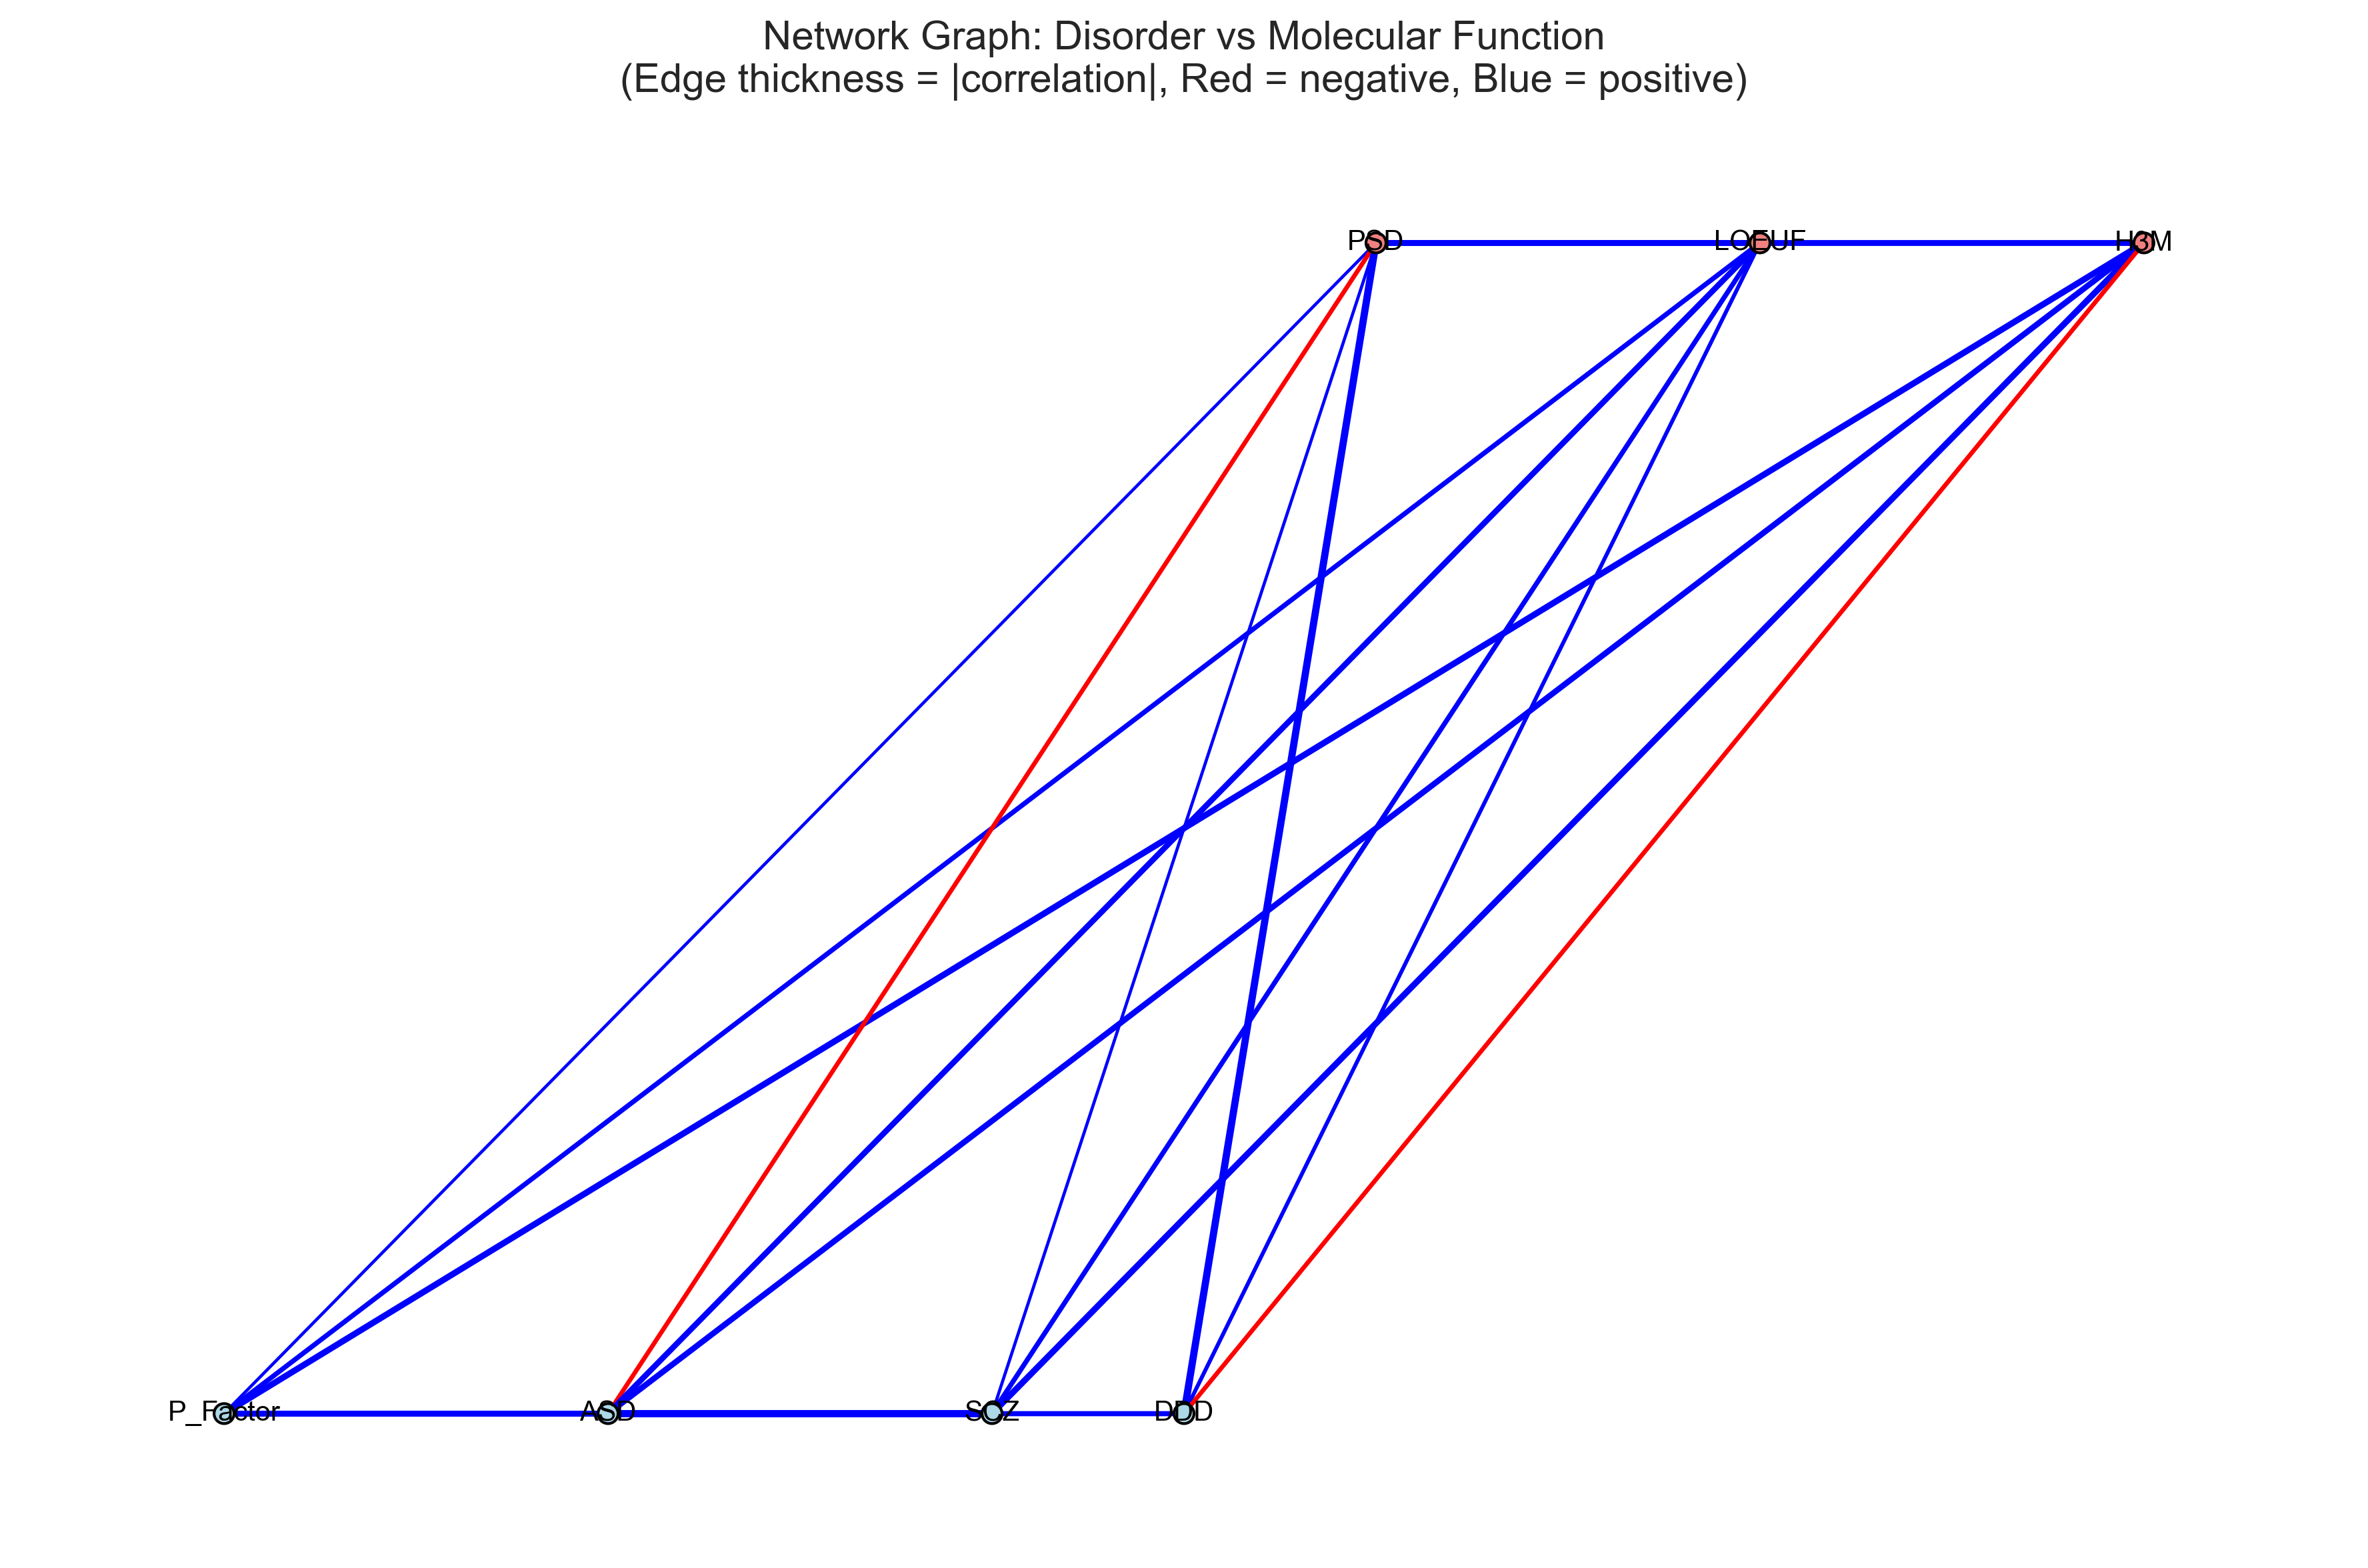

Edges with |humanct_PR| > 0.2:
P_Factor - PSD: 0.417
ASD - DDD: 0.422
ASD - PSD: 0.354
ASD - LOEUF: 0.226
SCZ - PSD: 0.352
SCZ - LOEUF: 0.449
DDD - LOEUF: 0.522
DDD - H3M: 0.285
PSD - H3M: -0.322


In [217]:
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Get vertex positions
layout = g.layout("rt")  # Reingold-Tilford layout for hierarchical structure

# Separate nodes by type
disorder_nodes = [v for v in g.vs if v["description"] == "Disorder"]
molecular_nodes = [v for v in g.vs if v["description"] == "Molecular Function"]

# Adjust layout to put Disorder nodes at bottom, Molecular Function at top
for v in g.vs:
    if v["description"] == "Disorder":
        layout[v.index][1] = 0  # Bottom
    else:
        layout[v.index][1] = 1  # Top

# Filter edges by weight threshold
edge_threshold = 0.2
filtered_edges = [e for e in g.es if abs(e["humanct_PR"]) > edge_threshold]

# Create edge properties only for filtered edges
edge_widths = [abs(e["humanct_PR"]) * 5 for e in filtered_edges]
edge_colors = ["red" if e["humanct_PR"] < 0 else "blue" for e in filtered_edges]

# Create edge list for plotting (only show filtered edges)
edges_to_plot = [(e.source, e.target) for e in filtered_edges]

# Plot the graph
ig.plot(g, 
        target=ax,
        layout=layout,
        vertex_size=30,
        vertex_color=["lightblue" if v["description"] == "Disorder" else "lightcoral" for v in g.vs],
        vertex_label=g.vs["name"],
        vertex_label_size=10,
        edge_width=edge_widths,
        edge_color=edge_colors,
        edge_list=edges_to_plot,
        bbox=(800, 600))

ax.set_title("Network Graph: Disorder vs Molecular Function\n(Edge thickness = |correlation|, Red = negative, Blue = positive)")
plt.tight_layout()
plt.show()

# Print edge information
print("Edges with |humanct_PR| > 0.2:")
for e in g.es:
    if abs(e["humanct_PR"]) > 0.2:
        source_name = g.vs[e.source]["name"]
        target_name = g.vs[e.target]["name"]
        print(f"{source_name} - {target_name}: {e['humanct_PR']:.3f}")

# Compare individual strutcture/cell type Diff 

In [236]:
def merge_bias_datasets(dataset1, dataset2, suffixes=('_1', '_2')):
    """
    Merge two structure bias datasets for comparison.
    
    Parameters:
    -----------
    dataset1 : DataFrame
        First dataset with 'Rank', 'EFFECT', and 'Region' columns
    dataset2 : DataFrame
        Second dataset with 'Rank' and 'EFFECT' columns
    suffixes : tuple of str
        Suffixes to append to column names for each dataset
    
    Returns:
    --------
    merged_data : DataFrame
        Merged dataset with comparison metrics for both Rank and EFFECT
    """
    # Select all relevant columns
    dataset1_cols = ['Rank', 'EFFECT', 'Region']
    dataset2_cols = ['Rank', 'EFFECT']
    
    # Merge the datasets on structure names for comparison
    merged_data = pd.merge(dataset1[dataset1_cols], dataset2[dataset2_cols], 
                          left_index=True, right_index=True, suffixes=suffixes)

    # Calculate differences for both Rank and EFFECT metrics
    merged_data[f'DIFF_Rank'] = merged_data[f'Rank{suffixes[0]}'] - merged_data[f'Rank{suffixes[1]}']
    merged_data[f'ABS_DIFF_Rank'] = np.abs(merged_data[f'DIFF_Rank'])
    
    merged_data[f'DIFF_EFFECT'] = merged_data[f'EFFECT{suffixes[0]}'] - merged_data[f'EFFECT{suffixes[1]}']
    merged_data[f'ABS_DIFF_EFFECT'] = np.abs(merged_data[f'DIFF_EFFECT'])

    # Sort by absolute difference in EFFECT by default
    merged_data = merged_data.sort_values('ABS_DIFF_EFFECT', ascending=False)
    
    return merged_data



In [237]:
MouseSTR_Pfactor['Rank'] = MouseSTR_Pfactor['PC1'].rank(ascending=False)
MouseSTR_Pfactor['EFFECT'] = MouseSTR_Pfactor['PC1']
MouseSTR_merged_data = merge_bias_datasets(MouseSTR_ASD, MouseSTR_Pfactor, suffixes=('_ASD', '_Pfactor'))

/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


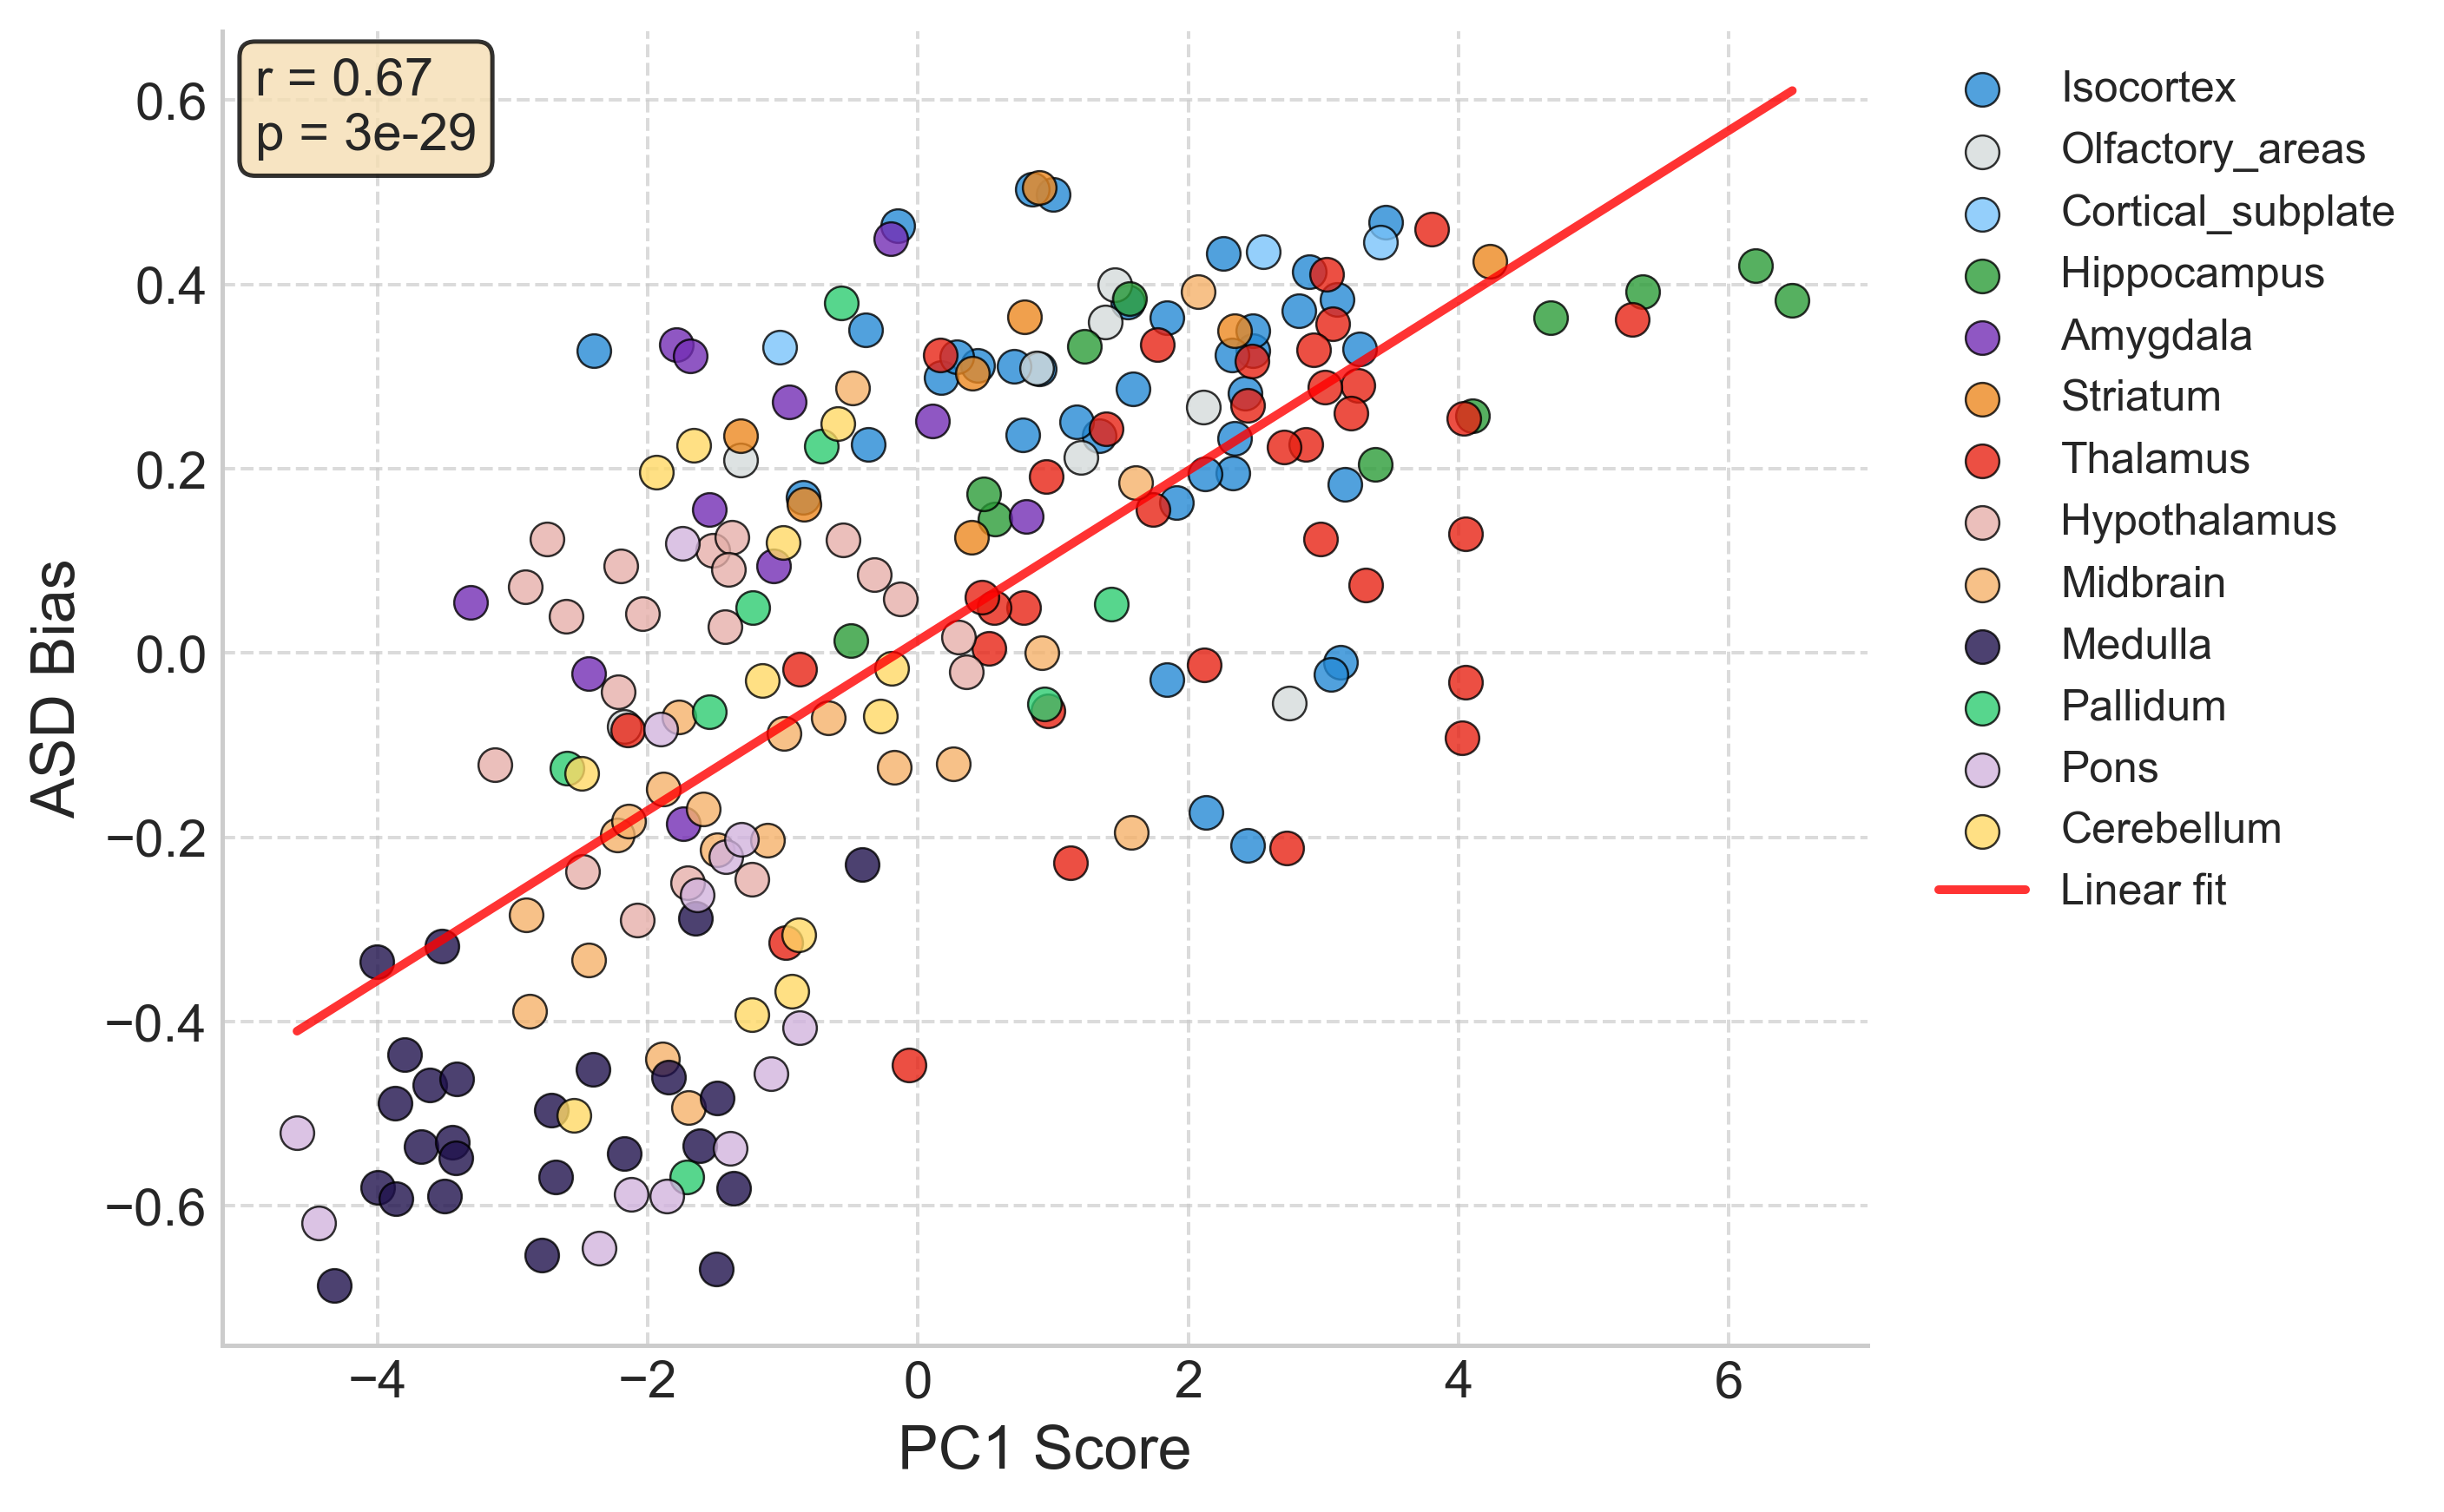

In [256]:
def plot_structure_bias_comparison(merged_data, metric='EFFECT', suffixes=('_1', '_2'), xlabel="", ylabel=""):
    """
    Plot structure bias comparison between two datasets.
    
    Parameters:
    -----------
    merged_data : DataFrame
        Merged structure bias data from merge_bias_datasets function
    metric : str
        Which metric to plot ('Rank' or 'EFFECT')
    suffixes : tuple of str
        Suffixes used in the merged data column names
    """
    REGIONS_seq = ['Isocortex','Olfactory_areas', 'Cortical_subplate', 
                    'Hippocampus','Amygdala','Striatum', 
                    "Thalamus", "Hypothalamus", "Midbrain", 
                    "Medulla", "Pallidum", "Pons", 
                    "Cerebellum"]
    REG_COR_Dic = dict(zip(REGIONS_seq, ["#268ad5", "#D5DBDB", "#7ac3fa", 
                                        "#2c9d39", "#742eb5", "#ed8921", 
                                        "#e82315", "#E6B0AA", "#f6b26b",  
                                        "#20124d", "#2ECC71", "#D2B4DE", 
                                        "#ffd966", ]))

    plt.style.use('seaborn-v0_8-whitegrid')

    # Use the provided color mapping
    region_color_map = REG_COR_Dic

    # First figure: Scatter plot with region coloring
    fig1, ax1 = plt.subplots(1, 1, dpi=360, figsize=(8, 5), facecolor='none')

    fig1.patch.set_alpha(0)
    ax1.patch.set_alpha(0)

    for region in REGIONS_seq:
        region_data = merged_data[merged_data['Region'] == region]
        if len(region_data) > 0:  # Only plot if there's data for this region
            ax1.scatter(region_data[f'{metric}{suffixes[1]}'], region_data[f'{metric}{suffixes[0]}'], 
                       c=region_color_map[region], s=60, edgecolors='black', linewidth=0.5, 
                       alpha=0.8, label=region)

    # Fit linear regression model
    from sklearn.linear_model import LinearRegression
    from scipy.stats import pearsonr
    
    # Remove any rows with NaN values for the regression
    clean_data = merged_data[[f'{metric}{suffixes[0]}', f'{metric}{suffixes[1]}']].dropna()
    X = clean_data[[f'{metric}{suffixes[1]}']]
    y = clean_data[f'{metric}{suffixes[0]}']
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate residuals and add to merged_data
    y_pred = model.predict(X)
    residuals = y - y_pred
    merged_data.loc[clean_data.index, f'residuals'] = residuals
    
    # Generate points for regression line
    x_range = np.linspace(X.min().values[0], X.max().values[0], 100)
    y_pred_line = model.predict(x_range.reshape(-1, 1))
    ax1.plot(x_range, y_pred_line, 'r-', linewidth=2, alpha=0.8, label='Linear fit')

    # Calculate correlation and p-value
    correlation, p_value = pearsonr(clean_data[f'{metric}{suffixes[0]}'], clean_data[f'{metric}{suffixes[1]}'])

    ax1.set_xlabel(xlabel, fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    #ax1.set_title(title, fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10, bbox_to_anchor=(1.02, 1), loc='upper left')

    # Add text annotation for correlation, p-value, and model statistics
    ax1.text(0.02, 0.98, f'r = {correlation:.2f}\np = {p_value:.0e}', 
             transform=ax1.transAxes, fontsize=12, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()
    
    return merged_data

MouseSTR_merged_data = plot_structure_bias_comparison(MouseSTR_merged_data, suffixes=('_ASD', '_Pfactor'), ylabel="ASD Bias", xlabel="PC1 Score")

In [239]:
MouseSTR_merged_data.head(2)

Rank_ASD  EFFECT_ASD       Region  Rank_Pfactor  \
Field_CA1            20    0.382506  Hippocampus           1.0   
Dentate_gyrus        12    0.420358  Hippocampus           2.0   

               EFFECT_Pfactor  DIFF_Rank  ABS_DIFF_Rank  DIFF_EFFECT  \
Field_CA1            6.471467       19.0           19.0    -6.088961   
Dentate_gyrus        6.198567       10.0           10.0    -5.778209   

               ABS_DIFF_EFFECT  residuals  
Field_CA1             6.088961  -0.227859  
Dentate_gyrus         5.778209  -0.164844

Total structures in top 40 of at least one dataset: 61
Showing top 20 structures with largest differences (from top 40 filter)


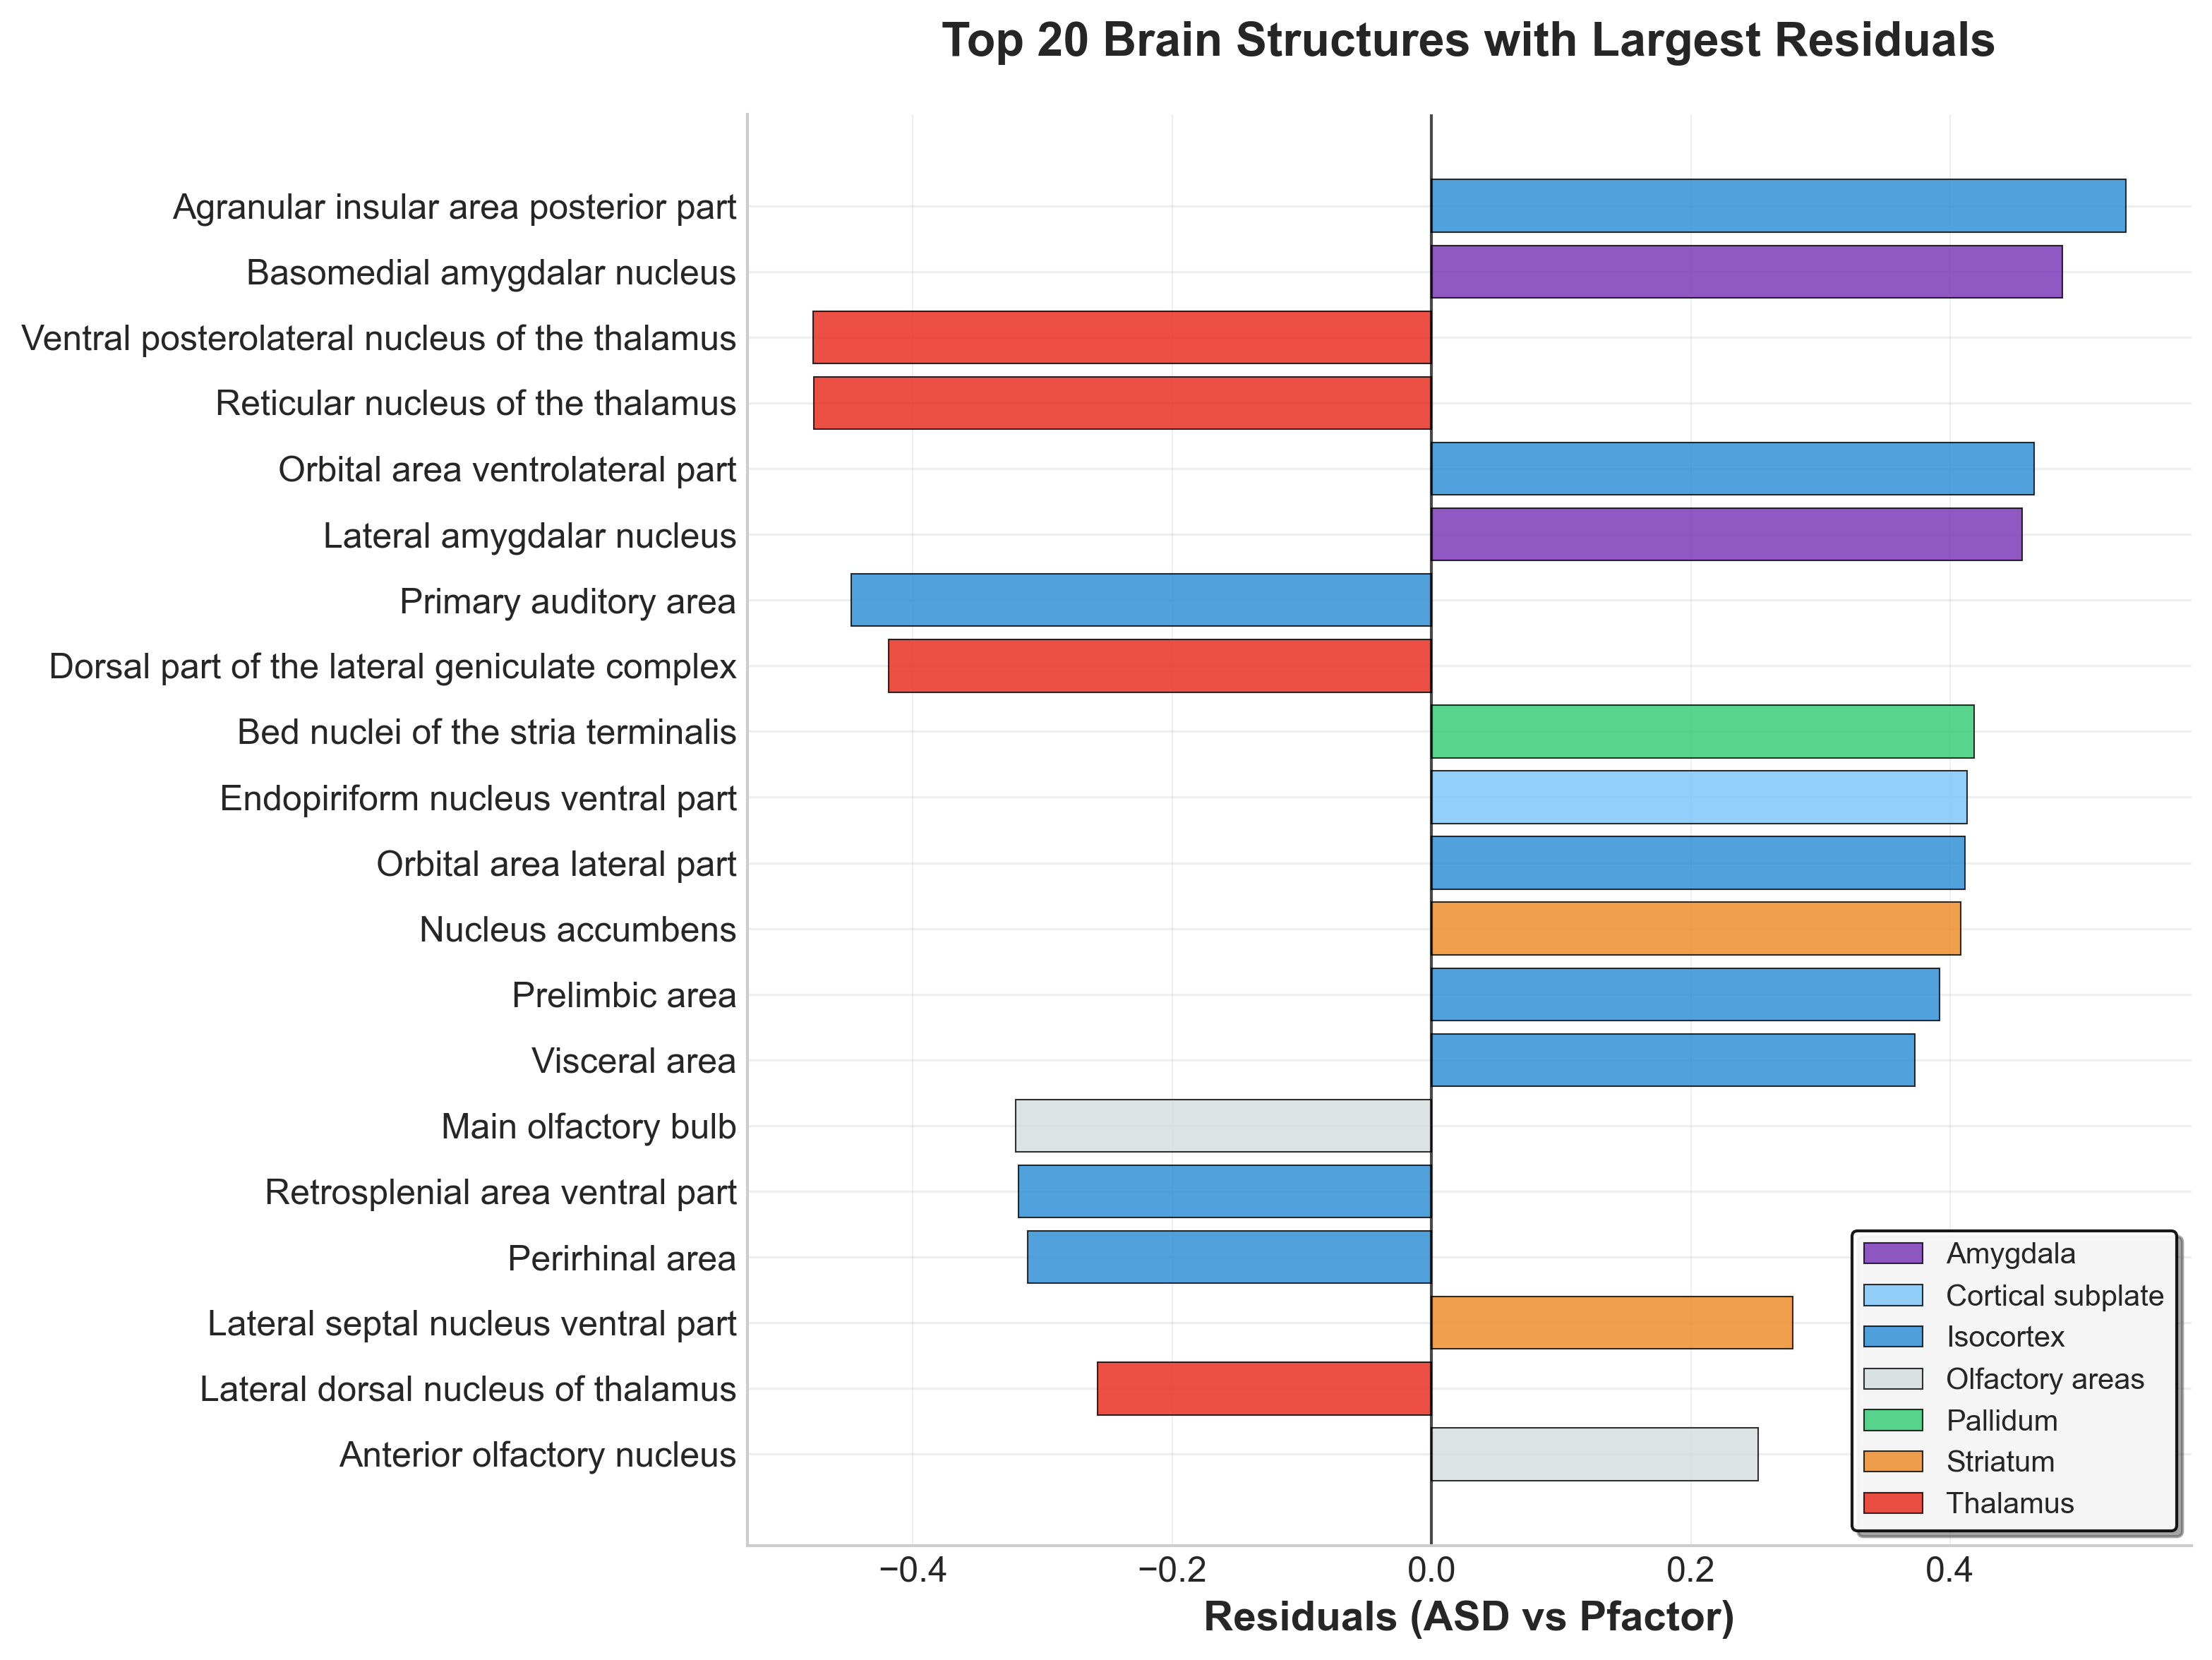

In [249]:
def plot_top_residual_structures(merged_data, top_n=30, top_threshold=40, 
                                name1="ASD", name2="Pfactor", figsize=(10, 8)):
    """
    Plot brain structures with largest residuals from regression analysis.
    
    Parameters:
    -----------
    merged_data : DataFrame
        Merged dataset with residuals and region information
    top_n : int
        Number of top structures to display
    top_threshold : int
        Filter to structures in top N of at least one dataset
    name1, name2 : str
        Names of the two datasets being compared
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    top_diff : DataFrame
        Top structures with largest residuals
    """
    # Filter to only structures that appear in top threshold of at least one dataset
    top_structures = merged_data[(merged_data[f"Rank_{name1}"] <= top_threshold) | 
                                (merged_data[f"Rank_{name2}"] <= top_threshold)]

    print(f"Total structures in top {top_threshold} of at least one dataset: {len(top_structures)}")

    # Sort by absolute difference for top structures only
    top_structures = top_structures.copy()
    top_structures["ABS_DIFF"] = abs(merged_data[f"residuals"])
    top_structures = top_structures.sort_values('ABS_DIFF', ascending=True)

    # Take the top N structures with largest differences from those in top threshold
    top_n = min(top_n, len(top_structures))  # Use min to avoid index errors if fewer structures available
    top_diff = top_structures.tail(top_n)  # Get largest differences

    print(f"Showing top {len(top_diff)} structures with largest differences (from top {top_threshold} filter)")

    # Define regions and colors
    REGIONS_seq = ['Isocortex','Olfactory_areas', 'Cortical_subplate', 
                    'Hippocampus','Amygdala','Striatum', 
                    "Thalamus", "Hypothalamus", "Midbrain", 
                    "Medulla", "Pallidum", "Pons", 
                    "Cerebellum"]
    REG_COR_Dic = dict(zip(REGIONS_seq, ["#268ad5", "#D5DBDB", "#7ac3fa", 
                                        "#2c9d39", "#742eb5", "#ed8921", 
                                        "#e82315", "#E6B0AA", "#f6b26b",  
                                        "#20124d", "#2ECC71", "#D2B4DE", 
                                        "#ffd966", ]))

    # Create publication-quality plot of residuals for top_diff structures
    plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})
    fig, ax = plt.subplots(figsize=figsize, dpi=300)

    # Sort top_diff by residuals for better visualization
    top_diff_sorted = top_diff.sort_values('ABS_DIFF', ascending=True)

    # Create colors based on region
    colors = [REG_COR_Dic.get(region, '#808080') for region in top_diff_sorted['Region']]

    # Create horizontal bar plot with better styling
    bars = ax.barh(range(len(top_diff_sorted)), 
                   top_diff_sorted[f'residuals'], 
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

    # Customize the plot with publication-quality styling
    ax.set_yticks(range(len(top_diff_sorted)))
    ax.set_yticklabels([name.replace('_', ' ') for name in top_diff_sorted.index], 
                       fontsize=12, fontweight='normal')
    ax.set_xlabel(f'Residuals ({name1} vs {name2})', fontsize=14, fontweight='bold')
    ax.set_title(f'Top {len(top_diff)} Brain Structures with Largest Residuals', 
                 fontsize=16, fontweight='bold', pad=20)

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)

    # Add subtle grid
    ax.grid(True, axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Add vertical line at x=0 with better styling
    ax.axvline(x=0, color='black', linestyle='-', alpha=0.7, linewidth=1)

    # Create legend for regions with better styling
    unique_regions = sorted(list(set(top_diff_sorted['Region'])))
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=REG_COR_Dic.get(region, '#808080'), 
                                    alpha=0.8, edgecolor='black', linewidth=0.5) 
                       for region in unique_regions if region in REG_COR_Dic]
    legend_labels = [region.replace('_', ' ') for region in unique_regions if region in REG_COR_Dic]

    if legend_elements:
        ax.legend(legend_elements, legend_labels, loc='lower right', fontsize=10, 
                  frameon=True, fancybox=True, shadow=True, framealpha=0.9)

    # Adjust layout and margins
    plt.tight_layout()
    plt.subplots_adjust(left=0.3)  # Make room for structure names
    plt.show()
    
    return top_diff

# Call the function
top_diff = plot_top_residual_structures(MouseSTR_merged_data, top_n=20, top_threshold=40,
                                       name1="ASD", name2="Pfactor")

In [246]:
def merge_bias_datasets_humanct(dataset1, dataset2, suffixes=('_1', '_2')):
    """
    Merge two structure bias datasets for comparison.
    
    Parameters:
    -----------
    dataset1 : DataFrame
        First dataset with 'Rank', 'EFFECT', and 'Region' columns
    dataset2 : DataFrame
        Second dataset with 'Rank' and 'EFFECT' columns
    suffixes : tuple of str
        Suffixes to append to column names for each dataset
    
    Returns:
    --------
    merged_data : DataFrame
        Merged dataset with comparison metrics for both Rank and EFFECT
    """
    # Select all relevant columns
    dataset1_cols = ['Rank', 'EFFECT', 'Supercluster']
    dataset2_cols = ['Rank', 'EFFECT']
    
    # Merge the datasets on structure names for comparison
    merged_data = pd.merge(dataset1[dataset1_cols], dataset2[dataset2_cols], 
                          left_index=True, right_index=True, suffixes=suffixes)

    # Calculate differences for both Rank and EFFECT metrics
    merged_data[f'DIFF_Rank'] = merged_data[f'Rank{suffixes[0]}'] - merged_data[f'Rank{suffixes[1]}']
    merged_data[f'ABS_DIFF_Rank'] = np.abs(merged_data[f'DIFF_Rank'])
    
    merged_data[f'DIFF_EFFECT'] = merged_data[f'EFFECT{suffixes[0]}'] - merged_data[f'EFFECT{suffixes[1]}']
    merged_data[f'ABS_DIFF_EFFECT'] = np.abs(merged_data[f'DIFF_EFFECT'])

    # Sort by absolute difference in EFFECT by default
    merged_data = merged_data.sort_values('ABS_DIFF_EFFECT', ascending=False)
    
    return merged_data



In [242]:
HumanCT_ASD.head()

EFFECT  Rank Class                   Supercluster  Subtype  \
146  1.231283     1  NEUR  Deep-layer intratelencephalic      NaN   
155  1.226951     2  NEUR            Amygdala excitatory      NaN   
154  1.222027     3  NEUR            Amygdala excitatory      NaN   
403  1.213699     4  NEUR                       Splatter      NaN   
201  1.210879     5  NEUR      Hippocampal dentate gyrus  DG-GRAN   

    Neurotransmitter                                  Top three regions  \
146    VGLUT1 VGLUT2  Amygdala: 65.4%, Cerebral cortex: 33.1%, Hypot...   
155    VGLUT1 VGLUT2  Amygdala: 99.6%, Cerebral cortex: 0.2%, Hippoc...   
154    VGLUT1 VGLUT2  Amygdala: 87.5%, Cerebral cortex: 6.8%, Hippoc...   
403             GABA  Cerebral cortex: 45.6%, Amygdala: 33.5%, Hypot...   
201           VGLUT1  Hippocampus: 99.9%, Midbrain: 0.1%, Thalamus: ...   

                                 Top three dissections  Number of cells  \
146  Human Pir: 22.2%, Human CEN: 19.8%, Human BL: ...           5654.0   
155  Human La: 77.0%, Human BL: 17.2%, Human CEN: 5.2%          11716.0   
154   Human BL: 55.4%, Human La: 20.5%, Human BM: 8.2%           7970.0   
403  Human AON: 25.7%, Human CoA: 18.1%, Human Pir:...           2608.0   
201  Human DGU-CA4Upy: 34.3%, Human DGR-CA4: 34.3%,...          18996.0   

                          Neuropeptide auto-annotation  P-value   Z-score  \
146  ADCYAP CBLN CCK CHGA CHGB NAMPT NUCB SCG UBL V...   0.0001  4.962036   
155  ADCYAP CBLN CCK CHGA CHGB NAMPT NUCB NXPH PYY ...   0.0001  4.944218   
154  CBLN CCK CHGA CHGB NAMPT NUCB NXPH UBL UCN VGF...   0.0001  4.847533   
403  CCK CHGB CORT NAMPT NUCB NXPH PENK SCG TAC VGF...   0.0001  4.890399   
201      CBLN CHGB GRP IGF NAMPT NUCB PDYN UBL proSAAS   0.0001  4.810111   

     EFFECT_adj   q-value     -logP  
146    0.395883  0.001397  4.000043  
155    0.391738  0.001397  4.000043  
154    0.386510  0.001397  4.000043  
403    0.380530  0.001397  4.000043  
201    0.377296  0.001397  4.000043

In [265]:
HumanCT_Pfactor['Rank'] = HumanCT_Pfactor['PC1'].rank(ascending=False)
HumanCT_Pfactor['EFFECT'] = HumanCT_Pfactor['PC1']
humanct_merged_data = merge_bias_datasets_humanct(HumanCT_ASD, HumanCT_Pfactor, suffixes=('_ASD', '_Pfactor'))

In [266]:
humanct_merged_data.head(2)

Rank_ASD  EFFECT_ASD Supercluster  Rank_Pfactor  EFFECT_Pfactor  \
24       402    0.816740   Fibroblast         461.0       -6.481359   
27       323    0.883065   Fibroblast         459.0       -6.143564   

    DIFF_Rank  ABS_DIFF_Rank  DIFF_EFFECT  ABS_DIFF_EFFECT  
24      -59.0           59.0     7.298099         7.298099  
27     -136.0          136.0     7.026629         7.026629

/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


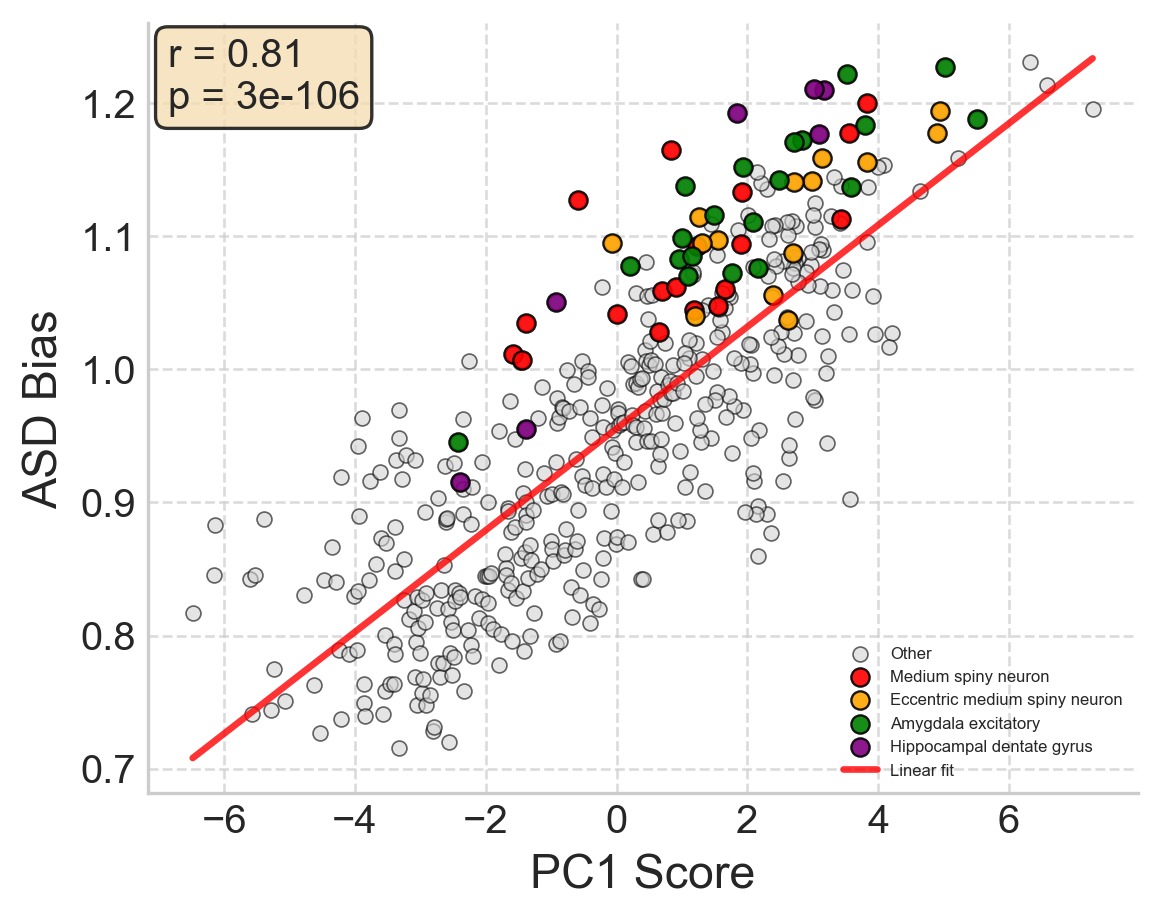

In [267]:
def plot_structure_bias_comparison_humanct(merged_data, metric='EFFECT', suffixes=('_1', '_2'), xlabel="", ylabel="", highlight_superclusters=None):
    """
    Plot structure bias comparison between two datasets.
    
    Parameters:
    -----------
    merged_data : DataFrame
        Merged structure bias data from merge_bias_datasets function
    metric : str
        Which metric to plot ('Rank' or 'EFFECT')
    suffixes : tuple of str
        Suffixes used in the merged data column names
    highlight_superclusters : list or None
        List of Superclusters to highlight on the scatter plot
    """

    plt.style.use('seaborn-v0_8-whitegrid')

    # First figure: Scatter plot
    fig1, ax1 = plt.subplots(1, 1, dpi=240, figsize=(5, 4), facecolor='none')

    fig1.patch.set_alpha(0)
    ax1.patch.set_alpha(0)

    # Create a copy for plotting
    plot_data = merged_data.copy()
    
    # Plot all data points with default color
    ax1.scatter(plot_data[f'{metric}{suffixes[1]}'], plot_data[f'{metric}{suffixes[0]}'], 
               c='lightgray', s=20, edgecolors='black', linewidth=0.5, alpha=0.6, label='Other')

    # Highlight specific superclusters if provided
    if highlight_superclusters is not None:
        # Define colors for highlighting
        highlight_colors = ['red', 'orange', 'green', 'purple', 'brown', 'pink', 'cyan', 'yellow']
        
        for i, supercluster in enumerate(highlight_superclusters):
            if supercluster in plot_data['Supercluster'].values:
                mask = plot_data['Supercluster'] == supercluster
                color = highlight_colors[i % len(highlight_colors)]
                ax1.scatter(plot_data.loc[mask, f'{metric}{suffixes[1]}'], 
                           plot_data.loc[mask, f'{metric}{suffixes[0]}'], 
                           c=color, s=30, edgecolors='black', linewidth=0.7, alpha=0.9, 
                           label=supercluster)

    # Fit linear regression model
    from sklearn.linear_model import LinearRegression
    from scipy.stats import pearsonr
    
    # Remove any rows with NaN values for the regression
    clean_data = merged_data[[f'{metric}{suffixes[0]}', f'{metric}{suffixes[1]}']].dropna()
    X = clean_data[[f'{metric}{suffixes[1]}']]
    y = clean_data[f'{metric}{suffixes[0]}']
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculate residuals and add to merged_data
    y_pred = model.predict(X)
    residuals = y - y_pred
    merged_data.loc[clean_data.index, f'residuals'] = residuals
    
    # Generate points for regression line
    x_range = np.linspace(X.min().values[0], X.max().values[0], 100)
    y_pred_line = model.predict(x_range.reshape(-1, 1))
    ax1.plot(x_range, y_pred_line, 'r-', linewidth=2, alpha=0.8, label='Linear fit')

    # Calculate correlation and p-value
    correlation, p_value = pearsonr(clean_data[f'{metric}{suffixes[0]}'], clean_data[f'{metric}{suffixes[1]}'])

    ax1.set_xlabel(xlabel, fontsize=14)
    ax1.set_ylabel(ylabel, fontsize=14)
    #ax1.set_title(title, fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=5)

    # Add text annotation for correlation, p-value, and model statistics
    ax1.text(0.02, 0.98, f'r = {correlation:.2f}\np = {p_value:.0e}', 
             transform=ax1.transAxes, fontsize=12, ha='left', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()
    
    return merged_data

humanct_merged_data = plot_structure_bias_comparison_humanct(humanct_merged_data, suffixes=('_ASD', '_Pfactor'), ylabel="ASD Bias", xlabel="PC1 Score", 
        highlight_superclusters=['Medium spiny neuron', 'Eccentric medium spiny neuron', 'Amygdala excitatory',
        'Hippocampal dentate gyrus',])

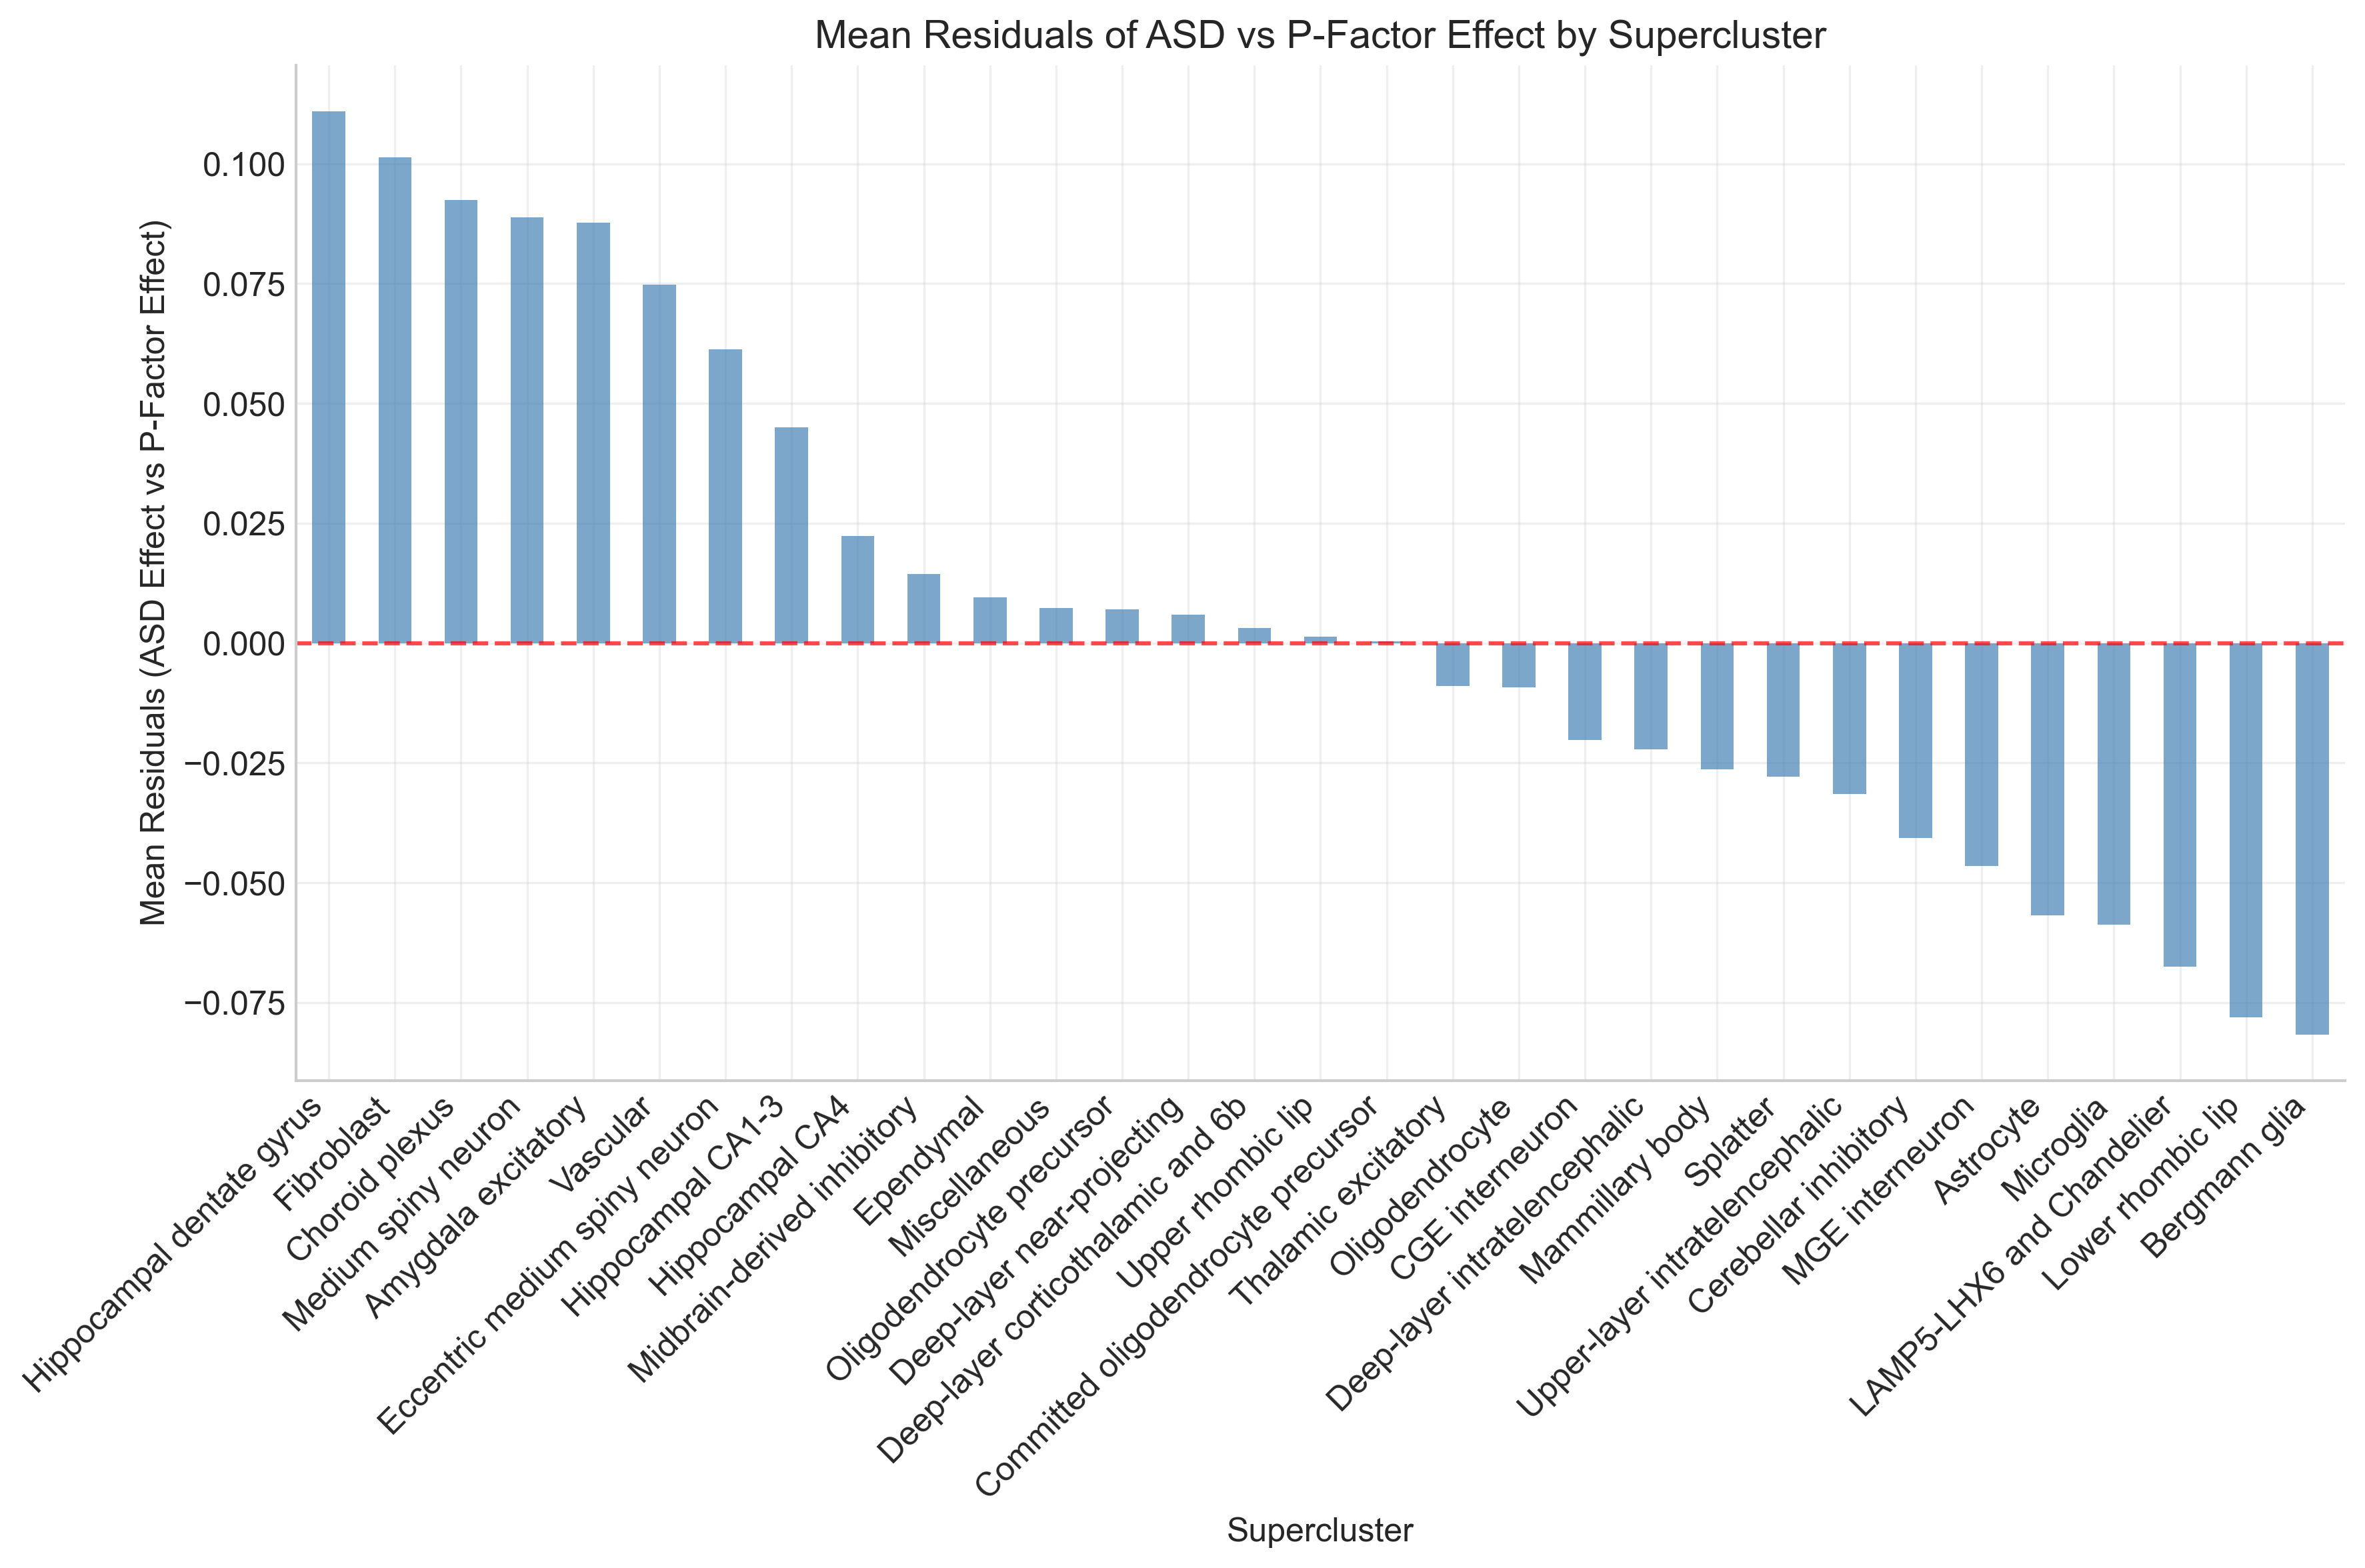

In [270]:
def plot_supercluster_residuals(merged_data, residual_column, ylabel="Mean Residuals", title="Mean Residuals by Supercluster"):
    """
    Create barplot of residuals grouped by Supercluster
    
    Parameters:
    merged_data: DataFrame containing the data
    residual_column: string, name of the residual column to plot
    ylabel: string, label for y-axis
    title: string, title for the plot
    
    Returns:
    supercluster_residuals: Series with mean residuals by supercluster
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 8))

    # Group by Supercluster and calculate mean residuals
    supercluster_residuals = merged_data.groupby('Supercluster')[residual_column].mean().sort_values(ascending=False)

    # Create barplot
    ax = supercluster_residuals.plot(kind='bar', color='steelblue', alpha=0.7)
    plt.xlabel('Supercluster', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    return supercluster_residuals

# Call the function
supercluster_residuals = plot_supercluster_residuals(
    humanct_merged_data, 
    'residuals',
    ylabel='Mean Residuals (ASD Effect vs P-Factor Effect)',
    title='Mean Residuals of ASD vs P-Factor Effect by Supercluster'
)

/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


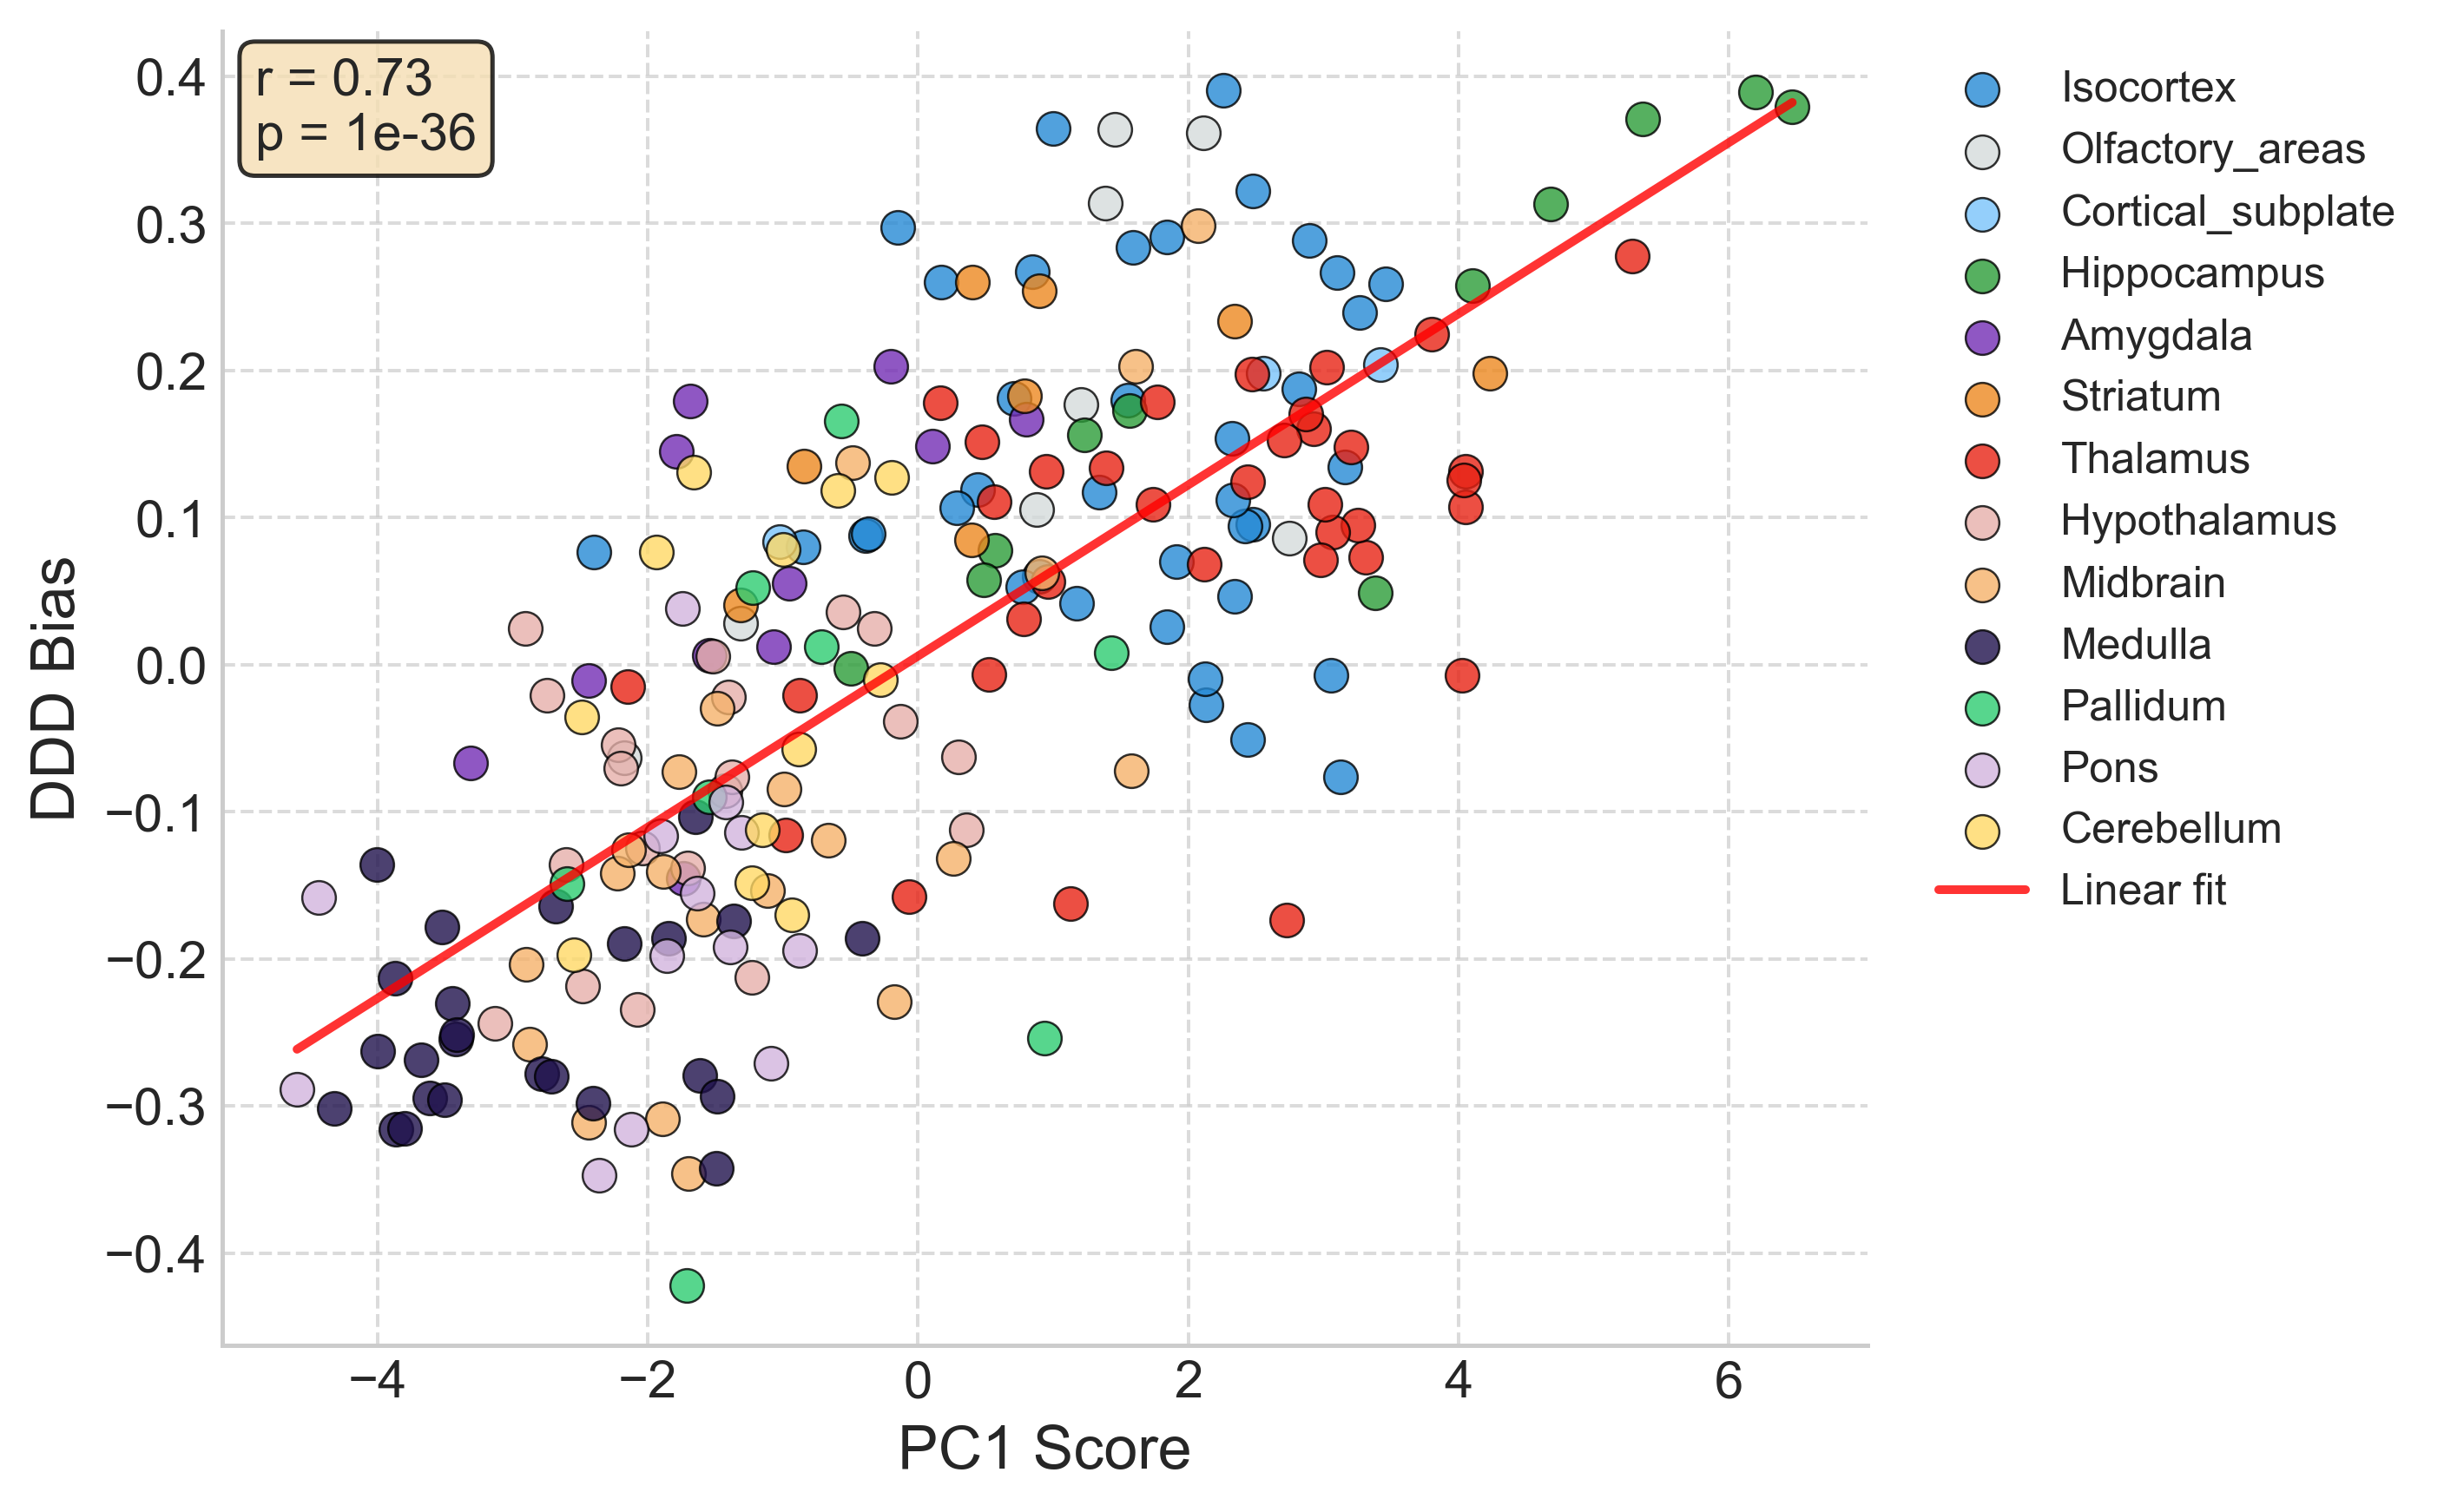

In [258]:
DDD_PFactor_MouseSTR = merge_bias_datasets(MouseSTR_DDD, MouseSTR_Pfactor, suffixes=('_DDD', '_Pfactor'))
DDD_PFactor_MouseSTR = plot_structure_bias_comparison(DDD_PFactor_MouseSTR, suffixes=('_DDD', '_Pfactor'), xlabel="PC1 Score", ylabel="DDD Bias")

Total structures in top 40 of at least one dataset: 62
Showing top 20 structures with largest differences (from top 40 filter)


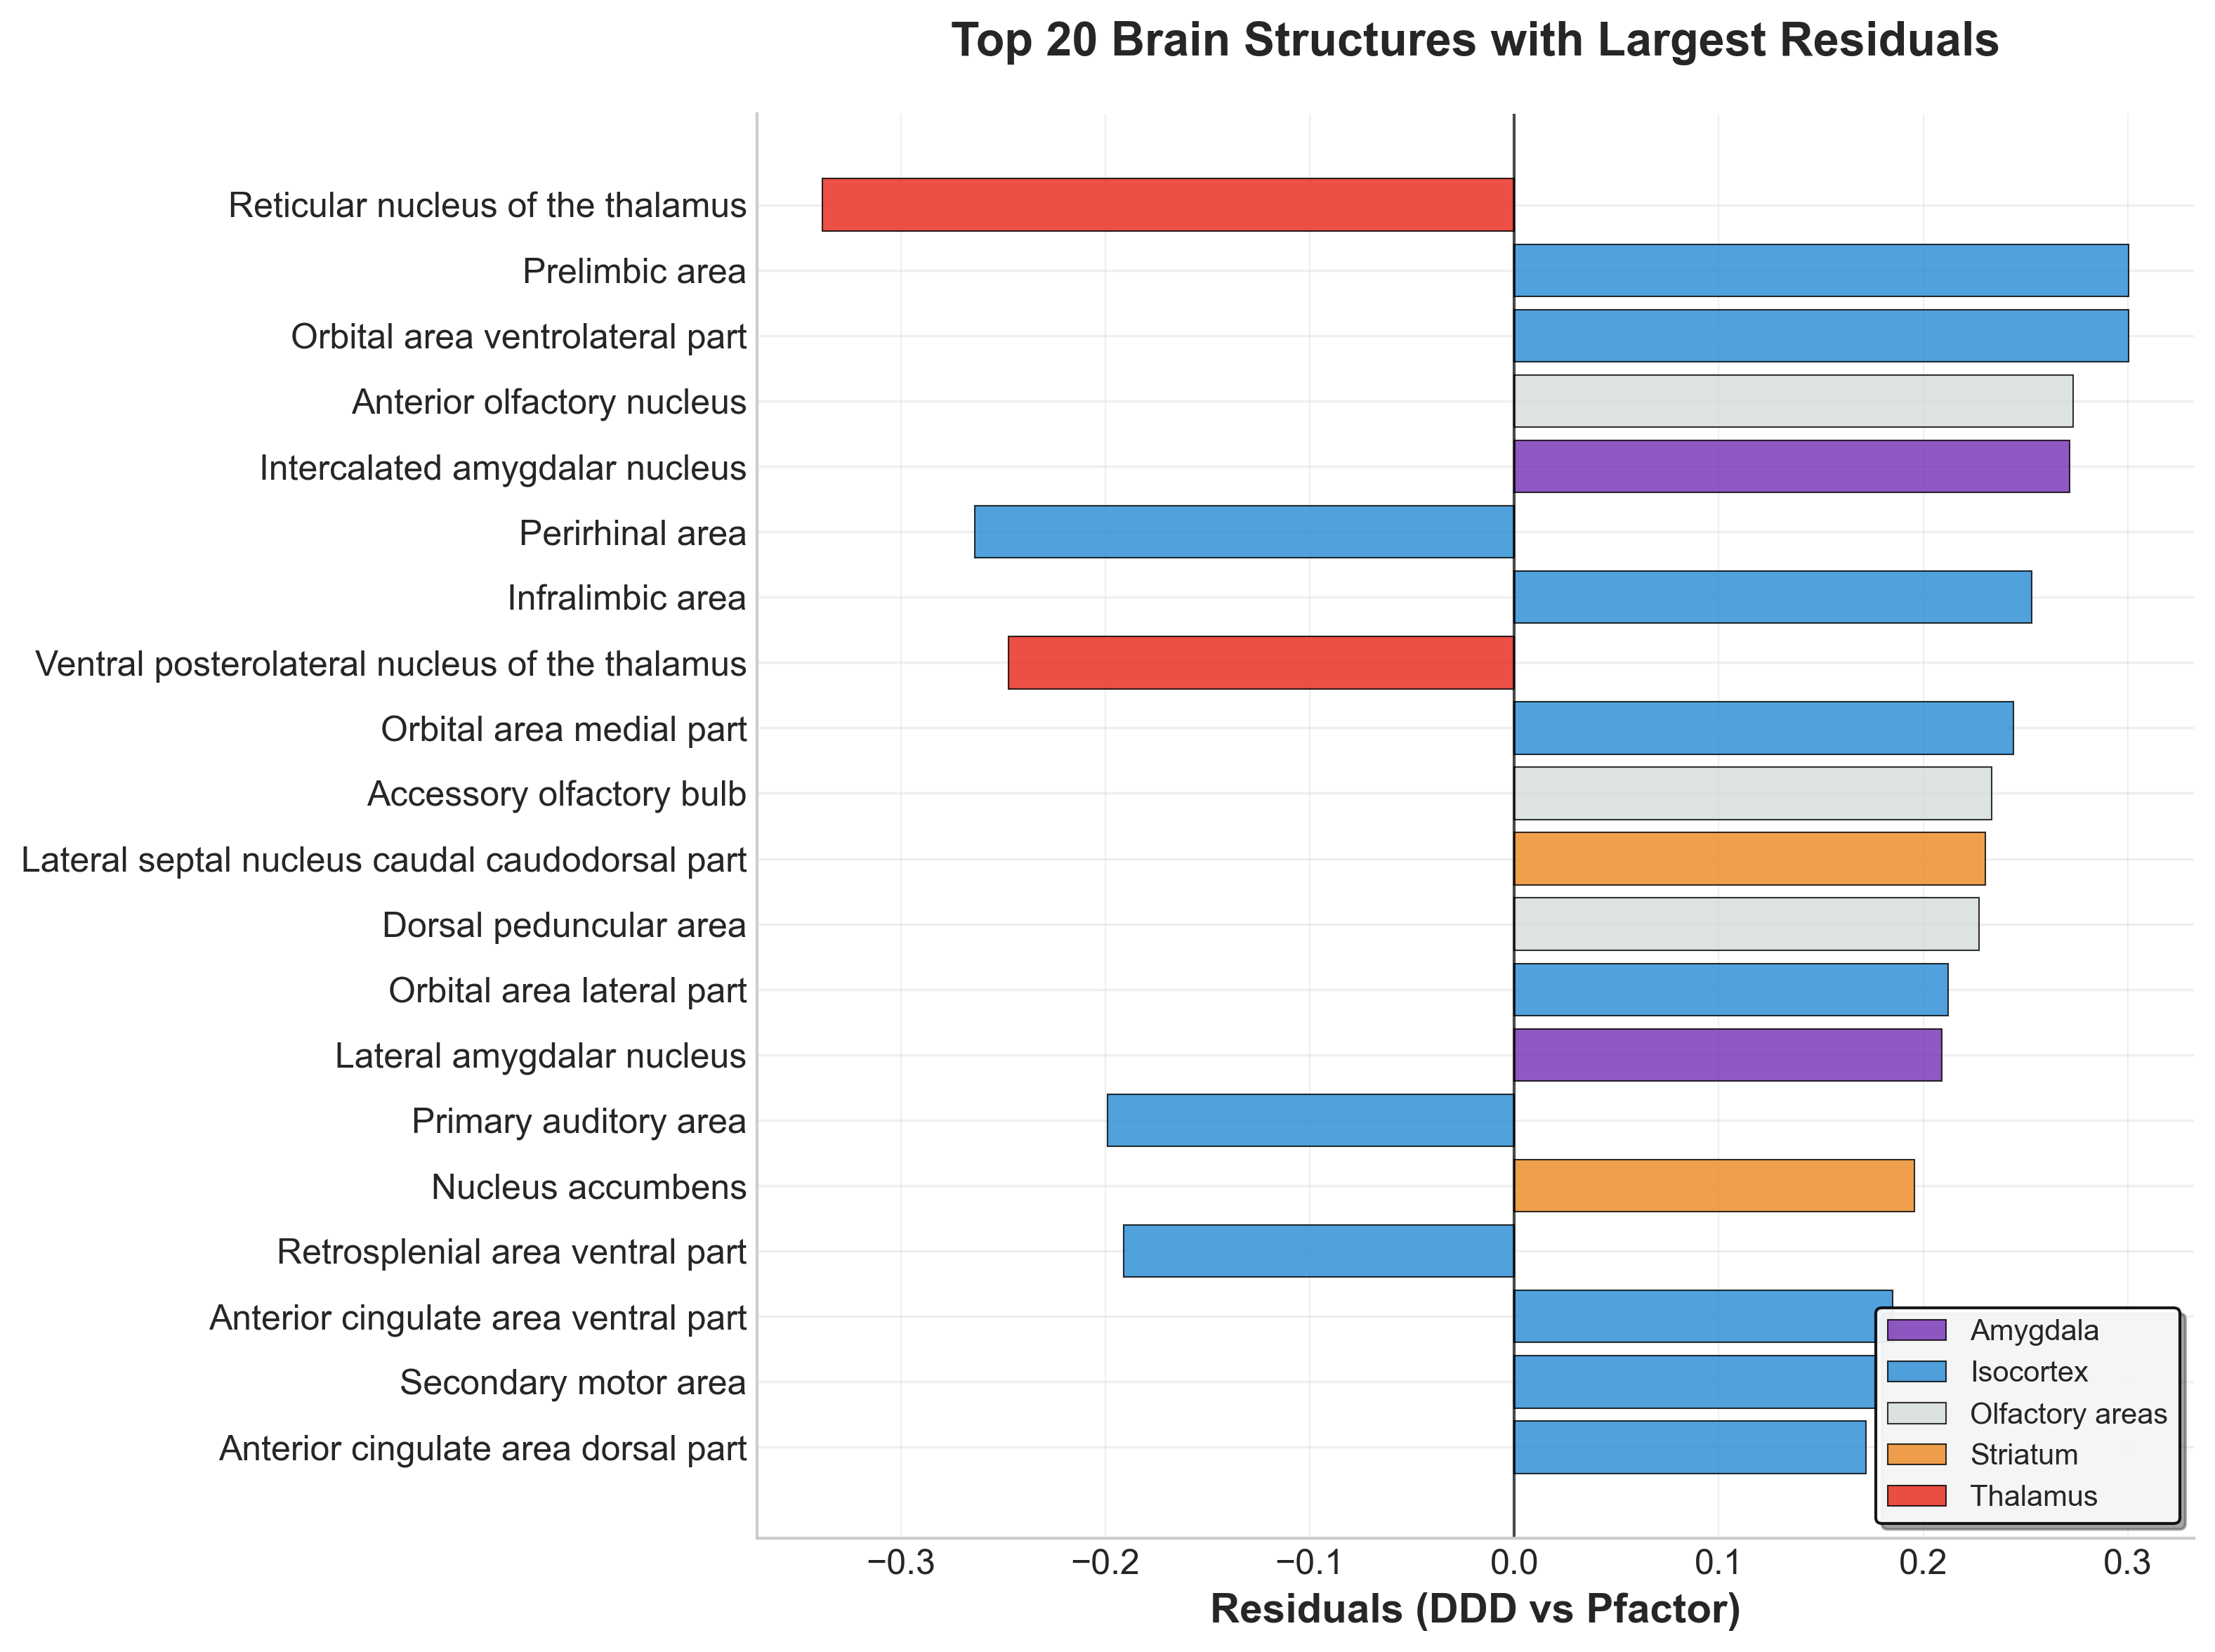

In [259]:
# Call the function
top_diff = plot_top_residual_structures(DDD_PFactor_MouseSTR, top_n=20, top_threshold=40,
                                       name1="DDD", name2="Pfactor")

In [260]:
HumanCT_Pfactor['Rank'] = HumanCT_Pfactor['PC1'].rank(ascending=False)
HumanCT_Pfactor['EFFECT'] = HumanCT_Pfactor['PC1']
DDD_PFactor_HumanCT = merge_bias_datasets_humanct(HumanCT_DDD, HumanCT_Pfactor, suffixes=('_DDD', '_Pfactor'))

In [276]:
HumanCT_DDD.head(10)

EFFECT  Rank Class                   Supercluster  Subtype  \
403  1.243527     1  NEUR                       Splatter      NaN   
136  1.161891     2  NEUR  Deep-layer intratelencephalic      NaN   
201  1.146724     3  NEUR      Hippocampal dentate gyrus  DG-GRAN   
228  1.141807     4  NEUR  Eccentric medium spiny neuron   MSN-D1   
405  1.136160     5  NEUR            Amygdala excitatory      NaN   
200  1.128892     6  NEUR      Hippocampal dentate gyrus  DG-GRAN   
229  1.128649     7  NEUR  Eccentric medium spiny neuron   MSN-D1   
202  1.124768     8  NEUR      Hippocampal dentate gyrus  DG-GRAN   
146  1.123837     9  NEUR  Deep-layer intratelencephalic      NaN   
217  1.099288    10  NEUR            Medium spiny neuron   MSN-D2   

    Neurotransmitter                                  Top three regions  \
403             GABA  Cerebral cortex: 45.6%, Amygdala: 33.5%, Hypot...   
136    VGLUT1 VGLUT2  Amygdala: 54.6%, Cerebral cortex: 36.2%, Hypot...   
201           VGLUT1  Hippocampus: 99.9%, Midbrain: 0.1%, Thalamus: ...   
228             GABA  Amygdala: 83.7%, Cerebral cortex: 12.2%, Thala...   
405    VGLUT1 VGLUT2  Cerebral cortex: 41.9%, Hypothalamus: 27.8%, A...   
200           VGLUT1  Hippocampus: 99.4%, Thalamus: 0.5%, Midbrain: ...   
229             GABA  Amygdala: 56.1%, Basal forebrain: 28.8%, Cereb...   
202           VGLUT1  Hippocampus: 100.0%, Cerebral cortex: 0.0%, Am...   
146    VGLUT1 VGLUT2  Amygdala: 65.4%, Cerebral cortex: 33.1%, Hypot...   
217             GABA  Amygdala: 69.5%, Basal forebrain: 15.7%, Hypot...   

                                 Top three dissections  Number of cells  \
403  Human AON: 25.7%, Human CoA: 18.1%, Human Pir:...           2608.0   
136  Human CoA: 54.6%, Human AON: 28.3%, Human HTHs...            152.0   
201  Human DGU-CA4Upy: 34.3%, Human DGR-CA4: 34.3%,...          18996.0   
228  Human La: 25.3%, Human BM: 17.5%, Human CEN: 1...           3227.0   
405  Human AON: 31.1%, Human HTHso: 26.6%, Human Co...           6125.0   
200  Human CA4C-DGC: 59.1%, Human DGR-CA4Rpy: 18.1%...          23293.0   
229  Human CEN: 21.7%, Human CMN: 17.8%, Human Cla:...           1857.0   
202  Human DGR-CA4Rpy: 87.7%, Human CA1R-CA2R-CA3R:...            398.0   
146  Human Pir: 22.2%, Human CEN: 19.8%, Human BL: ...           5654.0   
217  Human CEN: 36.4%, Human BNST: 21.2%, Human SI:...           7260.0   

                          Neuropeptide auto-annotation  P-value   Z-score  \
403  CCK CHGB CORT NAMPT NUCB NXPH PENK SCG TAC VGF...   0.0001  9.944672   
136  ADCYAP CBLN CCK CHGA CHGB CRH NAMPT NUCB PYY S...   0.0001  7.881961   
201      CBLN CHGB GRP IGF NAMPT NUCB PDYN UBL proSAAS   0.0001  7.527604   
228  CCK CHGA CHGB NAMPT NUCB PDYN SCG TAC UBL VGF ...   0.0001  7.448678   
405  CBLN CCK CHGA CHGB NAMPT NUCB SCG TAC UBL VGF ...   0.0001  7.210915   
200              CBLN CHGB GRP NAMPT NUCB PDYN proSAAS   0.0001  7.104221   
229  CCK CHGA CHGB NAMPT NUCB NXPH PDYN PENK SCG TA...   0.0001  7.012872   
202               CBLN CHGB GRP NAMPT NUCB UBL proSAAS   0.0001  7.039748   
146  ADCYAP CBLN CCK CHGA CHGB NAMPT NUCB SCG UBL V...   0.0001  6.899299   
217  CBLN CCK CHGA CHGB NAMPT NUCB PENK SCG UBL VGF...   0.0001  6.309599   

     EFFECT_adj   q-value     -logP  
403    0.409715  0.000363  4.000043  
136    0.328529  0.000363  4.000043  
201    0.314356  0.000363  4.000043  
228    0.307027  0.000363  4.000043  
405    0.300709  0.000363  4.000043  
200    0.296054  0.000363  4.000043  
229    0.293405  0.000363  4.000043  
202    0.294231  0.000363  4.000043  
146    0.288533  0.000363  4.000043  
217    0.263711  0.000363  4.000043

/home/jw3514/miniconda3/envs/gencic/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


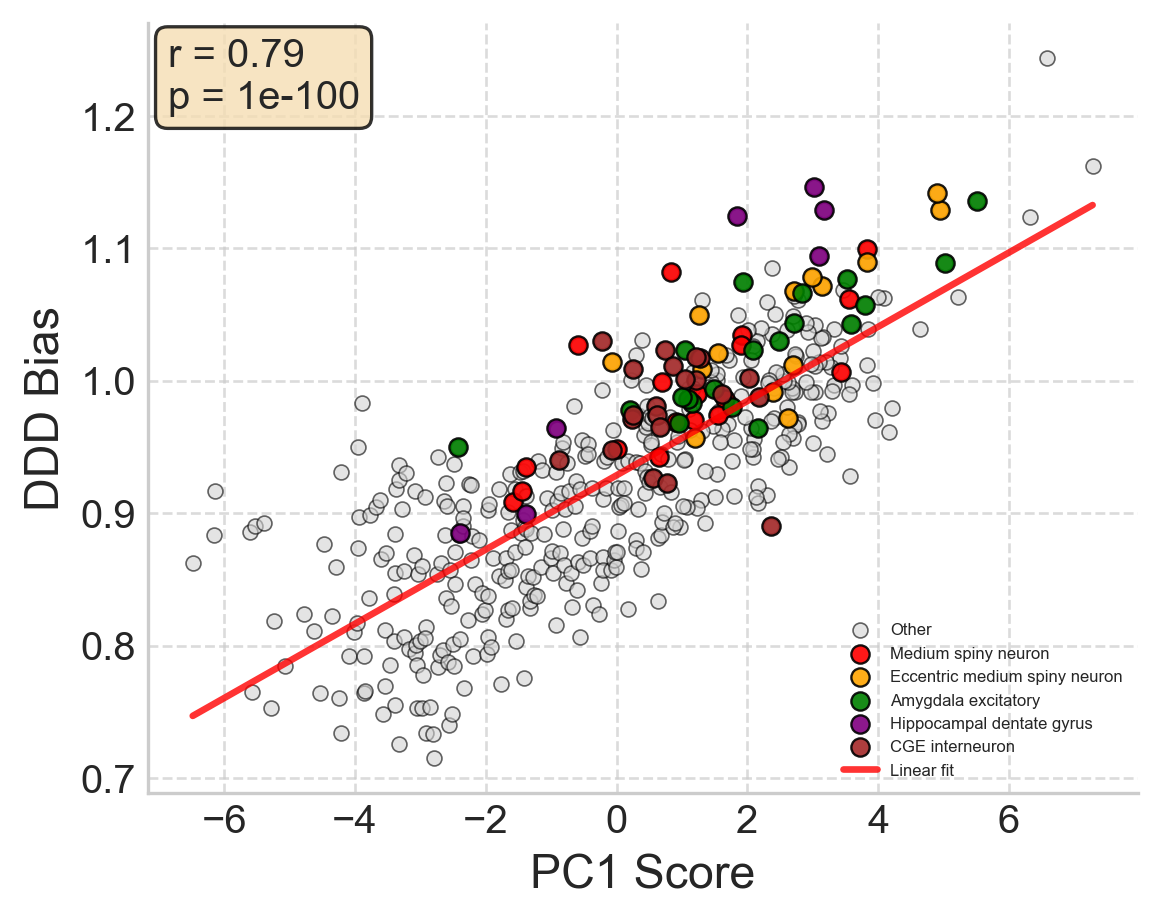

In [274]:
DDD_PFactor_HumanCT = plot_structure_bias_comparison_humanct(DDD_PFactor_HumanCT, suffixes=('_DDD', '_Pfactor'), ylabel="DDD Bias", xlabel="PC1 Score", 
        highlight_superclusters=['Medium spiny neuron', 'Eccentric medium spiny neuron', 'Amygdala excitatory',
        'Hippocampal dentate gyrus','CGE interneuron'])

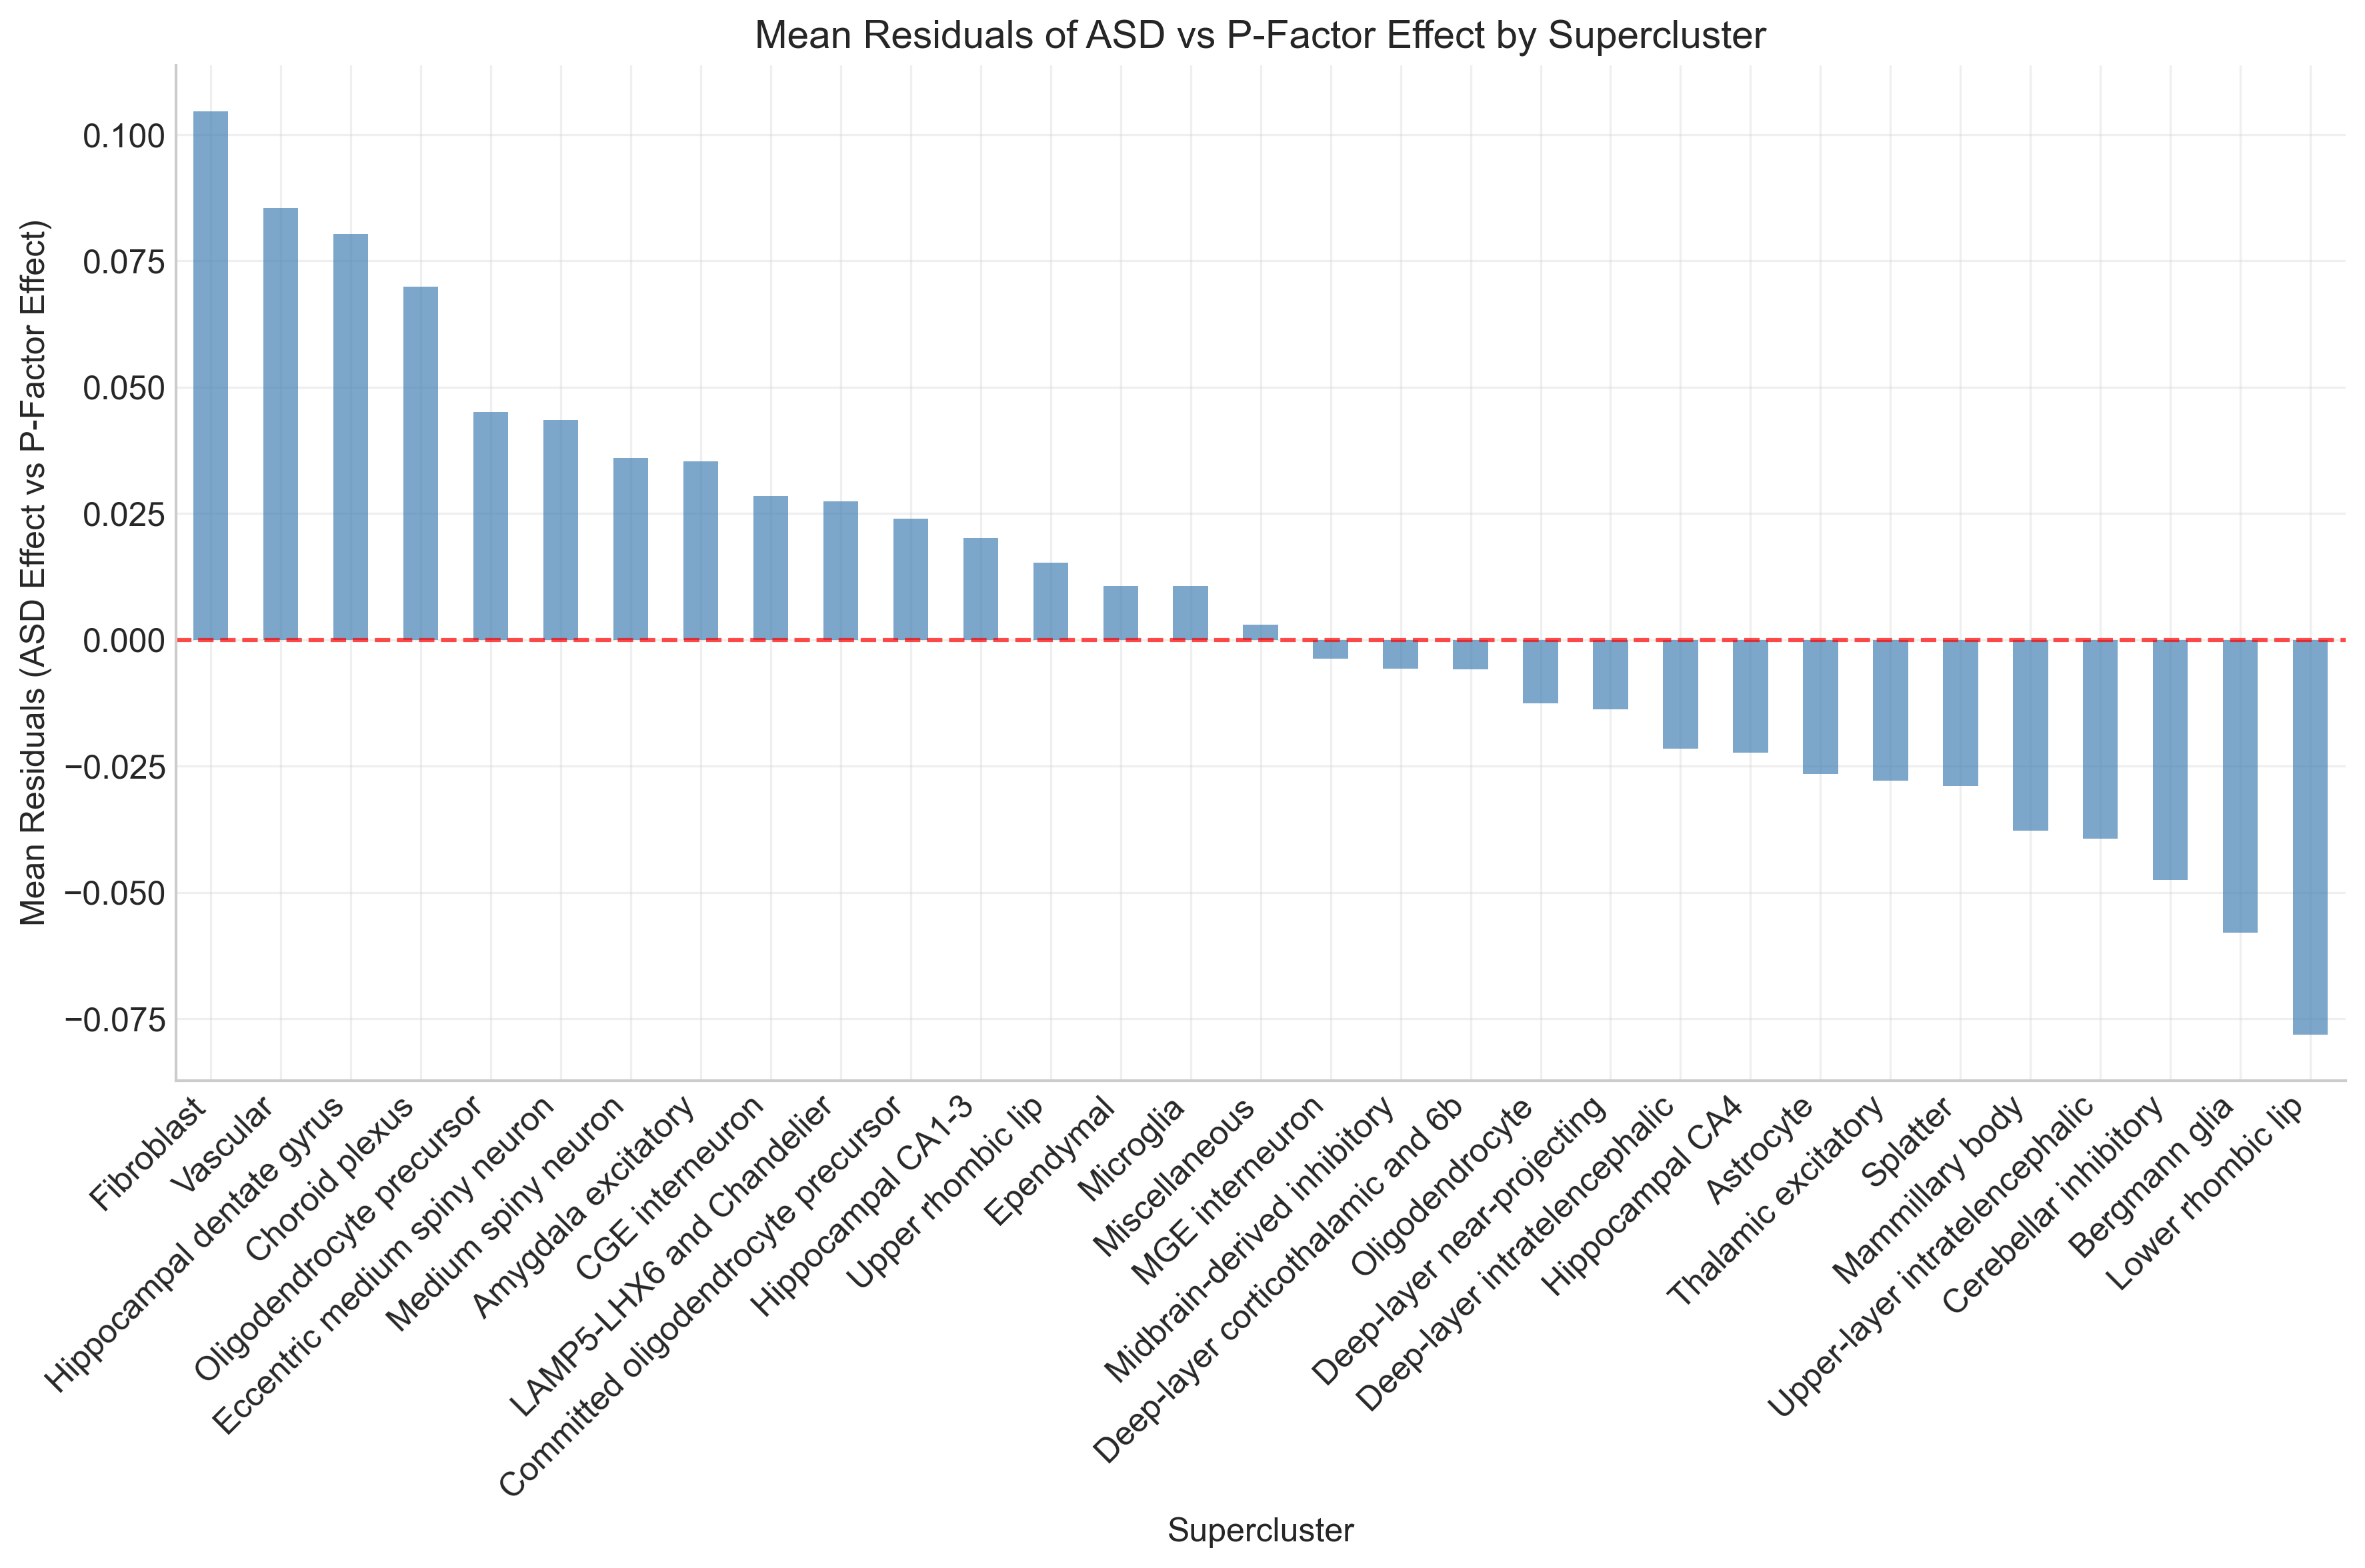

In [272]:
# Call the function
supercluster_residuals = plot_supercluster_residuals(
    DDD_PFactor_HumanCT, 
    'residuals',
    ylabel='Mean Residuals (ASD Effect vs P-Factor Effect)',
    title='Mean Residuals of ASD vs P-Factor Effect by Supercluster'
)

In [273]:
supercluster_residuals

Supercluster
Fibroblast                             0.104654
Vascular                               0.085458
Hippocampal dentate gyrus              0.080283
Choroid plexus                         0.069970
Oligodendrocyte precursor              0.045159
Eccentric medium spiny neuron          0.043530
Medium spiny neuron                    0.036031
Amygdala excitatory                    0.035335
CGE interneuron                        0.028476
LAMP5-LHX6 and Chandelier              0.027417
Committed oligodendrocyte precursor    0.024009
Hippocampal CA1-3                      0.020164
Upper rhombic lip                      0.015306
Ependymal                              0.010689
Microglia                              0.010661
Miscellaneous                          0.002988
MGE interneuron                       -0.003701
Midbrain-derived inhibitory           -0.005766
Deep-layer corticothalamic and 6b     -0.005831
Oligodendrocyte                       -0.012560
Deep-layer near-projecting 